In [2]:
import os
import itertools
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.timeseries import LombScargle
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from pmdarima.arima import auto_arima

from ruptures import Pelt
from scipy.signal import welch
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss

import ipywidgets as widgets
import ruptures as rpt

%matplotlib inline

warnings.filterwarnings("ignore")

## 1. Data Reading
- a. Read the provided .csv file and load the data into a suitable data structure (e.g., pandas DataFrame) 

- b. Convert time from Matlab's date format to a standard date format (e.g., datetime) 

In [3]:
filename = "Test_data.csv"
raw_df = pd.read_csv(filename, header=None)
raw_df.columns = ['datetime', 'ts1', 'ts2']
raw_df['datetime'] = pd.to_datetime(raw_df['datetime']-719529,unit='d').round('s')
raw_df.set_index('datetime', inplace = True)

# date = df['datetime']

raw_df.head(10)


,ts1,ts2
datetime,,
2008-01-01 00:00:45,NaN,NaN
2008-01-01 00:02:45,NaN,0.87505
2008-01-01 00:04:45,NaN,NaN
2008-01-01 00:06:45,NaN,NaN
2008-01-01 00:08:45,NaN,NaN
2008-01-01 00:10:45,NaN,NaN
2008-01-01 00:12:45,NaN,NaN
2008-01-01 00:14:45,NaN,NaN
2008-01-01 00:16:45,NaN,NaN


In [4]:
# a = raw_df['ts2'].resample('30T').mean()
# a = a[:3*48]
# a.plot()
# a
# # sat = a.index[a.index.weekday == 5]
# # a[sat].plot(style='g-')
# # sunday = a.index[a.index.weekday == 6]
# # a[sunday].plot(style='r-')

# 2. Data preparation and cleaning

- c. Handle missing data (NaN values) by: 
- i. Identifying the extent of missing data in each time series 
- ii. Deciding on an appropriate imputation method (e.g., forward fill, interpolation, or dropping missing data)


In [5]:
def data_stat(raw_df):
    desc = raw_df.describe(include = 'all')
    desc.loc['type'] = raw_df.dtypes
    desc.loc['median'] = raw_df.median()*10000//100/100
    desc.loc['mean'] = raw_df.mean()*10000//100/100
    desc.loc['mode'] = raw_df.mode().iloc[0]
    desc.loc['missing'] = (100. * raw_df.isna().sum() /len(raw_df)).round(2).astype(str) + '%'
    desc.loc['unique'] = raw_df.nunique()
    desc.loc['min'] = raw_df.min()
    desc.loc['max'] = raw_df.max()

    cols = ['type', 'count', 'missing', 'unique', 'min', '25%', '50%', '75%', 'max', 'mean', 'median', 'std', 'mode']
    desc = desc.loc[cols].round(2)
    return desc


# data_table.DataTable(data_stat(raw_df), 
#                      include_index=True, 
#                      num_rows_per_page=13,
#                      max_columns = len(raw_df.columns))
data_stat(raw_df)

,ts1,ts2
type,float64,float64
count,201517.0,936488.0
missing,84.68%,28.81%
unique,3901,10114
min,91.512942,0.60115
25%,95.106221,0.87145
50%,95.462056,0.945
75%,96.042938,1.0278
max,96.852863,1.10805
mean,95.17,0.92


No negative prices 

In [6]:
# Plot data
def missing_range(series):
    # Identify the start and end indices of consecutive missing values in the series
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    ranges = mask.groupby(changes).apply(lambda x: (x.index[0], x.index[-1]))
    return ranges

def plot_time_series(ts1, ts2, ts1_label='ts1', ts2_label='ts2', figsize=(12, 10)):
    # Create subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot first time series on first subplot
    axs[0].plot(ts1)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].set_title(ts1_label)

    # Plot second time series on second subplot
    axs[1].plot(ts2)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].set_title(ts2_label)

    # # Plot third time series on both subplots if it is provided
    # if ts3 is not None:
    #     axs[0].scatter(ts3, c='red')
    #     if ts3_label is not None:
    #         axs[0].legend([ts1_label, ts3_label])
    #     else:
    #         axs[0].legend([ts1_label, 'ts3'])

    # if ts4 is not None:
    #     axs[1].scatter(ts4, c='red')
    #     if ts4_label is not None:
    #         axs[1].legend([ts2_label, ts4_label])
    #     else:
    #         axs[1].legend([ts2_label, 'ts4'])

    # # Plot vertical lines for missing data ranges in ts3 and ts4
    # for ts, ax in zip([ts3, ts4], axs):
    #     if ts is not None:
    #         for missing in missing_range(ts):
    #             ax.axvspan(missing[0], missing[1], color='gray', alpha=0.3)

    plt.show()

Count missing values

In [7]:
# Function to count missing values in a series
def count_missing_values(series):
    return series.isna().sum()

# Function to find the maximum length of continuous missing values in a series
def max_missing_range(series):
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    counts = mask.groupby(changes).sum()
    counts = counts[counts > 1]
    if counts.empty:
        return 0
    else:
        return counts.max()

# Function to impute missing values in a series using a moving mean
def impute_missing_values(series, window):
    if series.isnull().any():
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        return series.fillna(rolling_mean)
    else:
        return series

# Function to convert intervals to days
def intervals_to_days(intervals):
    minutes = intervals * 2
    hours = minutes / 60
    days = hours / 24
    return days

In [8]:
#Define the time series
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']

In [9]:
# Count missing values in ts1 and ts2
missing_ts1 = count_missing_values(ts1)
missing_ts2 = count_missing_values(ts2)
print(f"Missing values in ts1: {missing_ts1}")
print(f"Missing values in ts2: {missing_ts2}")

# Get the maximum missing range in ts1 and ts2
max_ts1 = max_missing_range(ts1)
max_ts2 = max_missing_range(ts2)
print(f"Max missing range in ts1: {max_ts1}")
print(f"Max missing range in ts2: {max_ts2}")

# Convert the maximum missing ranges to days
days_ts1 = intervals_to_days(max_ts1)
days_ts2 = intervals_to_days(max_ts2)
print(f"Max missing range in ts1: {days_ts1:.2f} days")
print(f"Max missing range in ts2: {days_ts2:.2f} days")

# So min window size for any imputation/smoothing should be 5 days and 3 days respectively for ts1 and 2

Missing values in ts1: 1113924
Missing values in ts2: 378953
Max missing range in ts1: 3579
Max missing range in ts2: 2139
Max missing range in ts1: 4.97 days
Max missing range in ts2: 2.97 days


Analyse missing values

Understand the nature of the missing data: Determine if the data is missing completely at random (MCAR), missing at random (MAR), or missing not at random (MNAR). This will help you choose an appropriate imputation method.

Missing Completely at Random (MCAR): Data is MCAR when the probability of a value being missing is unrelated to both the observed and unobserved data. In other words, the missingness is entirely random and does not depend on any variable.

Missing at Random (MAR): Data is MAR when the probability of a value being missing depends on the observed data but not on the unobserved data. In other words, the missingness can be explained by other observed variables.

Missing Not at Random (MNAR): Data is MNAR when the probability of a value being missing depends on the unobserved data. In other words, the missingness is related to the actual missing values themselves.

In [10]:
!pip install missingno

In [11]:
# #MCAR
# import missingno as msno
# import pandas as pd

# # Visualize missing data
# msno.matrix(raw_df)

# # Test for MCAR
# # result = msno.mcar_test(raw_df)
# # print(result)

# # Test for MAR
# # First, create a missing indicator variable
# # First, create the missing indicator for the entire dataset

# # First, create the missing indicator for the entire dataset
# missing_indicator = raw_df.isnull().astype(int)

# # Replace 'column_name' with the actual name of the column you want to predict the missingness for
# column_name = 'ts1'

# # Then, filter the missing_indicator to have the same indices as observed_data
# observed_data = raw_df.dropna()
# observed_missing_indicator = missing_indicator.loc[observed_data.index, column_name]

# # Fit a regularized logistic regression model using L1 (Lasso) regularization
# # logit_model = sm.Logit(observed_missing_indicator, observed_data)
# # result = logit_model.fit_regularized(method='l1', alpha=1.0)  # You can adjust the alpha parameter for the regularization strength
# # print(result.summary())



# # Generate a nullity correlation heatmap
# msno.heatmap(raw_df)

# # Generate a dendrogram to explore the hierarchical structure of missingness
# msno.dendrogram(raw_df)
# #MNAR
# #Use selection model or pattern-mixture model

Check this time gaps of the intervals in the data (just do once for entire dataframe)

Time gaps:

count            1315440
mean     0 days 00:02:00
std      0 days 00:00:00
min      0 days 00:02:00
25%      0 days 00:02:00
50%      0 days 00:02:00
75%      0 days 00:02:00
max      0 days 00:02:00
Name: datetime, dtype: object


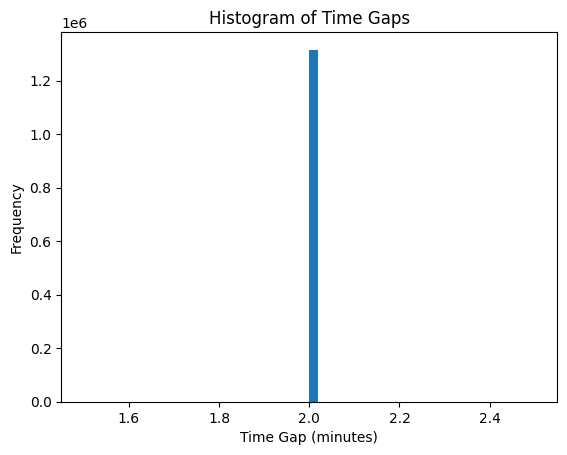

In [12]:
# Assuming 'df' is r DataFrame containing stock price data with a DateTimeIndex
time_gaps = raw_df.index.to_series().diff().dropna()
time_gap_stats = time_gaps.describe()
print('Time gaps:\n')
print(time_gap_stats)
outlier_threshold = pd.Timedelta(minutes=10)
outliers = time_gaps[time_gaps > outlier_threshold]
plt.hist(time_gaps.dt.total_seconds() / 60, bins=50)
plt.xlabel('Time Gap (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Gaps')
plt.show()

So all of the datapoints are equally spaced 2 minute intervals

Resample and check for missing days: Saturdays do not appears in the data since the market is closed. Sundays are just the late hours. Otherwise the data appears to be 24hr price excuding missing values

In [13]:
def count_days_frequency(series: pd.Series) -> pd.Series:
    # Drop rows with NaN values
    series = series.dropna()

    # Extract the day of the week from the index and create a new Series with 'day_of_week' as the index
    day_of_week_series = pd.Series(series.index.dayofweek, index=series.index)

    # Count the frequency of each day of the week
    day_counts = day_of_week_series.value_counts().sort_index()

    # Replace the numeric day of the week with the actual day name
    day_counts.index = pd.to_datetime(day_counts.index, unit='D', origin=pd.Timestamp('2000-01-03')).day_name()

    return day_counts

In [14]:
day_counts = count_days_frequency(ts1.resample('D').mean())
print(day_counts)
day_counts = count_days_frequency(ts2.resample('D').mean())
print(day_counts)

Monday       258
Tuesday      259
Wednesday    261
Thursday     260
Friday       253
Sunday       243
Name: datetime, dtype: int64
Monday       261
Tuesday      262
Wednesday    261
Thursday     261
Friday       260
Sunday       259
Name: datetime, dtype: int64


saturdays are missing since market is closed on saturays. so remove Saturday and find the new missing data.

In [15]:
raw_df_ns = raw_df.copy()
# Assuming 'df' is r DataFrame with a DateTimeIndex
raw_df_ns = raw_df_ns[raw_df_ns.index.dayofweek != 5]  # 5 represents Saturday

What is the distribution of gaps in the missing data without Saturdays (may still include holidays)

In [16]:
ts_1_ns = raw_df_ns['ts1']
ts_2_ns = raw_df_ns['ts2']
# Count missing values in ts1 and ts2
missing_ts1_ns = count_missing_values(ts_1_ns)
missing_ts2_ns = count_missing_values(ts_2_ns)
print(f"Missing values in ts1: {missing_ts1_ns}")
print(f"Missing values in ts2: {missing_ts2_ns}")

# Get the maximum missing range in ts1 and ts2
max_ts1_ns = max_missing_range(ts_1_ns)
max_ts2_ns = max_missing_range(ts_2_ns)
print(f"Max missing range in ts1: {max_ts1_ns}")
print(f"Max missing range in ts2: {max_ts2_ns}")

# Convert the maximum missing ranges to days
days_ts1_ns = intervals_to_days(max_ts1_ns)
days_ts2_ns = intervals_to_days(max_ts2_ns)
print(f"Max missing range in ts1: {days_ts1_ns:.2f} days")
print(f"Max missing range in ts2: {days_ts2_ns:.2f} days")

Missing values in ts1: 926004
Missing values in ts2: 191033
Max missing range in ts1: 2859
Max missing range in ts2: 1419
Max missing range in ts1: 3.97 days
Max missing range in ts2: 1.97 days


So without saturdays there are still a large number of missing days 

In [17]:
def plot_streak_histogram_1(ts, title):
    isnull = ts.isnull()
    groups = isnull.ne(isnull.shift()).cumsum()
    streak_lengths = isnull.groupby(groups).sum()

    bins = pd.cut(streak_lengths, bins=[0, 1, 2, 3, 4, 5, 10, 100, 1000, streak_lengths.max()],
                labels=[str(x*2) + ' mins' for x in range(1, 6)] + ['22 mins', '4 hours', '1.3 days', '4+ days'])
    plt.figure(figsize=(8, 7))
    # plot histogram of binned data
    ax = bins.value_counts().sort_index().plot(kind='bar', edgecolor='black')
    plt.title(title)
    # add values to bars
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    # show the plot
    plt.show()


In [18]:
    isnull = ts_1_ns.isnull()
    groups = isnull.ne(isnull.shift()).cumsum()
    streak_lengths = isnull.groupby(groups).sum()

    bins = pd.cut(streak_lengths, bins=[0, 1, 2, 3, 4, 5, 10, 100, 1000, streak_lengths.max()],
                labels=[str(x*2) + ' mins' for x in range(1, 6)] + ['22 mins', '4 hours', '1.3 days', '4+ days'])
    bins

ts1
1         1.3 days
2              NaN
3           4 mins
4              NaN
5           6 mins
            ...   
209629      2 mins
209630         NaN
209631      2 mins
209632         NaN
209633    1.3 days
Name: ts1, Length: 209633, dtype: category
Categories (9, object): ['2 mins' < '4 mins' < '6 mins' < '8 mins' ... '22 mins' < '4 hours' < '1.3 days' < '4+ days']

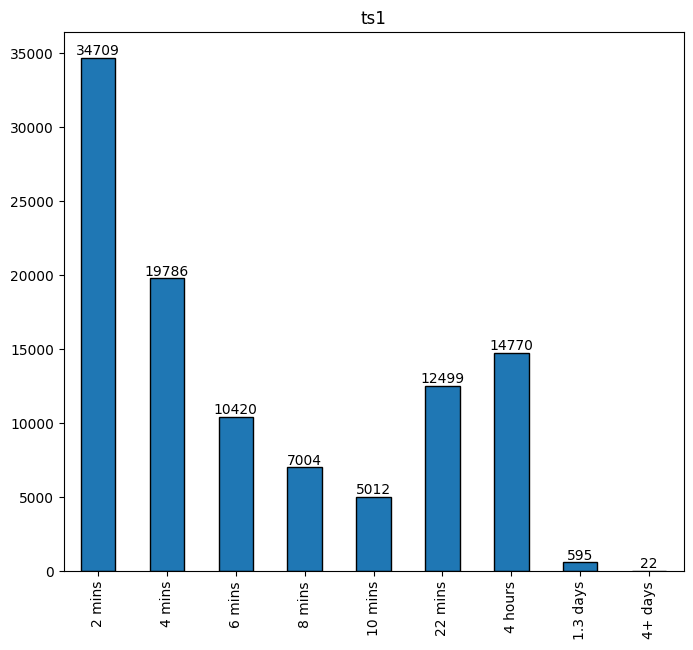

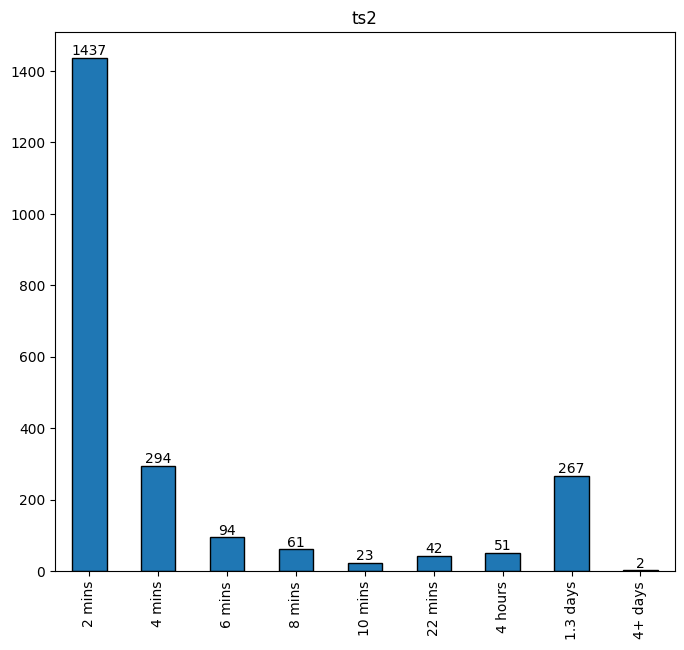

In [19]:
#find duraiton of missing segments
plot_streak_histogram_1(ts_1_ns, 'ts1')
plot_streak_histogram_1(ts_2_ns, 'ts2')

Non-uniform distribution: Instead of a single peak around the expected 2-minute interval, the histogram shows a wide distrution of time gaps

The frequency of streak lengths decreases as the streak length increases. This indicates that shorter streaks (smaller time gaps) are more common in the data, while longer streaks (larger time gaps) are less frequent. 

Presence of outliers: The histogram show some bars far away from the main distribution, representing unusually large time gaps. These outliers could be due to holidays, market closed days, or other events that cause irregular time gaps in the data.

Skewness: The histogram might to the right , indicating that the time gaps are not symmetrically distributed around the expected 2-minute interval. This could suggest that there are more frequent occurrences of either shorter or longer time gaps than expected.

Long tails: The histogram has a long tail, indicating that there are a significant number of time gaps that are much larger than the expected 2-minute interval. This could be a sign of irregularities in the data collection process or other factors affecting the time intervals between data points.

In [20]:
def calculate_time_gaps(ts):
    # Assuming ts is r time series data
    isnull = ts.isnull()
    groups = isnull.ne(isnull.shift()).cumsum()
    streak_lengths = isnull.groupby(groups).sum()

    # Calculate the time gaps between missing value streaks
    time_gaps = pd.to_timedelta(streak_lengths[streak_lengths > 0] * 2, unit='m')
    
    return time_gaps

def time_gaps_stats(series):
    return (series.dt.total_seconds() / 60).describe()
    

# Call the function with the time_gaps variable
time_gaps_1 = calculate_time_gaps(ts_1_ns)
print(time_gaps_stats(time_gaps_1))
time_gaps_2 = calculate_time_gaps(ts_2_ns)
print(time_gaps_stats(time_gaps_2))


count    104817.000000
mean         17.668966
std         101.135273
min           2.000000
25%           2.000000
50%           4.000000
75%          12.000000
max        5718.000000
Name: ts1, dtype: float64
count    2271.000000
mean      168.236900
std       453.508762
min         2.000000
25%         2.000000
50%         2.000000
75%         4.000000
max      2838.000000
Name: ts2, dtype: float64


Time Series 1 (ts1):

There are 104,817 time gaps in the data.
The average time gap is approximately 17.67 minutes.
The standard deviation of the time gaps is around 101.14 minutes, indicating a wide range of time gaps.
The minimum time gap is 2 minutes.
The 25th percentile (Q1) is 2 minutes, meaning 25% of the time gaps are 2 minutes or less.
The median (50th percentile) is 4 minutes, indicating that half of the time gaps are 4 minutes or less.
The 75th percentile (Q3) is 12 minutes, meaning 75% of the time gaps are 12 minutes or less.
The maximum time gap is 5,718 minutes, which is quite large compared to the other percentiles.
Time Series 2 (ts2):

There are 2,271 time gaps in the data.
The average time gap is approximately 168.24 minutes.
The standard deviation of the time gaps is around 453.51 minutes, indicating a wide range of time gaps.
The minimum time gap is 2 minutes.
The 25th percentile (Q1) is 2 minutes, meaning 25% of the time gaps are 2 minutes or less.
The median (50th percentile) is 2 minutes, indicating that half of the time gaps are 2 minutes or less.
The 75th percentile (Q3) is 4 minutes, meaning 75% of the time gaps are 4 minutes or less.
The maximum time gap is 2,838 minutes, which is quite large compared to the other percentiles.
From these statistics, we can observe that Time Series 1 has a higher average time gap and a larger maximum time gap compared to Time Series 2. However, both time series have a wide range of time gaps, as indicated by their large standard deviations.

From the distribution of missing value lengths in the time series data, it seems that most of the missing values are of shorter lengths, with a few longer gaps. The descriptive statistcs show that the values however are widely distributed. In this case, a combination of imputation methods might be appropriate to handle both short and long gaps..

For shorter gaps,  can use time-weighted interpolation or moving mean imputation, as they can capture local trends and patterns in the data. Time-weighted interpolation assumes that the stock prices change linearly within short time gaps, while moving mean imputation assumes that the local average of the surrounding data points is a reasonable estimate for the missing values.

For longer gaps,  consider using a more sophisticated method like the Expectation-Maximization (EM) algorithm, which iteratively estimates the missing values based on the available data and the fitted model. This method can be more appropriate for handling longer gaps, as it takes into account the overall structure and patterns in the data.

Impute the issing values using the two methods for short time frame and long time frame sectoins of missing values. Short time gaps is consider less than 4 hours (240 minutes), since the data is very dense in ery short intervals of 2 minutes. hus any time gaps longer will be imputed using the expectation maximzation. Will use a rolling window of 4 hours for the moving mean imputation. 

Will use the orignal data including saturdays as For interval seasonal models like arima, equally spaced time interval data is required which is not possible if saturdays are excluded, so will need to impute for the missing time intervals 



In [26]:
# # Function to impute missing values in a series using a moving mean
# def rolling_mean(series, window=120):
#     if series.isnull().any():
#         rolling_mean = series.rolling(window=window, min_periods=1).mean()
#         imputed_series = series.fillna(rolling_mean)
#         imputed_series.fillna(method='bfill', inplace=True)  # Backfill since missing starting data
#     else:
#         imputed_series = series
#     return imputed_series

def rolling_mean(series, window=120):
    if series.isnull().any():
        # Create a copy of the series
        imputed_series = series.copy()
        
        # Identify the non-missing blocks of data
        non_missing_blocks = series.notna().astype(int).groupby(series.isna().astype(int).cumsum()).cumsum()

        # Loop through the non-missing blocks and calculate the rolling mean for each block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)  # Change this line to fix the error
            rolling_mean_block = series[start_idx:end_idx].rolling(window=window, min_periods=1).mean()
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(rolling_mean_block)
        
        imputed_series.fillna(method='bfill', inplace=True)  # Backfill since missing starting data
    else:
        imputed_series = series
    return imputed_series

# # Alternate faster rolling mean to test
# def rolling_mean(series, window=120):
#     # Create a copy of the series
#     imputed_series = series.copy()

#     # Identify contiguous segments of missing values
#     missing_value_segments = (series.isna().astype(int).groupby(series.notna().astype(int).cumsum()).sum() > 0)
    
#     # Get start and end indices of non-missing segments
#     non_missing_segments = series[~missing_value_segments.reindex(series.index, fill_value=False)].groupby(series.notna().astype(int).cumsum())
#     non_missing_indices = [(segment.index[0], segment.index[-1] + pd.Timedelta(minutes=2)) for _, segment in non_missing_segments]

#     # Calculate rolling mean for each non-missing segment and impute missing values within the segment
#     for start_idx, end_idx in non_missing_indices:
#         rolling_mean_segment = series[start_idx:end_idx].rolling(window=window, min_periods=1).mean()
#         imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(rolling_mean_segment)

#     imputed_series.fillna(method='bfill', inplace=True)  # Backfill since missing starting data
#     return imputed_series


# #impute using Expectation Maximization
# from sklearn.impute import SimpleImputer

# def em_imputation(series, max_iter=100, tol=1e-4):
#     imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#     data_imputed = imp.fit_transform(series.values.reshape(-1, 1))
#     prev_data = data_imputed.copy()
    
#     for _ in range(max_iter):
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         data_imputed = imp.fit_transform(data_imputed)
        
#         if np.linalg.norm(data_imputed - prev_data) < tol:
#             break
            
#         prev_data = data_imputed.copy()
    
#     return data_imputed.ravel()

def impute_missing_values(data, short_gap_threshold=120, long_gap_threshold = 2880): #120 is 240 minutes, 2880 is 4 days

    # Identify the missing value gaps
    missing_gaps = data.isna().astype(int).groupby(data.notna().astype(int).cumsum()).cumsum()

    # Apply moving mean imputation for shorter gaps
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <= short_gap_threshold] = rolling_mean(data_short_gaps)
    
    # Apply moving mean imputation for longer gaps
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps > short_gap_threshold] = rolling_mean(data_long_gaps,long_gap_threshold )

    # Combine the imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)
    
    # Impute any leftover missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)  # Backfill
    data_imputed.fillna(method='ffill', inplace=True)  # Forward fill
    
    return data_imputed


from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# imputed_data = linear_interpolation(your_data_with_missing_values)
def moving_average_imputation(data, window_size=3):
    return data.rolling(window=window_size, min_periods=1, center=True).mean()

# imputed_data = moving_average_imputation(your_data_with_missing_values)

def fill_forward_saturdays(series):
    # Make a copy of the series
    filled_series = series.copy()
    # Filter the index to include only Saturdays
    saturday_index = series.index.weekday == 5
    # Forward fill only on Saturdays
    filled_series.loc[saturday_index] = filled_series.loc[saturday_index].fillna(method='ffill')
    # Return the filled series
    return filled_series

# def impute_saturdays(series):
    # Create a copy of the series to avoid modifying the original dataset
    filled_series = series.copy()
    
    # Find the indices of Saturdays
    saturday_indices = filled_series.index[filled_series.index.weekday == 5]
    
    # Forward fill NaNs on Saturdays
    for idx in saturday_indices:
        if pd.isna(filled_series.loc[idx]):
            # Get the previous value if it exists, otherwise use the next valid value
            previous_value = filled_series.loc[:idx].ffill().iloc[-1]
            filled_series.loc[idx] = previous_value
            
    # Backfill NaNs on Saturdays
    for idx in saturday_indices:
        if pd.isna(filled_series.loc[idx]):
            # Get the next value if it exists, otherwise use the previous valid value
            next_value = filled_series.loc[idx:].bfill().iloc[0]
            filled_series.loc[idx] = next_value
            
    return filled_series


# Alternate faster impute sat
# def impute_saturdays(series):
#     # Create a copy of the series to avoid modifying the original dataset
#     filled_series = series.copy()

#     # Find the indices of Saturdays
#     saturday_indices = filled_series.index[filled_series.index.weekday == 5]

#     # Find NaNs on Saturdays
#     saturday_nans = saturday_indices[filled_series.loc[saturday_indices].isna()]

#     # Forward fill NaNs on Saturdays
#     filled_series.loc[saturday_nans] = filled_series.loc[saturday_nans].ffill()

#     # Backfill any remaining NaNs on Saturdays
#     remaining_saturday_nans = saturday_nans[filled_series.loc[saturday_nans].isna()]
#     filled_series.loc[remaining_saturday_nans] = filled_series.loc[remaining_saturday_nans].bfill()

#     return filled_series


def exponential_smoothing_imputation(data, smoothing_level=0.6):
    model = SimpleExpSmoothing(data)
    fitted_model = model.fit(smoothing_level=smoothing_level, optimized=False)
    return fitted_model.fittedvalues

# imputed_data = exponential_smoothing_imputation(your_data_with_missing_values)


def evaluate_imputation_method(data, imputation_function, missing_rate=0.1, random_seed=42):
    np.random.seed(random_seed)
    data_with_artificial_missing_values = data.copy()
    mask = np.random.rand(len(data)) < missing_rate
    data_with_artificial_missing_values[mask] = np.nan

    imputed_data = imputation_function(data_with_artificial_missing_values)
    mse = mean_squared_error(data[~mask], imputed_data[~mask])
    print("Mean Squared Error:", mse)

# evaluate_imputation_method(your_data, your_imputation_function)


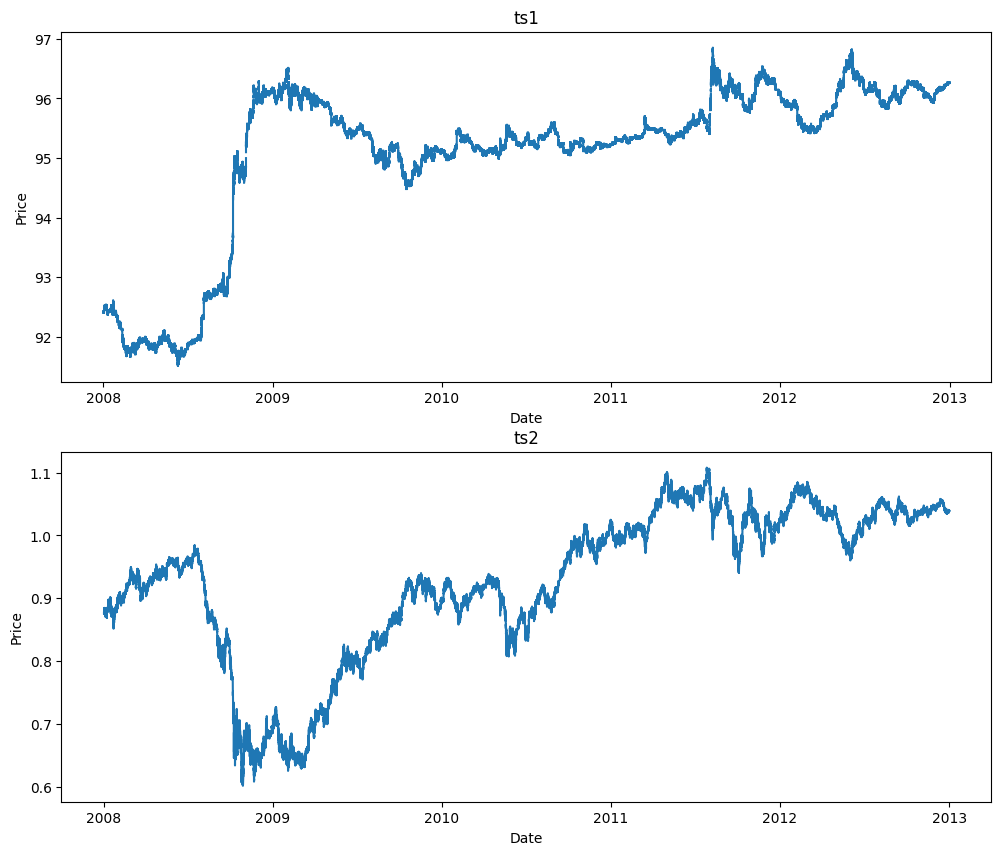

In [22]:
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']

plot_time_series(ts1, ts2, 'ts1', 'ts2')

Missing values in imputed ts1: 0
Missing values in imputed ts2: 0
Max missing range in imputed ts1: 0
Max missing range in imputed ts2: 0


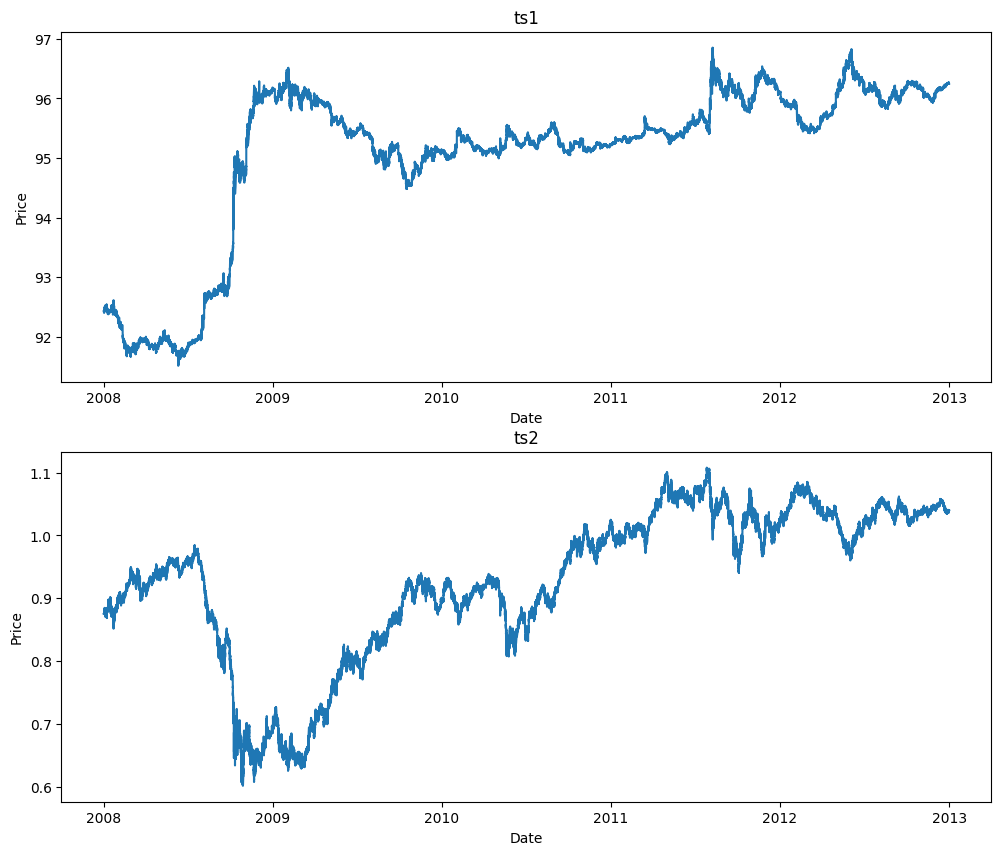

In [23]:
# Impute missing values in ts1 and ts2 using their respective maximum missing ranges
imputed_ts1 = impute_missing_values(ts1,long_gap_threshold = max_ts1)
imputed_ts2 = impute_missing_values(ts2, long_gap_threshold = max_ts2)

# Print the number of missing values in the imputed series
print(f"Missing values in imputed ts1: {imputed_ts1.isna().sum()}")
print(f"Missing values in imputed ts2: {imputed_ts2.isna().sum()}")

# Calculate the maximum missing range in the imputed series
max_imputed_ts1 = max_missing_range(imputed_ts1)
max_imputed_ts2 = max_missing_range(imputed_ts2)

# Print the maximum missing range in the imputed series
print(f"Max missing range in imputed ts1: {max_imputed_ts1}")
print(f"Max missing range in imputed ts2: {max_imputed_ts2}")
#PLot original data
# plot_time_series(ts1, ts2)

# Plot the imputed time series
plot_time_series(imputed_ts1, imputed_ts2)

The distriution of missing values is squeued heaviliy to very short intervals of time for both series meaning that there are not long streaks of missing data in the tiem series where the price is not known. 




Remove outliers by using obust scaling, but 

# 3. EDA
Perform exploratory statistical analysis on the data. Data is likely
distributed non parametrically so quartile tests for outliers will not be very effective. Results from EDA will hopefully inform how to deal with
outliers/noise missing values. High frequency data. 


Visualize the time series data (ts1 and ts2) to understand their behavior over time 

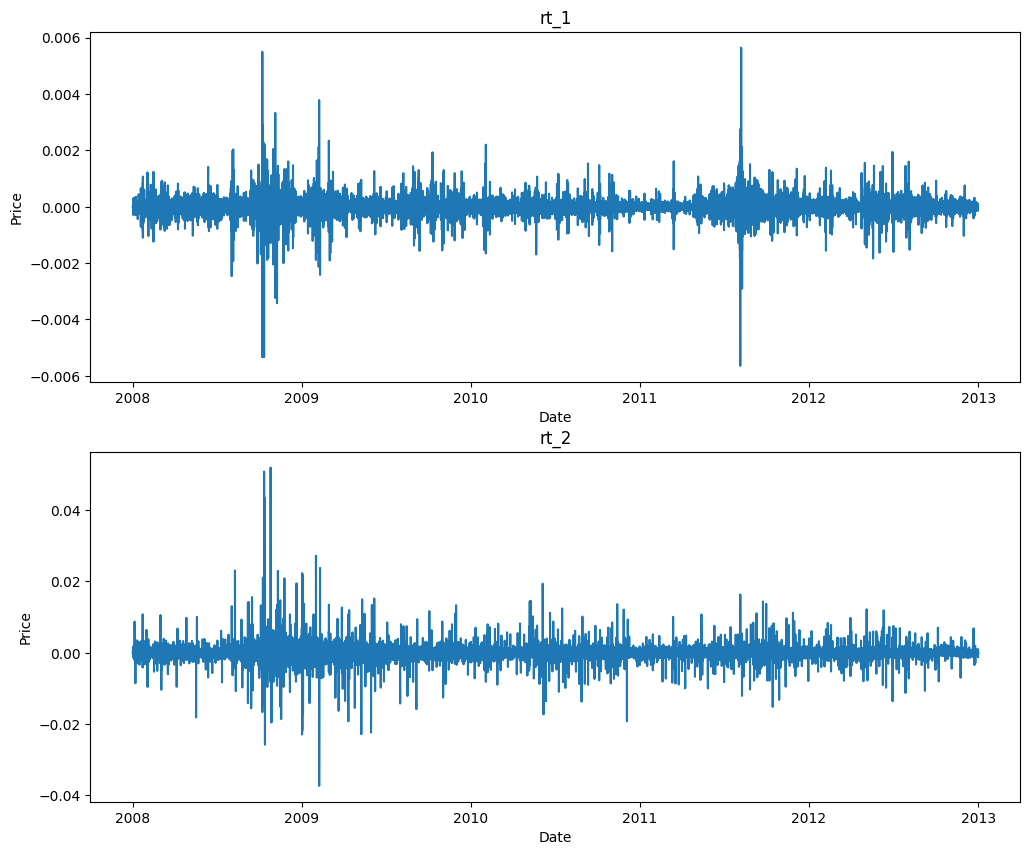

In [25]:
clean_df =  pd.concat([imputed_ts1, imputed_ts2], axis=1)
clean_df.to_csv('clean_df.csv')
# print(clean_df.isna().sum())
ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']
# def linear_interpolate_df(df):
#     df_interpolated = df.copy()
#     for col in df.columns:
#         df_interpolated[col] = df_interpolated[col].interpolate(method='linear')
#     return df_interpolated

# imp_df = raw_df.copy()
# for col in raw_df.columns:
#     print('1')
#     imp_col = impute_saturdays(imp_df[col])
#     print('2')
#     imp_df[col] = linear_interpolate_df(imp_col)
#     print(imp_df[col].isna().sum())


# rt = np.log(raw_df/raw_df.shift(1))
rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']
plot_time_series(rt_1, rt_2, 'rt_1', 'rt_2')

Decomposition and periodicity analysis:
- 	Decomposing the time series into trend, seasonal and residual components using additive or multiplicative models (e.g. seasonal_decompose function in Python)
- Used to identify periodicity or cycles within a time series, but also to explore other components such as long-term trends and irregular fluctuations

use stl method to decompoase since non normal with outiers and no linear
TL offers more flexibility and robustness, making it a better choice for time series with non-linear trends, changing seasonality, outliers, or missing values.

In [27]:
from statsmodels.tsa.seasonal import STL

def decompose(series,frequency, figsize=(20, 12)):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=figsize)

    # frequency_int = {
    #     '1 minute': 1,
    #     '5 minutes': 5,
    #     '10 minutes': 10,
    #     '30 minutes': 30,
    #     '1 hour': 60,
    #     '2 hours': 120,
    #     '3 hours': 180,
    #     '5 hours': 300,
    #     '12 hours': 720,
    #     '1 day': 1440,
    #     '2 days': 2880,
    #     '3 days': 4320,
    #     '5 days': 7200,
    #     '7 days': 10080,
    #     '30 days': 43200
    # }
    frequency_int = {
    'H': 24,  # hours in a day
    'D': 7,   # days in a week
    'W': 52,  # weeks in a year
    'M': 12,  # months in a year
    }
    decomposition = STL(series, period=frequency_int[frequency], robust = True)
    result = decomposition.fit()
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
    
    corr = np.corrcoef(series, trend)[0][1]
    print('Correlation between Price and Trend:', corr)
    ljung_resid = autocorrelation_test(residual)
    print('Ljung-Box test for Residuals:', ljung_resid)

    axs[0].plot(series)
    axs[0].margins(x=0)
    axs[0].set_ylabel('Observed')

    axs[1].plot(trend)
    axs[1].set_ylabel('Trend')
    axs[1].margins(x=0)

    axs[2].plot(seasonal)
    axs[2].set_ylabel('Seasonal')
    axs[2].margins(x=0)

    axs[3].scatter(series.index, residual, label=str(np.mean(abs(residual))))
    axs[3].set_ylabel('Residual')
    axs[3].margins(x=0)
    axs[3].legend()

    plt.show()

def plot_monthly_seasonal_subseries(series):
    # Resample the series to monthly data and extract the month names
    monthly_data = series.resample('M').mean()
    monthly_data.index = monthly_data.index.strftime('%B')
    
    # Create a DataFrame with the month names and prices
    seasonal_data = pd.DataFrame({'Month': monthly_data.index, 'Price': monthly_data.values})
    
    # Create a bar plot of the seasonal subseries
    seasonal_data.plot(x='Month', y='Price', kind='bar', figsize=(12, 6), legend=False)
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.title('Seasonal Subseries Plot')
    plt.show()
    
def plot_custom_seasonal_subseries(data, freq):
    data = data.to_period(freq)  # Convert the index to the desired frequency
    seasonal_groups = data.groupby(data.index).groups
    n_seasons = len(seasonal_groups)
    
    fig, axs = plt.subplots(nrows=n_seasons, figsize=(12, n_seasons*4))

    for i, (season, idx) in enumerate(seasonal_groups.items()):
        season_data = data.loc[list(idx)]
        season_data.index = season_data.index.strftime('%Y-%m-%d')
        axs[i].plot(season_data)
        axs[i].set_title(str(season))
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Price')

    plt.tight_layout()
    plt.show()

In [28]:
def analyse_seasonality(series, title,freq_list=['H', 'D', 'W', 'M']):
    
    # Loop over each frequency
    for freq in freq_list:
        # Resample original data
        resampled_data = series.resample(freq).mean()
        print(len(resampled_data))
        print('Resampled data for frequency:', freq)
        # Perform seasonal decomposition
        decompose(resampled_data, freq)

43849
Resampled data for frequency: H
Correlation between Price and Trend: 0.9996736884969083
Ljung-Box test for Residuals: 1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
38395    0.0
38396    0.0
38397    0.0
38398    0.0
38399    0.0
Name: lb_pvalue, Length: 38399, dtype: float64


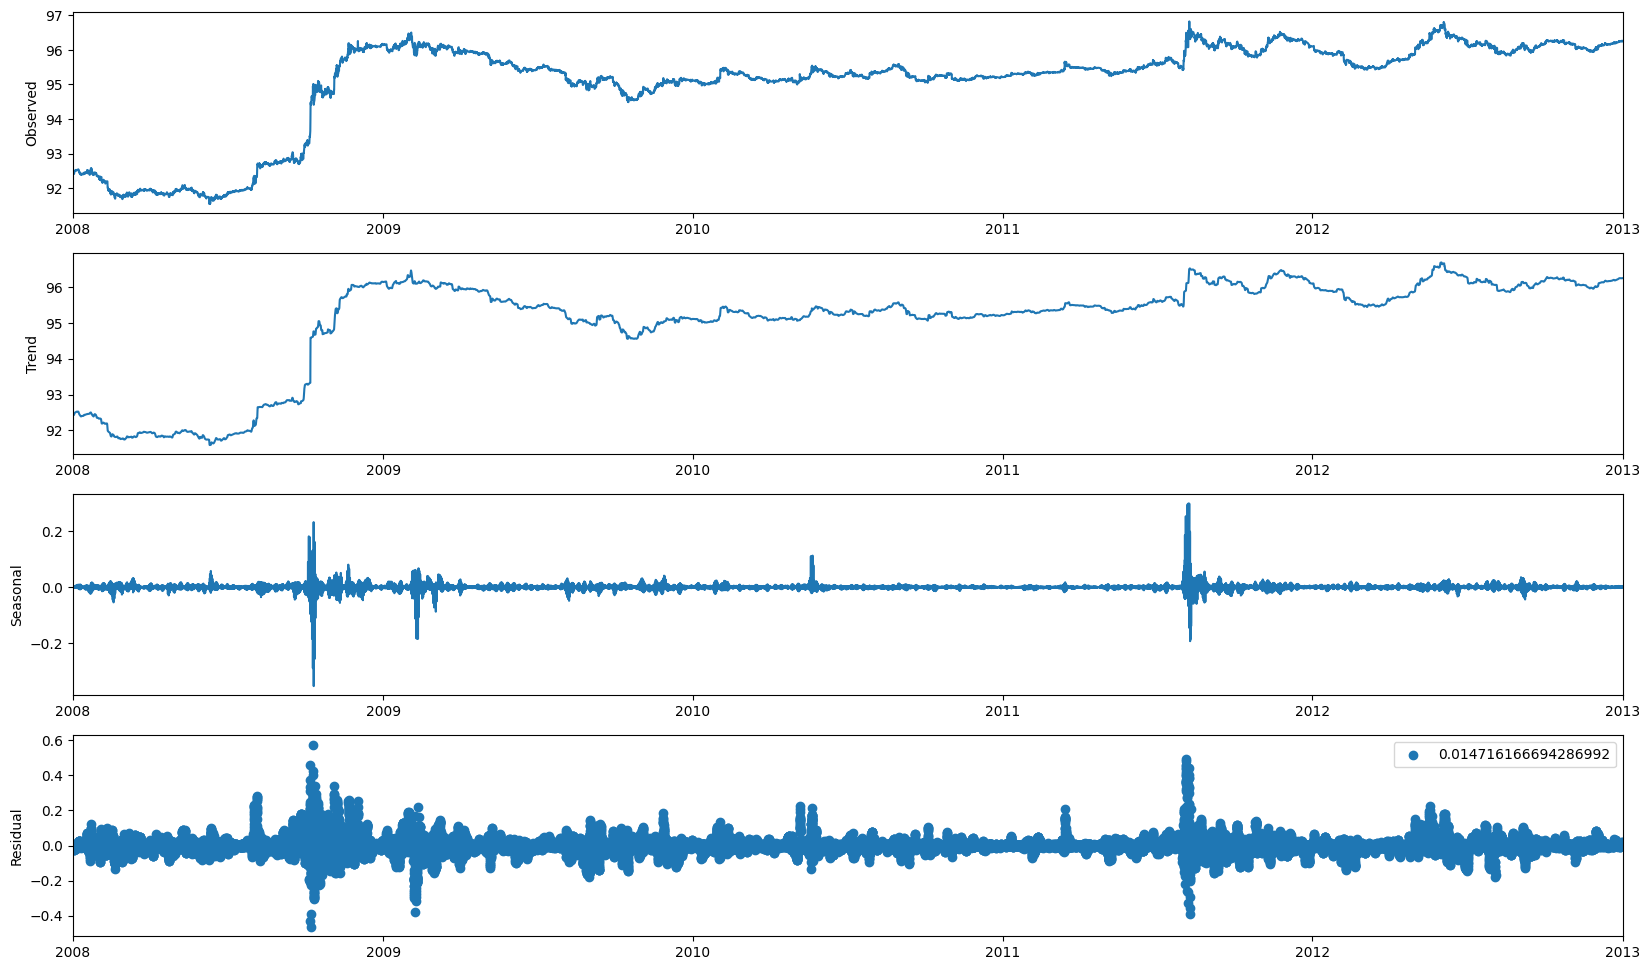

1828
Resampled data for frequency: D
Correlation between Price and Trend: 0.9990496544718067
Ljung-Box test for Residuals: 1       6.710803e-72
2       7.732405e-90
3       3.067730e-98
4       2.946460e-99
5       2.878414e-99
           ...      
143    3.917044e-126
144    8.833096e-127
145    4.703012e-128
146    3.749419e-128
147    3.604339e-128
Name: lb_pvalue, Length: 147, dtype: float64


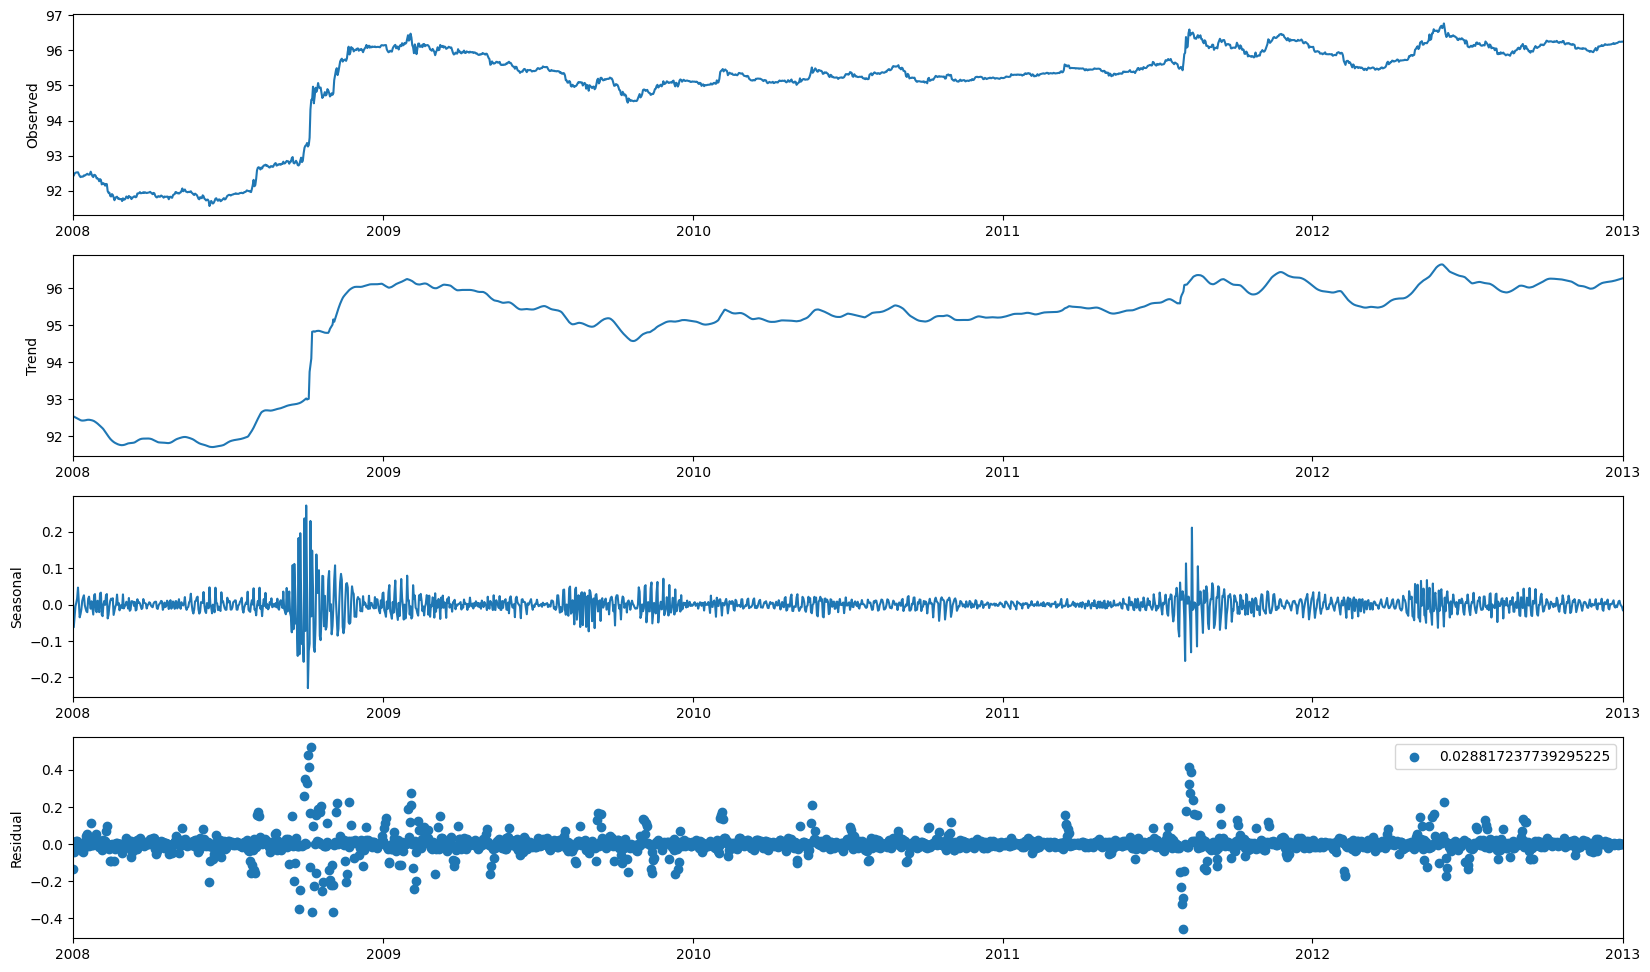

262
Resampled data for frequency: W
Correlation between Price and Trend: 0.8266779487916374
Ljung-Box test for Residuals: 1       1.739773e-50
2       1.490765e-90
3      1.458661e-123
4      3.306451e-155
5      6.459162e-184
           ...      
198     0.000000e+00
199     0.000000e+00
200     0.000000e+00
201     0.000000e+00
202     0.000000e+00
Name: lb_pvalue, Length: 202, dtype: float64


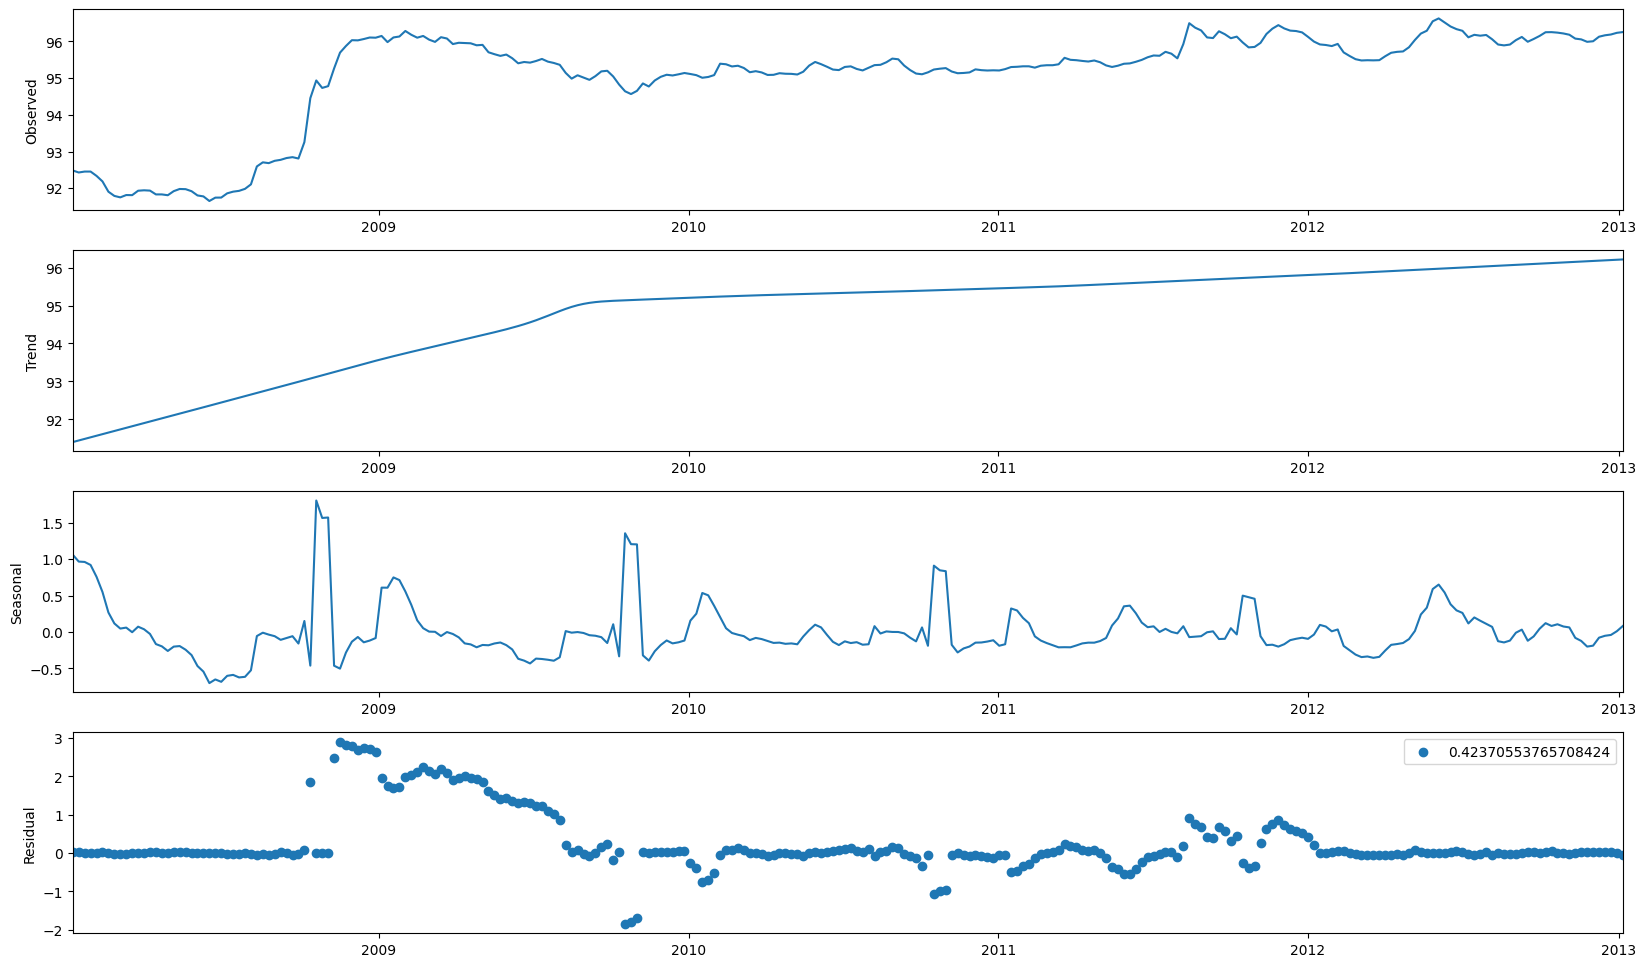

61
Resampled data for frequency: M
Correlation between Price and Trend: 0.8353758128930284
Ljung-Box test for Residuals: 1     1.239451e-08
2     9.125855e-12
3     4.659958e-13
4     6.766244e-13
5     2.471365e-12
6     8.840814e-12
7     1.427026e-11
8     5.549931e-12
9     1.416964e-12
10    2.037962e-13
11    1.813474e-13
Name: lb_pvalue, dtype: float64


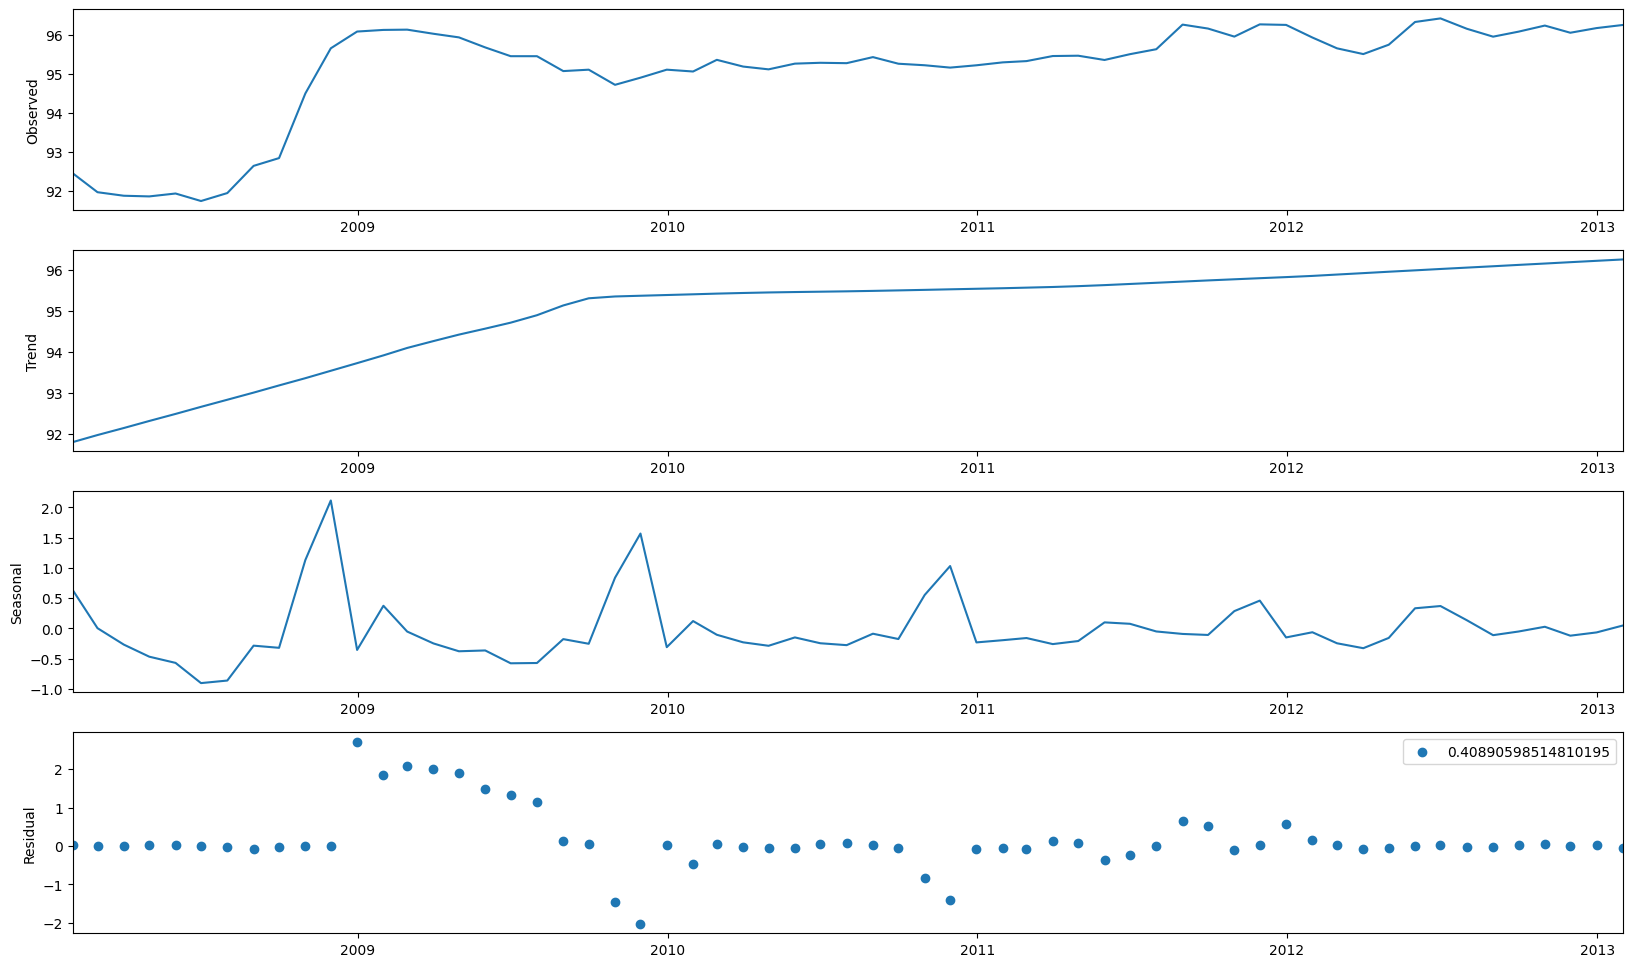

In [29]:
analyse_seasonality(ts_1_imp, 'ts1', freq_list=['H', 'D', 'W', 'M'])


Weakenning byt strong correlation between price and trend. So there is evidence of trend in all frequencies.
Possible seasonality likely only in the monthly time frame where there is an increase at teh start of the year.
noise is random up to onthly time frame

Residuals are strongly corelated so suggests that there is underlying structure that is not captured by seasonal decomposition. 


43849
Resampled data for frequency: H
Correlation between Price and Trend: 0.999490609174061
Ljung-Box test for Residuals: 1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
36209    0.0
36210    0.0
36211    0.0
36212    0.0
36213    0.0
Name: lb_pvalue, Length: 36213, dtype: float64


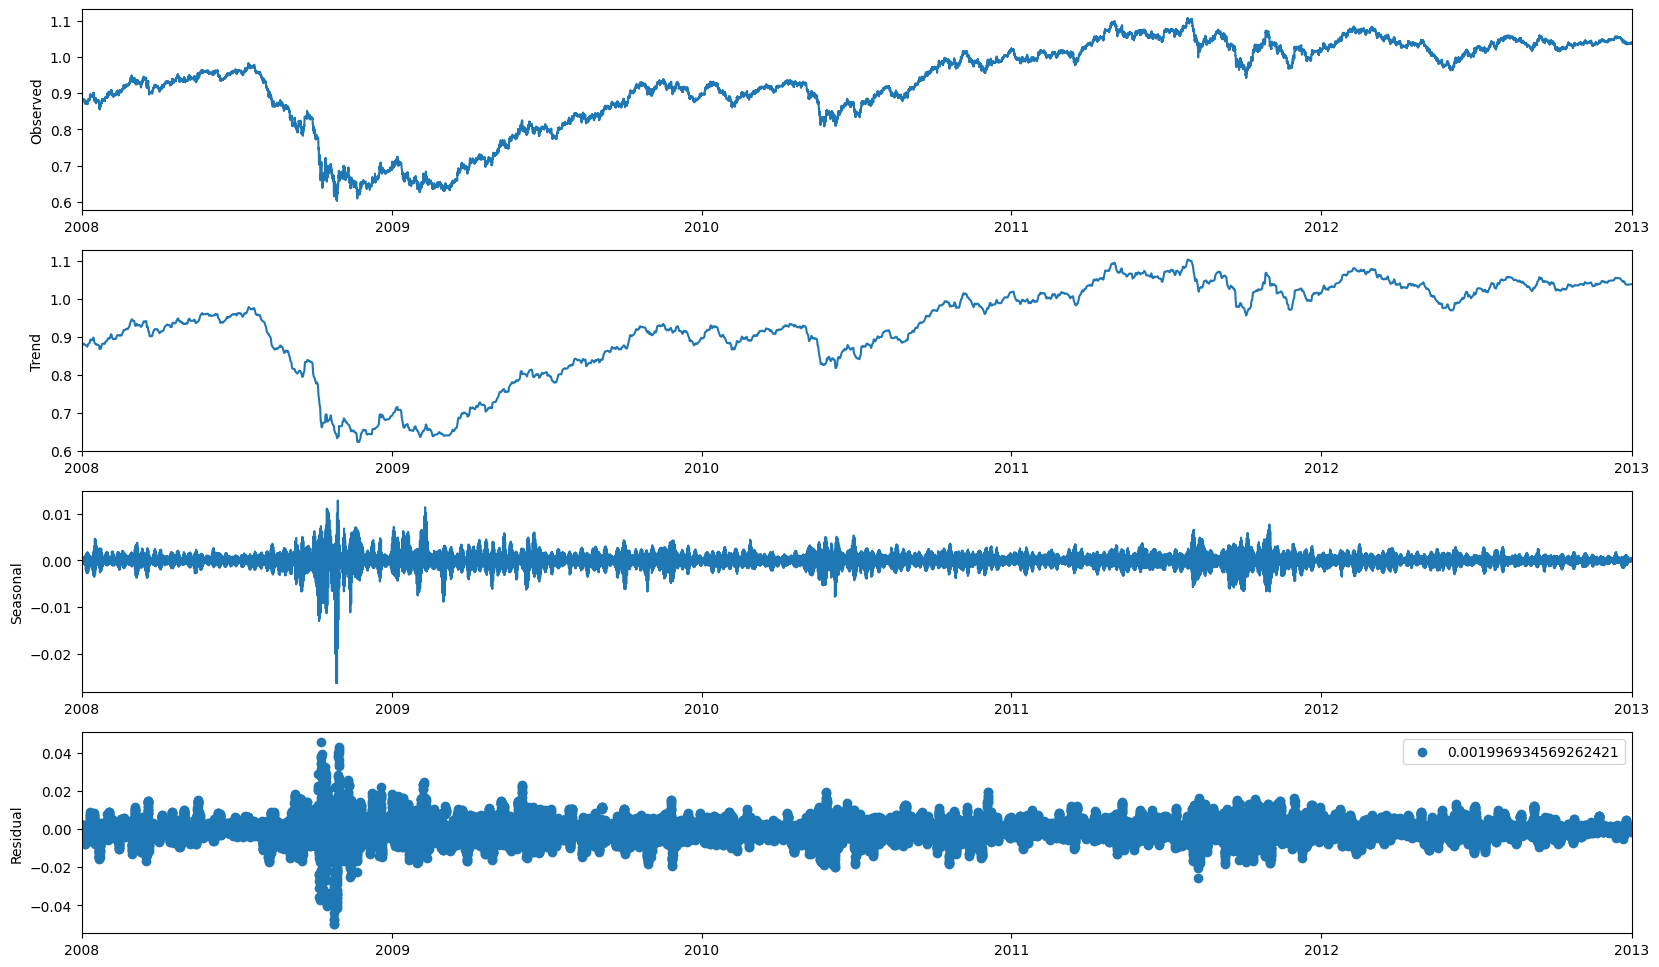

1828
Resampled data for frequency: D
Correlation between Price and Trend: 0.9979701711481833
Ljung-Box test for Residuals: 1       8.025351e-171
2       7.119951e-237
3       3.374236e-266
4       3.952974e-270
5       6.361680e-269
            ...      
1162     0.000000e+00
1163     0.000000e+00
1164     0.000000e+00
1165     0.000000e+00
1166     0.000000e+00
Name: lb_pvalue, Length: 1166, dtype: float64


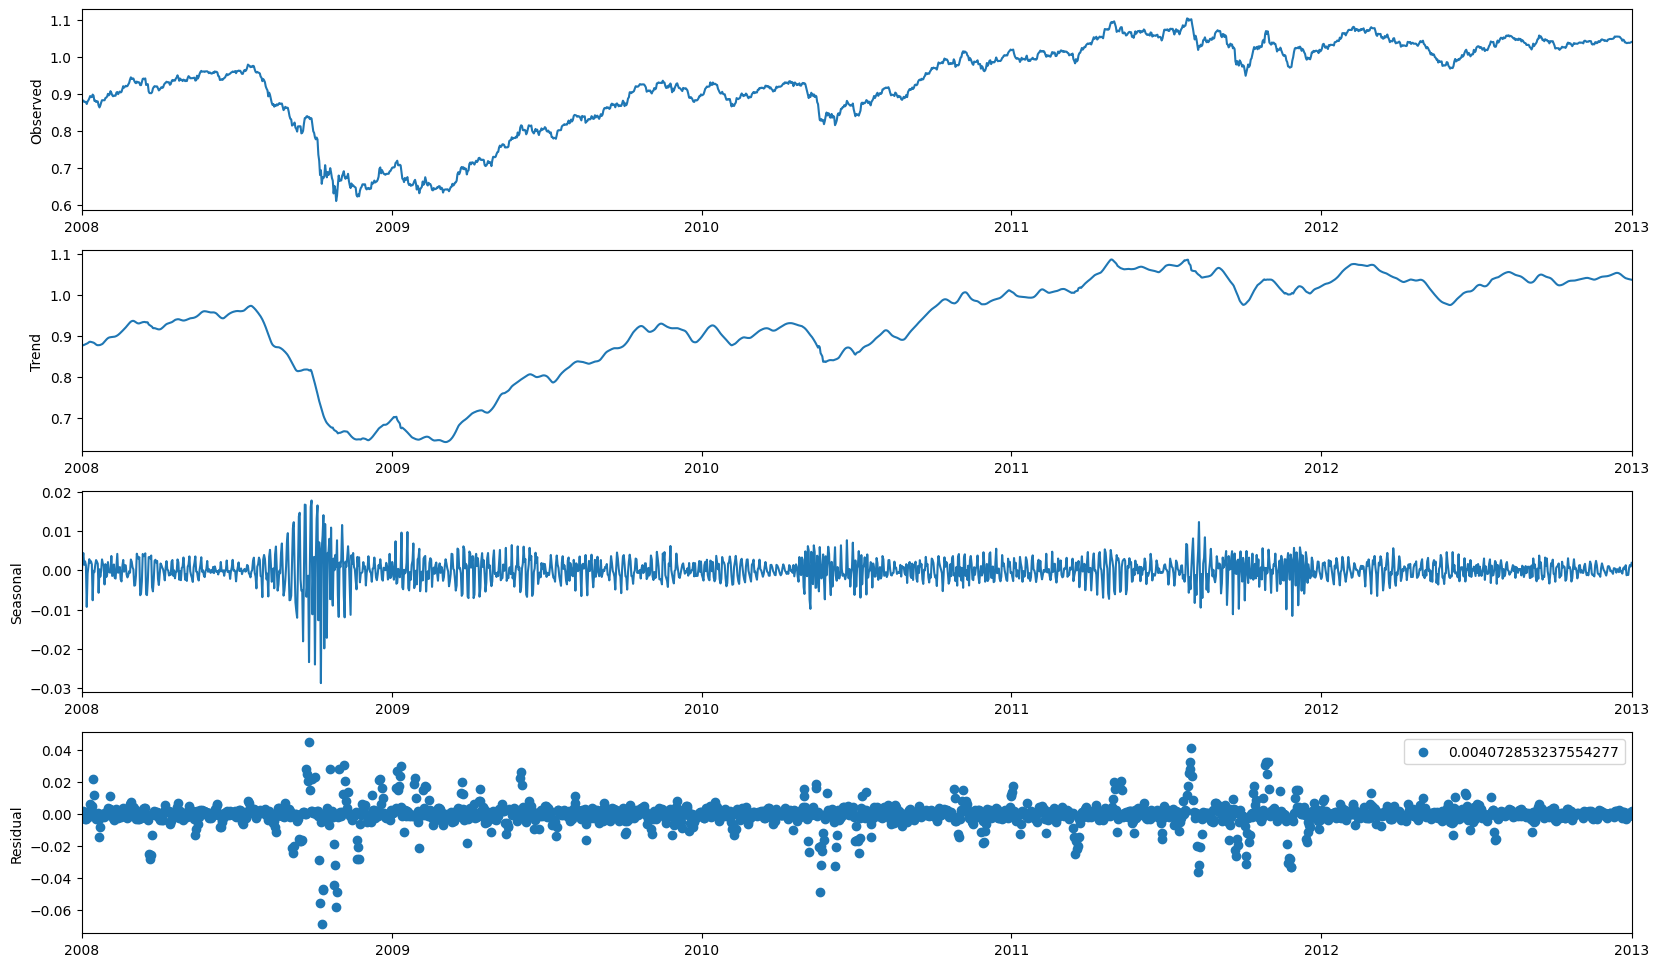

262
Resampled data for frequency: W
Correlation between Price and Trend: 0.8171025108286337
Ljung-Box test for Residuals: 1       2.235873e-43
2       5.943930e-78
3      1.190029e-107
4      7.222583e-138
5      3.649539e-161
           ...      
124     0.000000e+00
125     0.000000e+00
126     0.000000e+00
127     0.000000e+00
128     0.000000e+00
Name: lb_pvalue, Length: 128, dtype: float64


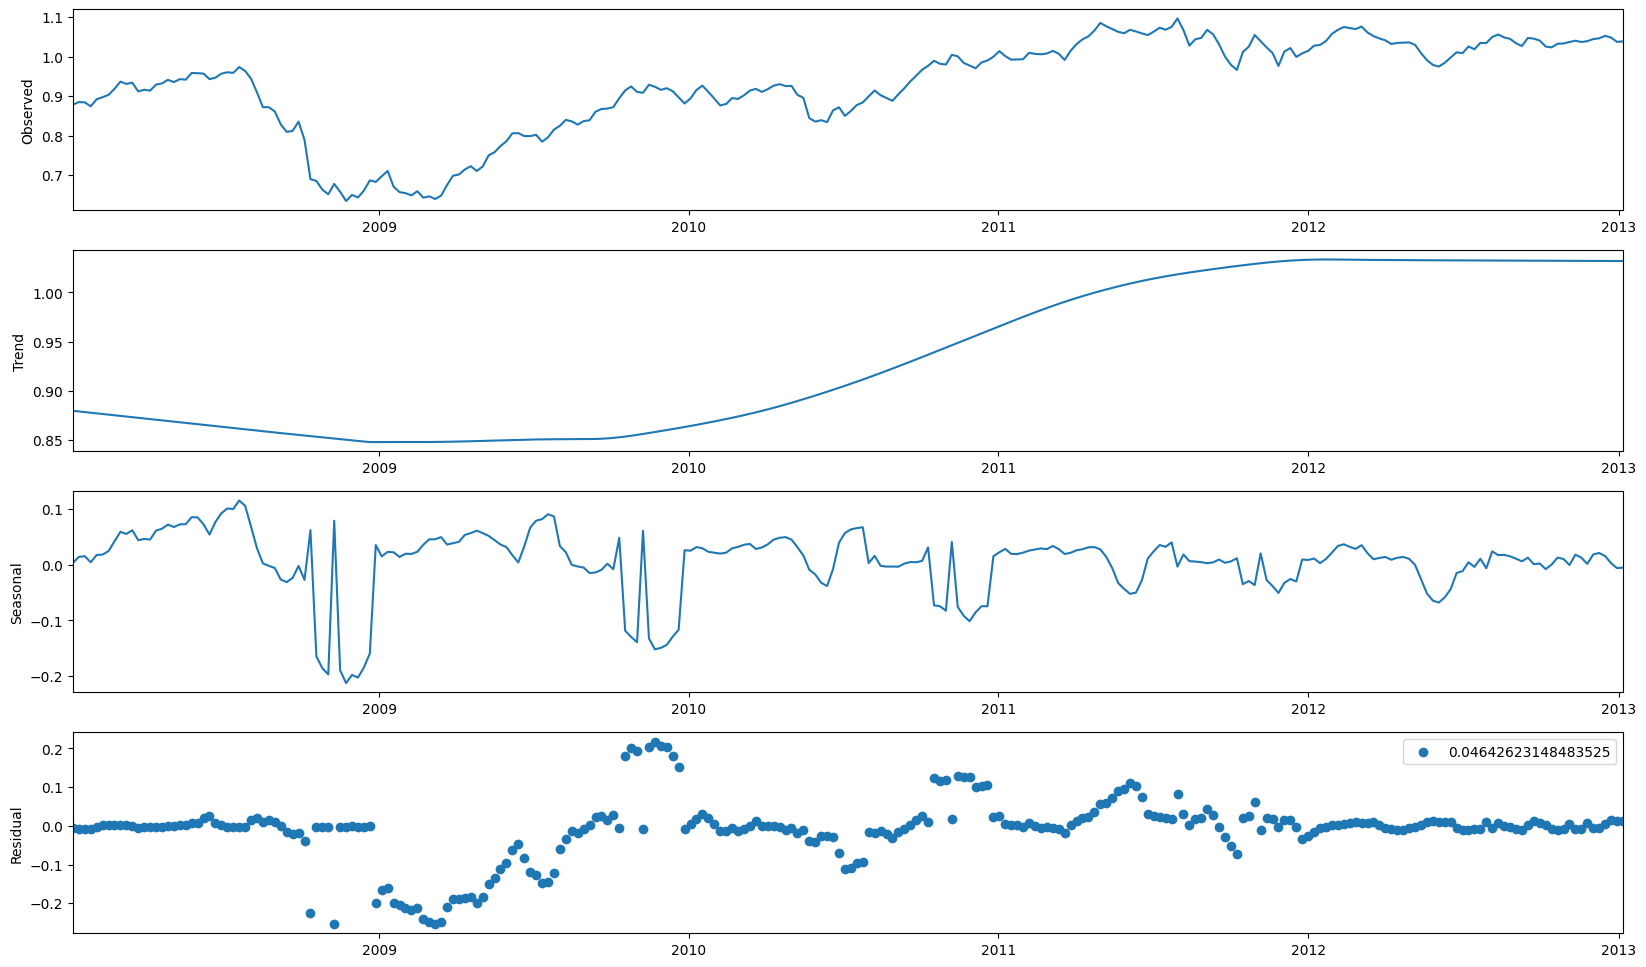

61
Resampled data for frequency: M
Correlation between Price and Trend: 0.8149782321598528
Ljung-Box test for Residuals: 1     2.681171e-11
2     2.415394e-14
3     2.513686e-14
4     1.118389e-13
5     4.720912e-13
6     1.059430e-12
7     3.594021e-13
8     1.914589e-14
9     1.562352e-15
10    2.294725e-15
11    6.362383e-15
12    4.237620e-15
13    2.950739e-15
Name: lb_pvalue, dtype: float64


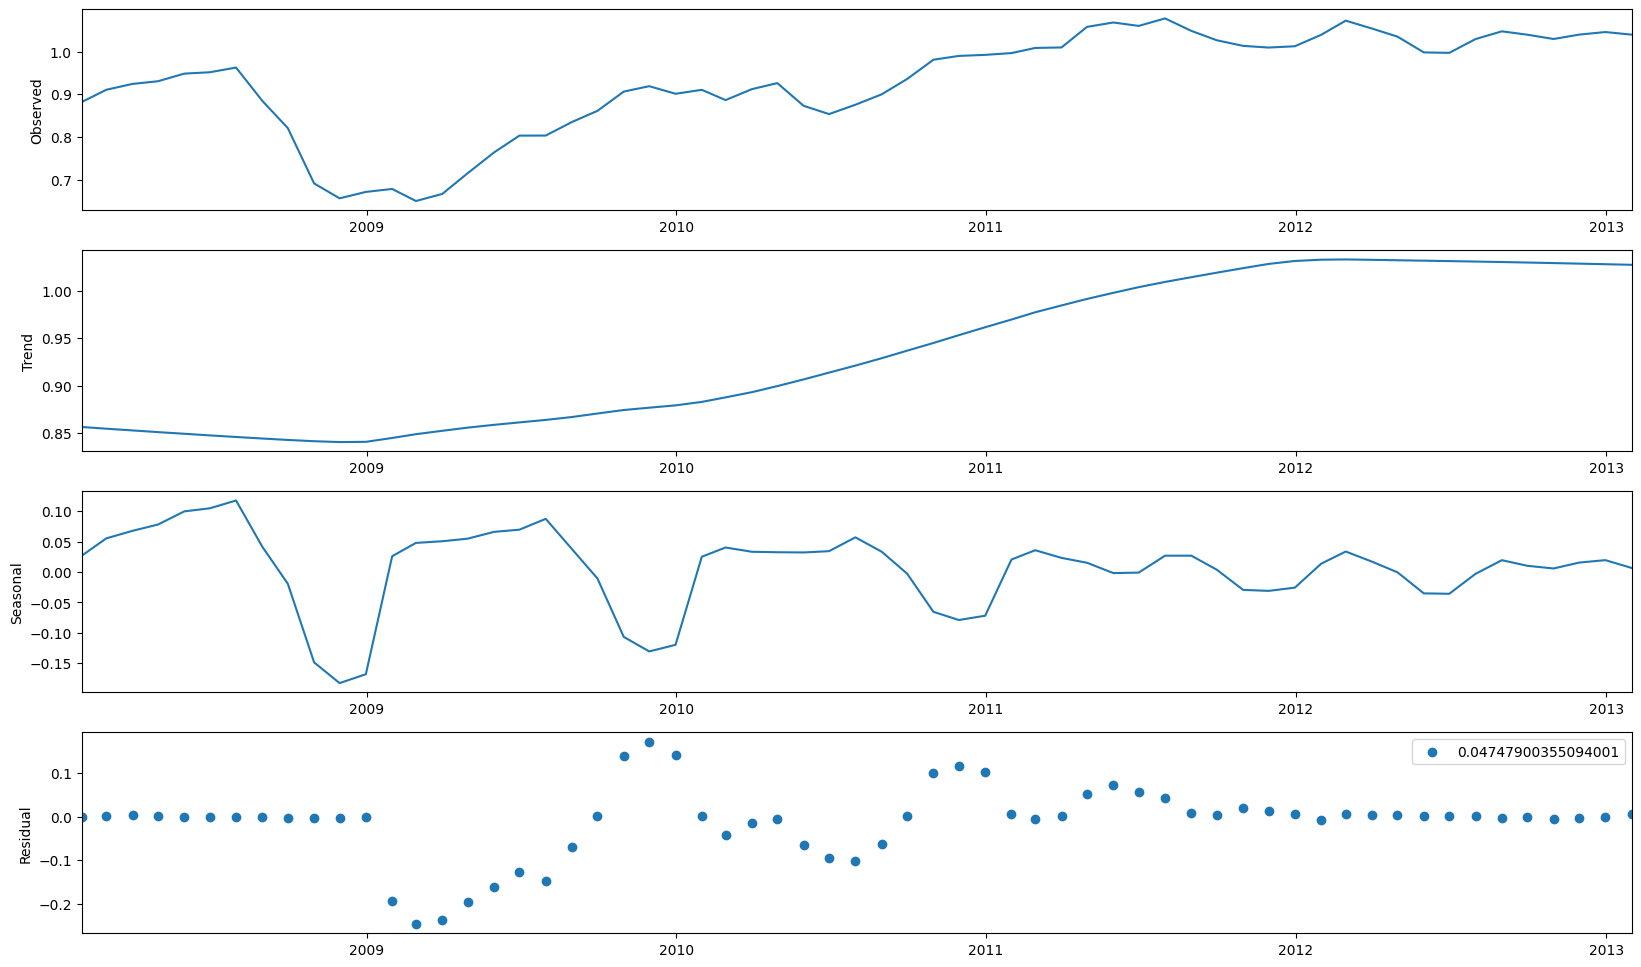

In [30]:
analyse_seasonality(ts_2_imp, 'ts1', freq_list=['H', 'D', 'W', 'M'])



More ikely to be seasonal in high time frame
but noise and no seaosnlity in lower times
ctrong upwards trend in all time frames

Residuals are strongly corelated so suggests that there is underlying structure that is not captured by seasonal decomposition. 


Both exhibi t a yearly seasonality of a rise in price and fall in price respectively. 

BOth exhibit largely nonlinear trends

In [31]:
# def plot_monthly_seasonal_subseries(series):
#     # Resample the series to monthly data and extract the month names
#     monthly_data = series.resample('M').mean()
#     monthly_data.index = pd.to_datetime(monthly_data.index)
    
#     # Create a DataFrame with the seasonal subseries for each month
#     seasonal_data = pd.DataFrame(index=range(1, 13), columns=monthly_data.index.unique())
#     for month, group in monthly_data.groupby(monthly_data.index.month):
#         seasonal_data.loc[month, group.index] = group.values
        
#     # Plot the seasonal subseries with overlaid months
#     fig, ax = plt.subplots(figsize=(10, 6))
#     seasonal_data.T.plot(ax=ax)
#     ax.set_xlabel('Month')
#     ax.set_ylabel('Price')
#     ax.set_title('Seasonal Subseries Plot')
#     ax.legend()
#     plt.show()

# Analyse seasonality of the original data
# Analys subseries of the original data, monthly and quarterly 
# plot_monthly_seasonal_subseries(ts_1_imp)
# plot_monthly_seasonal_subseries(ts_2_imp)
# plot_seasonal_subseries(ts_1_imp, 'Q')
# plot_seasonal_subseries(ts_2_imp, 'Q')

Seasonlity analysis: consider different resampled data periods and test for cyclicity or seasonality

- - Focuses specifically on identifying and quantifying the seasonal component of a time series
-  autocorrelation analysis, 
-  seasonal decomposition, 
-  spectral analysis


In [10]:
# Spectral Analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def plot_power_spectral_density(ts, title):
    freqs, psd = welch(ts)
    plt.plot(freqs, psd)
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.title(title)
    plt.show()

def plot_lomb_scargle_periodogram(ts, title):
    time = np.arange(len(ts))
    ls = LombScargle(time, ts)
    freq, power = ls.autopower()
    plt.plot(freq, power)
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title(title)
    plt.show()
    

def plot_acf_pacf(data, max_lags=None):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot ACF
    plot_acf(data, lags=max_lags, ax=axes[0], alpha=0.05)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    axes[0].set_ylabel('ACF')
    
    # Plot PACF
    plot_pacf(data, lags=max_lags, ax=axes[1], alpha=0.05)
    axes[1].axhline(y=0, linestyle='--', color='gray')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('PACF')
    
    plt.show()

def autocorrelation_test(series):
    stats = sm.stats.acorr_ljungbox(series, auto_lag = True)
    return stats['lb_pvalue']

1828
Resampled data for frequency: D


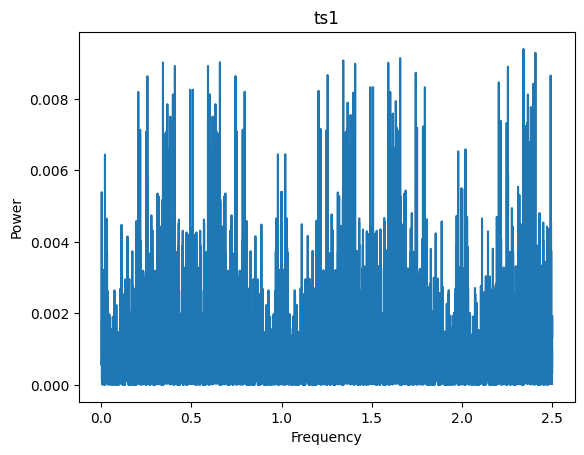

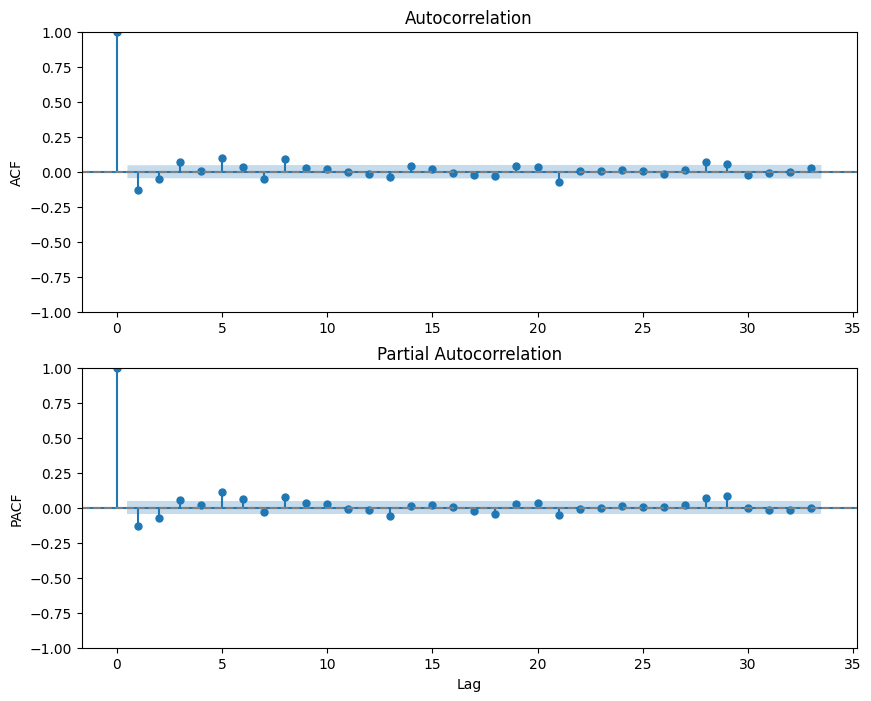

1     2.749358e-08
2     1.209098e-08
3     5.252480e-10
4     2.206219e-09
5     1.977099e-12
6     2.981798e-12
7     1.183828e-12
8     3.668346e-15
9     7.754188e-15
10    1.939658e-14
11    5.939334e-14
12    1.494105e-13
13    1.491725e-13
14    8.296106e-14
15    1.768018e-13
16    4.318002e-13
17    7.293159e-13
18    7.302109e-13
19    4.877019e-13
20    4.842432e-13
21    1.316254e-14
22    3.113551e-14
23    6.863064e-14
24    1.315768e-13
25    2.803805e-13
26    4.841629e-13
27    8.935703e-13
28    5.880794e-14
29    1.161811e-14
Name: lb_pvalue, dtype: float64
262
Resampled data for frequency: W


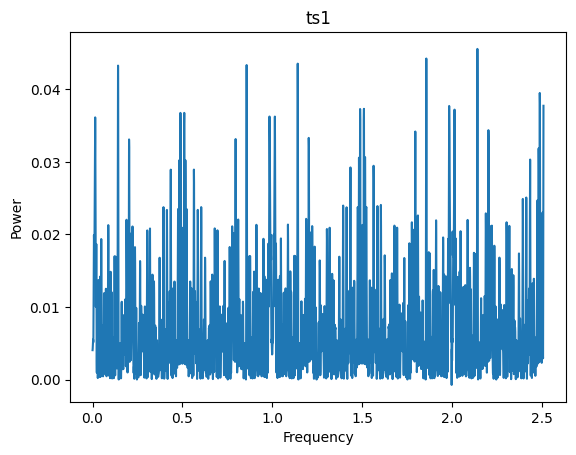

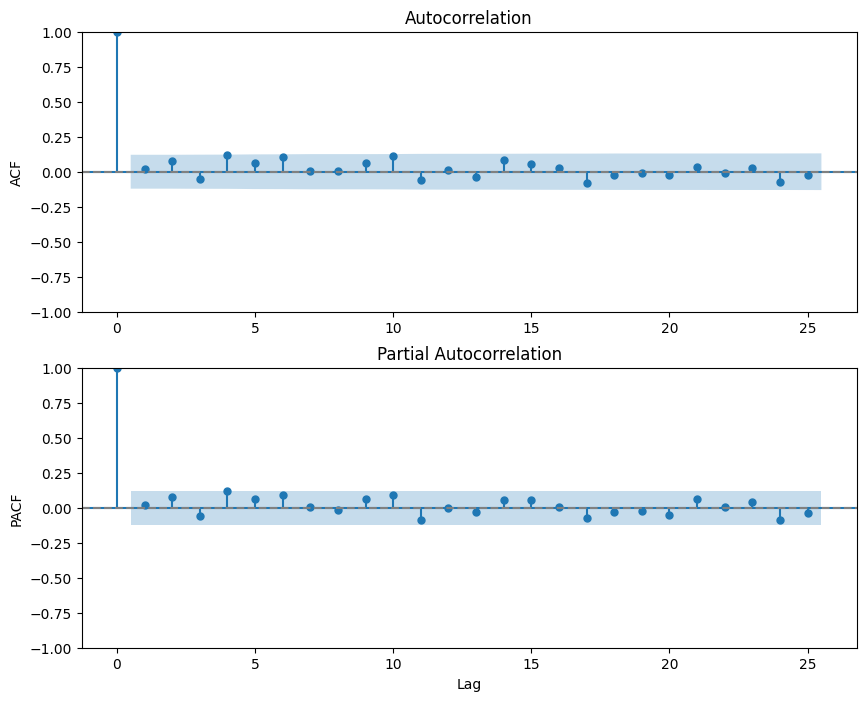

ValueError: zero-size array to reduction operation maximum which has no identity

In [11]:
# Analyze ACF and PACF plots
# plot_acf_pacf(resampled_data)
#using log returns 

def spectral_analysis(series, title, freq_list=['H', 'D', 'W', 'M']):
    # Loop over each frequency
    for freq in freq_list:
        # Resample original data
        resampled_data = series.resample(freq).mean()
        print(len(resampled_data))
        print('Resampled data for frequency:', freq)
        # Analyze power spectral density and Lomb-Scargle periodogram
        # plot_power_spectral_density(resampled_data, title)
        plot_lomb_scargle_periodogram(resampled_data, title)
        # Analyze ACF and PACF plots
        plot_acf_pacf(resampled_data)
        print(autocorrelation_test(resampled_data))

spectral_analysis(rt_1, 'ts1', freq_list=['D', 'W', 'M'])



1828
Resampled data for frequency: D


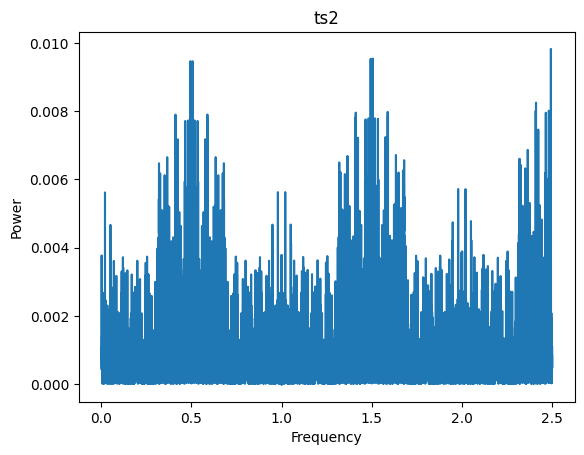

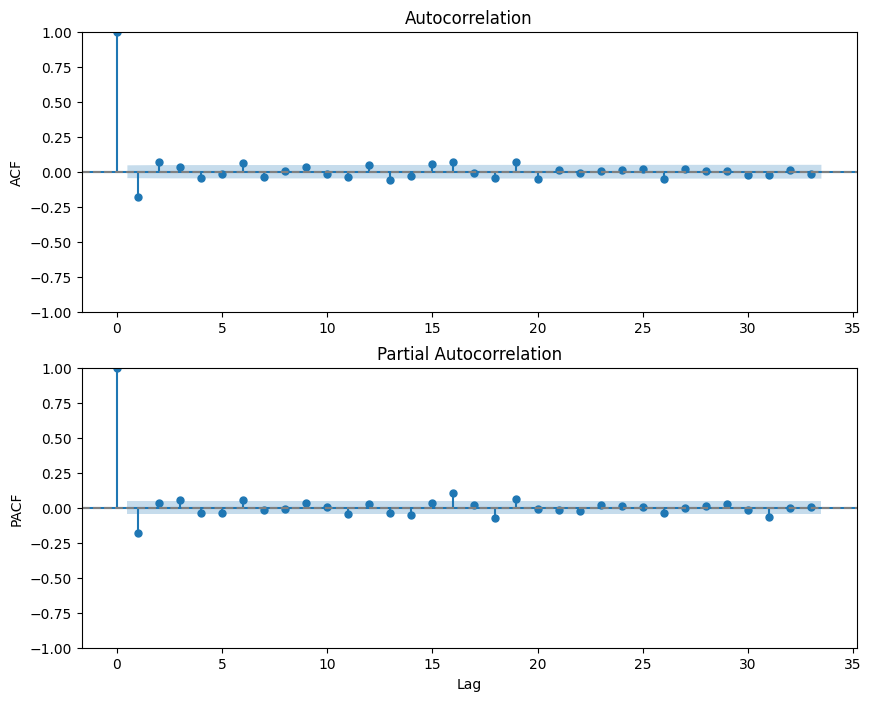

1     4.150910e-15
2     6.573373e-16
3     1.761558e-15
4     1.473092e-15
5     5.756319e-15
6     1.096230e-15
7     1.107147e-15
8     3.929348e-15
9     4.799244e-15
10    1.256842e-14
11    1.115679e-14
12    6.313438e-15
13    9.689807e-16
14    1.487831e-15
15    4.728139e-16
16    2.411812e-17
17    6.049331e-17
18    3.537884e-17
19    1.699973e-18
20    5.943527e-19
Name: lb_pvalue, dtype: float64
262
Resampled data for frequency: W


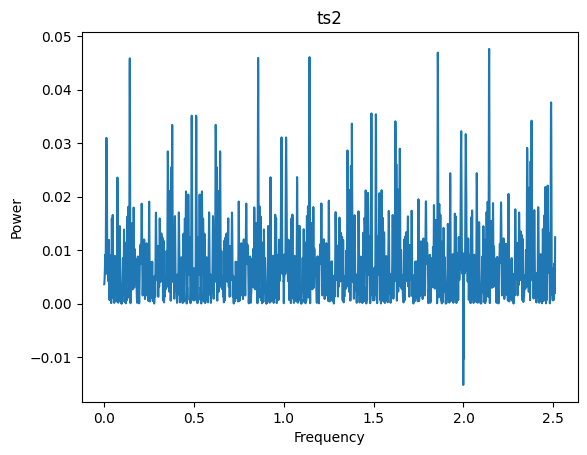

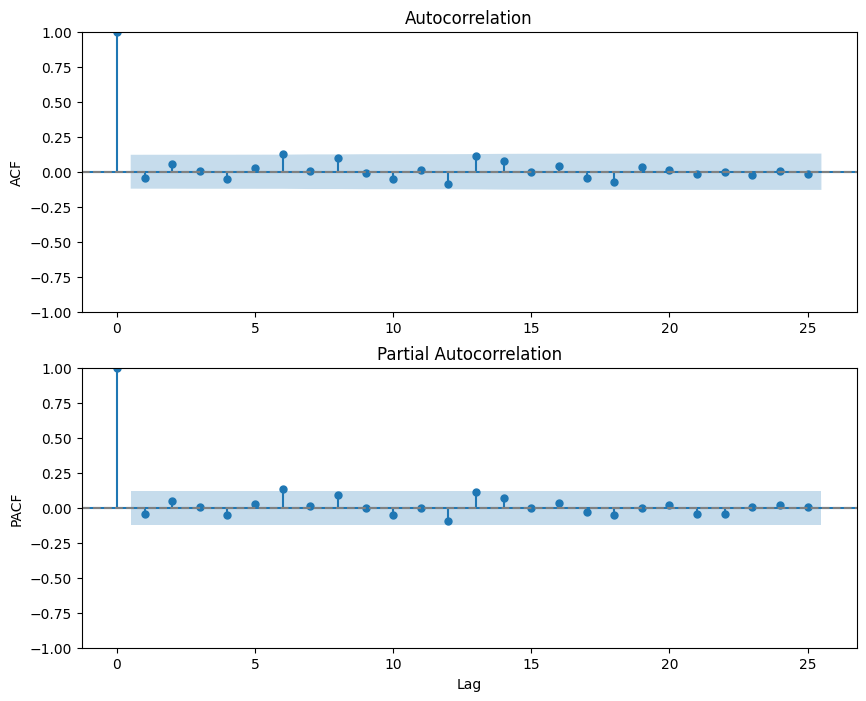

ValueError: zero-size array to reduction operation maximum which has no identity

In [12]:
spectral_analysis(rt_2, 'ts2', freq_list=['D', 'W', 'M'])

Both show some seasonality or perids apearring in the intra day timescale and daily. 2 hours, 16 hours, 48 hours

Significant lags in the hourly and daily  freqiencies indicates serial correlation. 

Cyclicity analysis: no resampling for period
- Focuses on identifying cyclical patterns within a time series that are not necessarily periodic or seasonal
  - autocorrelation analysis, pcf
  - spectral analysis
  - Hodrick-Prescott filter: a smoothing method that separates a time series into a trend component and a cyclical component.
  - Moving averages: compute the moving average of a time series to identify cyclical patterns.

Best lamb value: 81


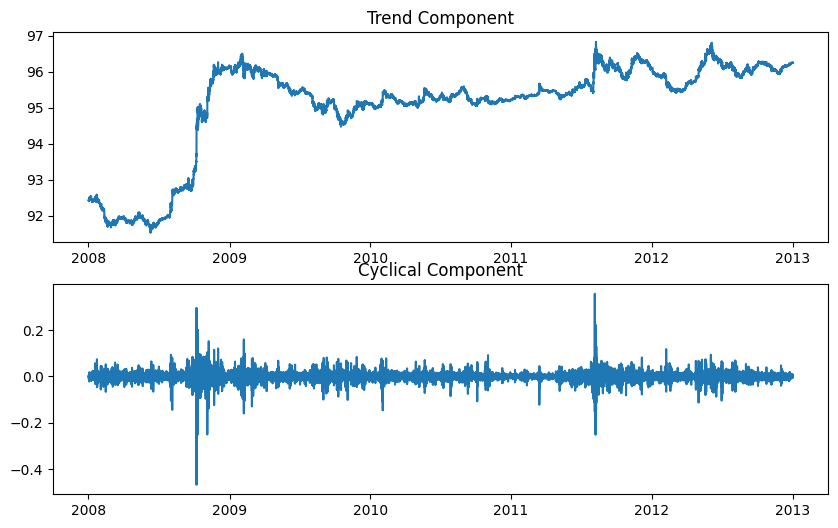

In [63]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data = ts_1_imp
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, shuffle=False)

# Define a range of lamb values to try
lamb_values = np.arange(1, 100, 10)

# Compute the root mean squared error for each lamb value on the validation set
rmse_values = []
for lamb in lamb_values:
    _, cycle = hpfilter(train_data, lamb=lamb)
    pred_cycle = np.repeat(cycle.mean(), len(val_data))
    rmse = np.sqrt(mean_squared_error(val_data, pred_cycle))
    rmse_values.append(rmse)

# Find the lamb value with the lowest RMSE on the validation set
best_lamb = min(zip(lamb_values, rmse_values), key=lambda x: x[1])[0]
print('Best lamb value:', best_lamb)
# Plot the HP filter with the best lamb value
cycle, trend = hpfilter(data, lamb=best_lamb)
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
axes[0].plot(trend)
axes[0].set_title('Trend Component')
axes[1].plot(cycle)
axes[1].set_title('Cyclical Component')
plt.show()

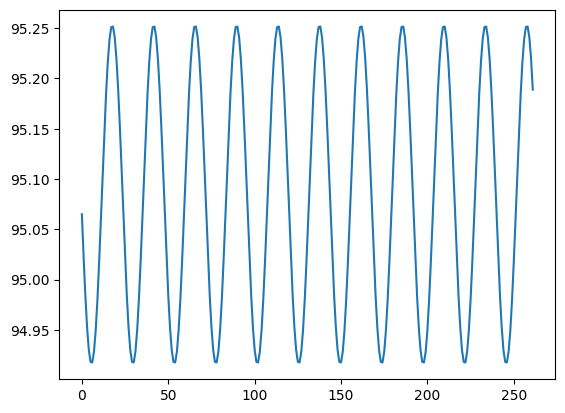

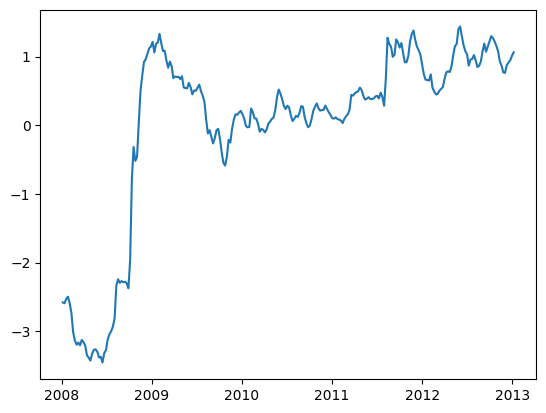

In [45]:
def cyclicity_test(series, period=24):
    x = np.arange(0, len(series))
    sin = np.sin(2 * np.pi * x / period)
    cos = np.cos(2 * np.pi * x / period)
    X = np.column_stack((np.ones(len(x)), sin, cos))
    beta = np.linalg.lstsq(X, series, rcond=None)[0]
    fitted = beta[0] + beta[1] * sin + beta[2] * cos
    resids = series - fitted
    result = {'fitted': fitted, 'resids': resids}
    return result

r= cyclicity_test(ts_1_imp.resample('W').mean(), period=24)
plt.plot(r['fitted'])
plt.show()
plt.plot(r['resids'])

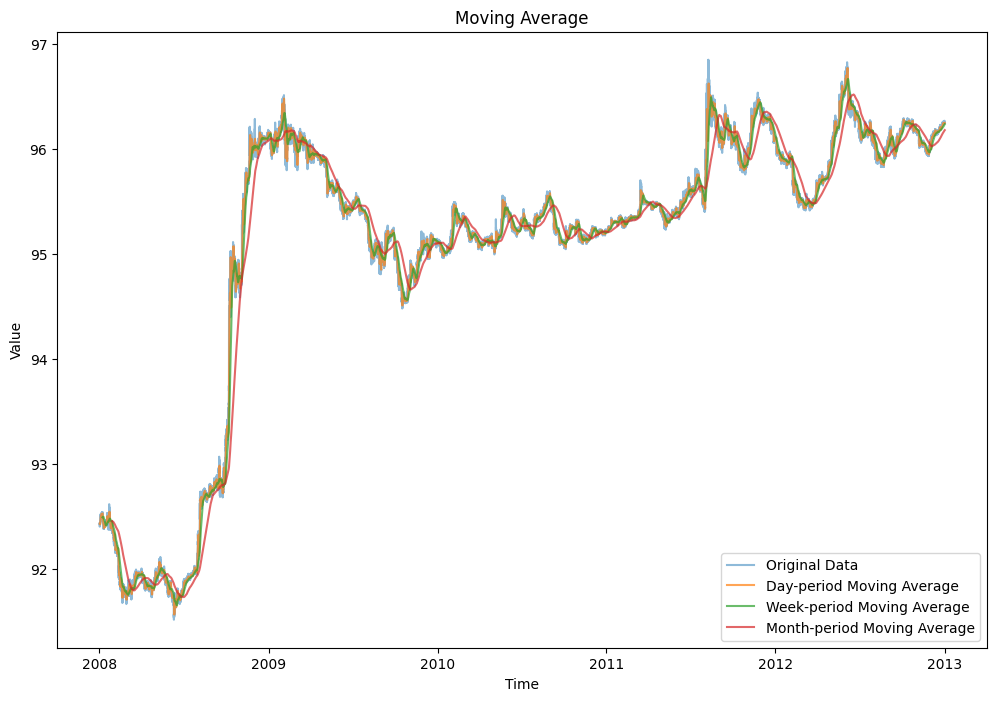

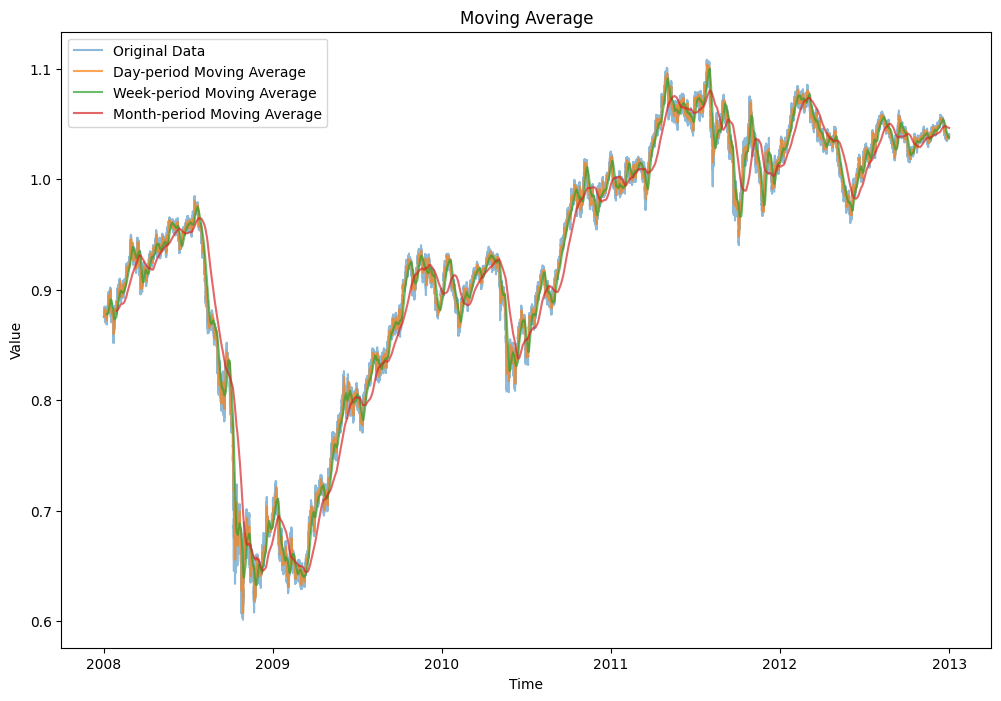

In [72]:
def plot_moving_average(data, window_sizes):
    plt.figure(figsize=(12,8))
    plt.plot(data, alpha=0.5, label='Original Data')
    
    for label, window_size in window_sizes.items():
        moving_average = data.rolling(window=window_size).mean()
        plt.plot(moving_average, alpha=0.7, label=f'{label}-period Moving Average')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Moving Average')
    plt.legend()
    plt.show()


# plot_lomb_scargle_periodogram(rt_1, 'ts1')
# plot_acf_pacf(rt_1)
# plot_lomb_scargle_periodogram(rt_2, 'ts2')
# plot_acf_pacf(rt_2)
window_sizes = {'Day': 720, 'Week': 5040, 'Month': 20160}
plot_moving_average(ts_1_imp, window_sizes)
plot_moving_average(ts_2_imp, window_sizes)

Genreally for both series te movingaverage shows that there is an upwards trends, but there is no clear seasonality or cyclicity around the moving average, but there is consistent fluctuation/volatility above and below the moving average. 

Data Transformation a. Calculate log returns (r) for each time series using the formula: r = log(p(t)/p(t-1)) b. Visualize the log returns for ts1 and ts2

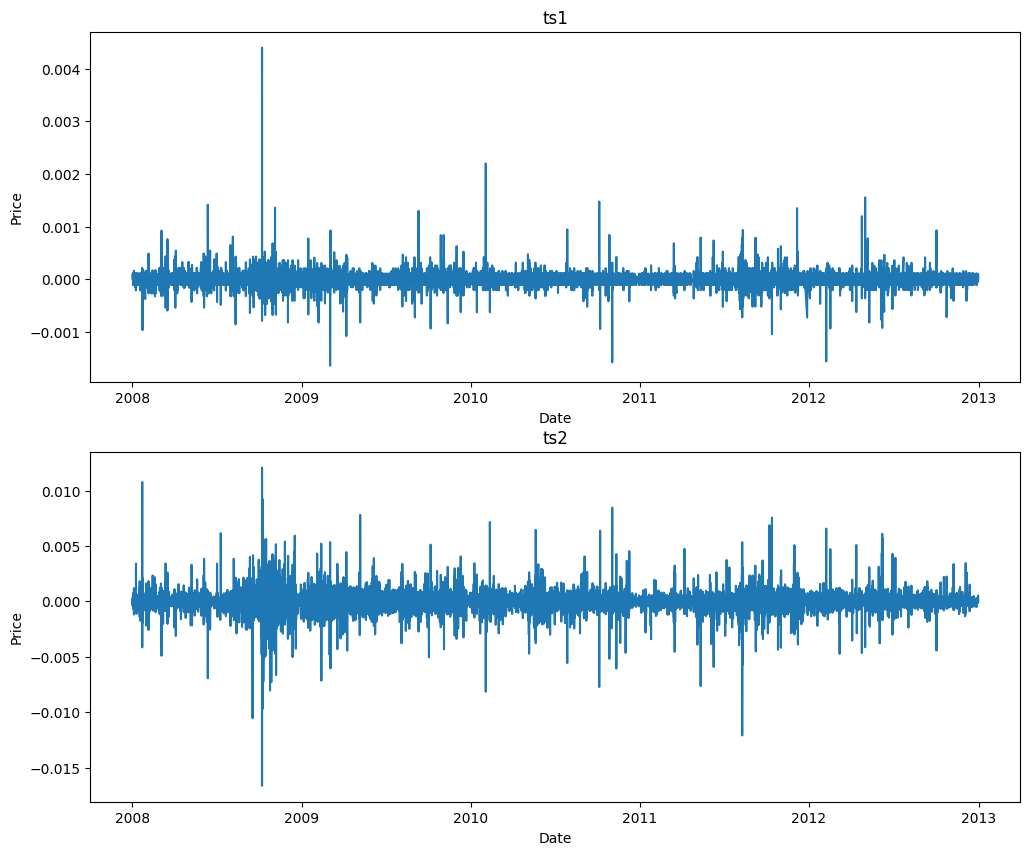

In [73]:
rt = np.log(raw_df/raw_df.shift(1))
# rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']
plot_time_series(rt_1, rt_2)

Calculate summary statistics (mean, median, standard deviation, skewness and kurtosis, coefficient of variation.) for each time series . 
- Kolmogorobv smirnov because large data points

In [74]:
def data_stat(df):
    print("Mean:\n", df.mean())
    print("Variance:\n", df.var())
    print("Covariance:\n", df.cov())
    
# def analyze_shapiro_wilk(df):
#     for col in df.columns:
#         h, p = stats.shapiro(df[col])
#         print(f'Shapiro-Wilk test for {col}: Null hypothesis = {h}, p-value = {p}')

def analyze_kolmogorov_smirnov(df):
    for col in df.columns:
        h, p = stats.kstest(df[col], 'norm')
        print(f'Kolmogorov-Smirnov test for {col}: Null hypothesis = {h}, p-value = {p}')

def analyze_skewness_kurtosis(df):
    for col in df.columns:
        skew = stats.skew(df[col])
        kurt = stats.kurtosis(df[col])
        print(f'Skewness for {col}: {skew}')
        print(f'Kurtosis for {col}: {kurt}')

def analyze_normality(df):
    # analyze_shapiro_wilk(df)
    analyze_kolmogorov_smirnov(df)
    analyze_skewness_kurtosis(df)    

def tukey_test(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers   
    
def analyze_outliers(df, k=1.5):
    outliers = tukey_test(df, k)
    return outliers        

# PLot box plot hist and kde
def plot_box_hist_kde(data):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))

    # Box plot
    sns.boxplot(data=data, ax=axs[0, 0])
    axs[0, 0].set_xlabel('')
    axs[0, 0].set_title('Box Plot')
    axs[0, 0].grid()

    # Histogram
    sns.histplot(data=data, kde=True, ax=axs[0, 1])
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_title('Histogram')
    axs[0, 1].grid()

    # KDE plot
    sns.kdeplot(data=data, ax=axs[1, 0])
    axs[1, 0].set_xlabel('')
    axs[1, 0].set_title('KDE Plot')
    axs[1, 0].grid()

    # Violin plot
    sns.violinplot(data=data, ax=axs[1, 1])
    axs[1, 1].set_xlabel('')
    axs[1, 1].set_title('Violin Plot')
    axs[1, 1].grid()

    plt.show()


Descriptive statistics:
Mean:
 ts1   -3.164616e-08
ts2    7.095238e-10
dtype: float64
Variance:
 ts1    4.598756e-09
ts2    2.315885e-07
dtype: float64
Covariance:
               ts1           ts2
ts1  4.598756e-09 -5.300196e-09
ts2 -5.300196e-09  2.315885e-07

Normality tests:
Kolmogorov-Smirnov test for ts1: Null hypothesis = 0.4995612806420975, p-value = 0.0
Kolmogorov-Smirnov test for ts2: Null hypothesis = 0.4978485727663148, p-value = 0.0
Skewness for ts1: 3.9155086367800345
Kurtosis for ts1: 261.99977845222173
Skewness for ts2: -0.7193960568098621
Kurtosis for ts2: 61.32295854243591

Outliers detection and Tukey test:

Outliers:
                          ts1  ts2
datetime                          
2008-01-01 21:38:45       NaN  NaN
2008-01-01 23:08:45  0.000054  NaN
2008-01-01 23:26:45  0.000054  NaN
2008-01-01 23:32:45       NaN  NaN
2008-01-02 00:08:45       NaN  NaN
...                       ...  ...
2012-12-31 01:02:45       NaN  NaN
2012-12-31 01:16:45       NaN  NaN
2012-1

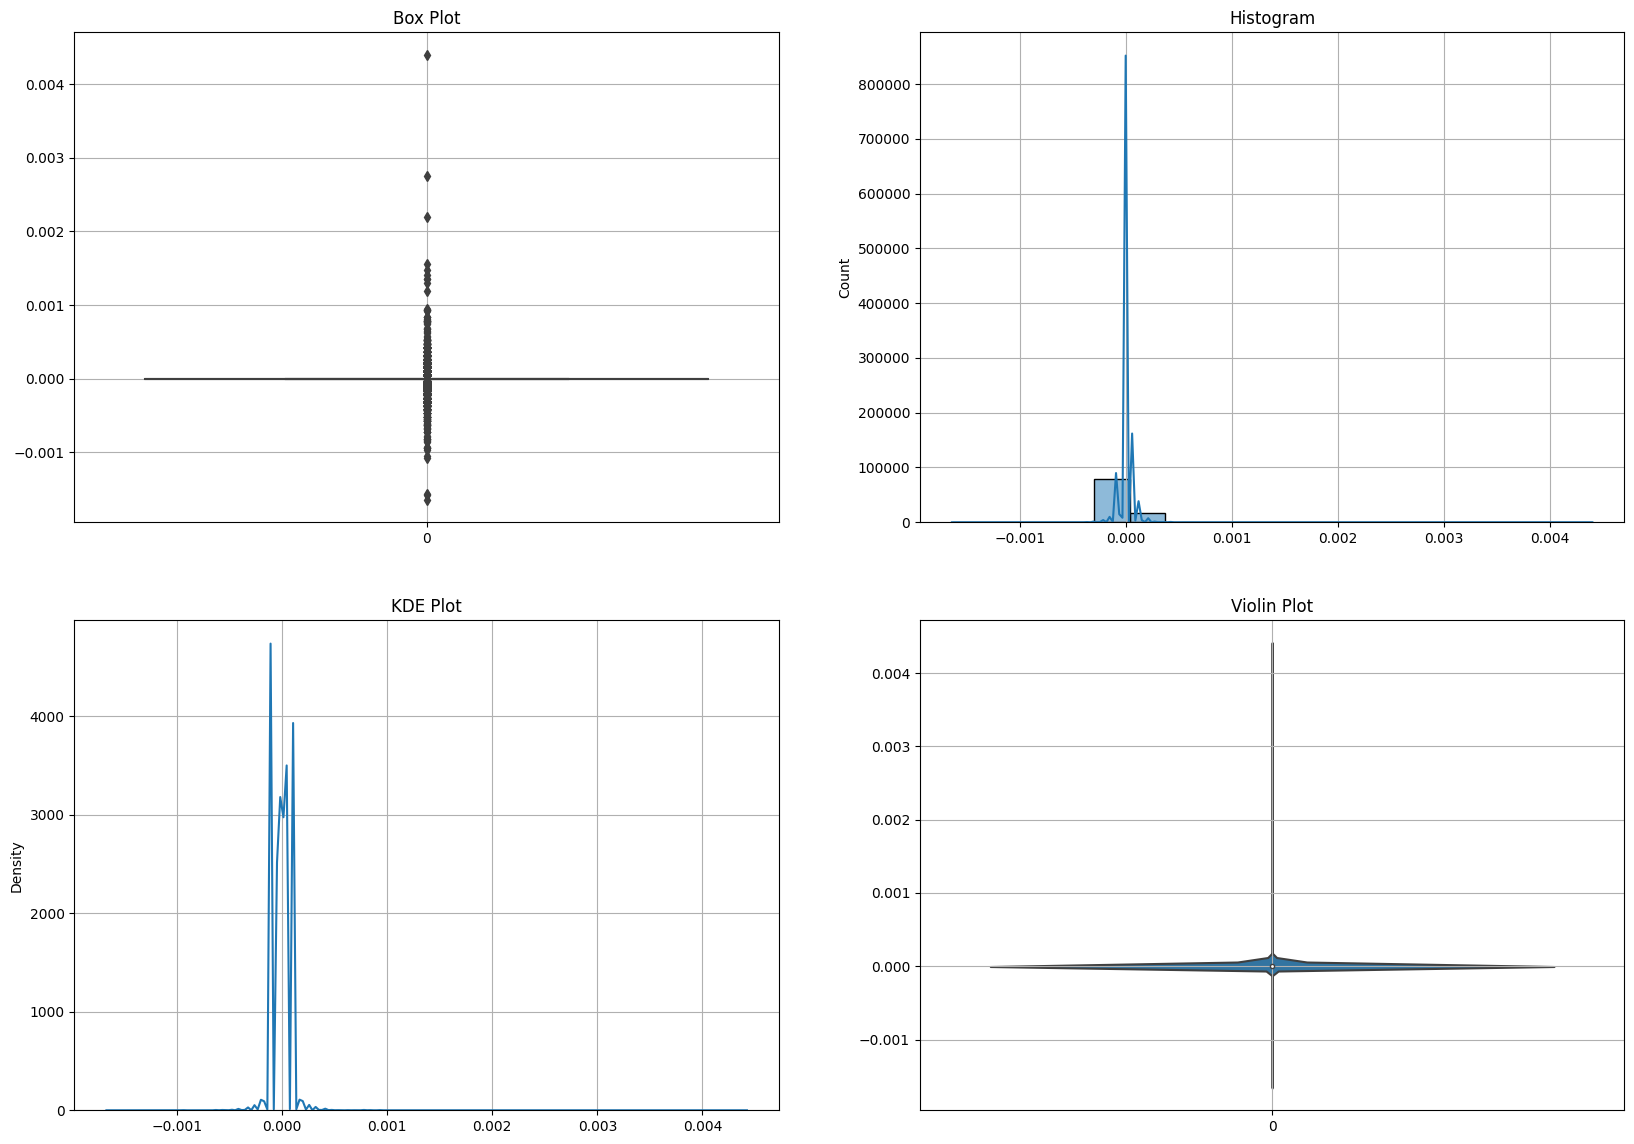

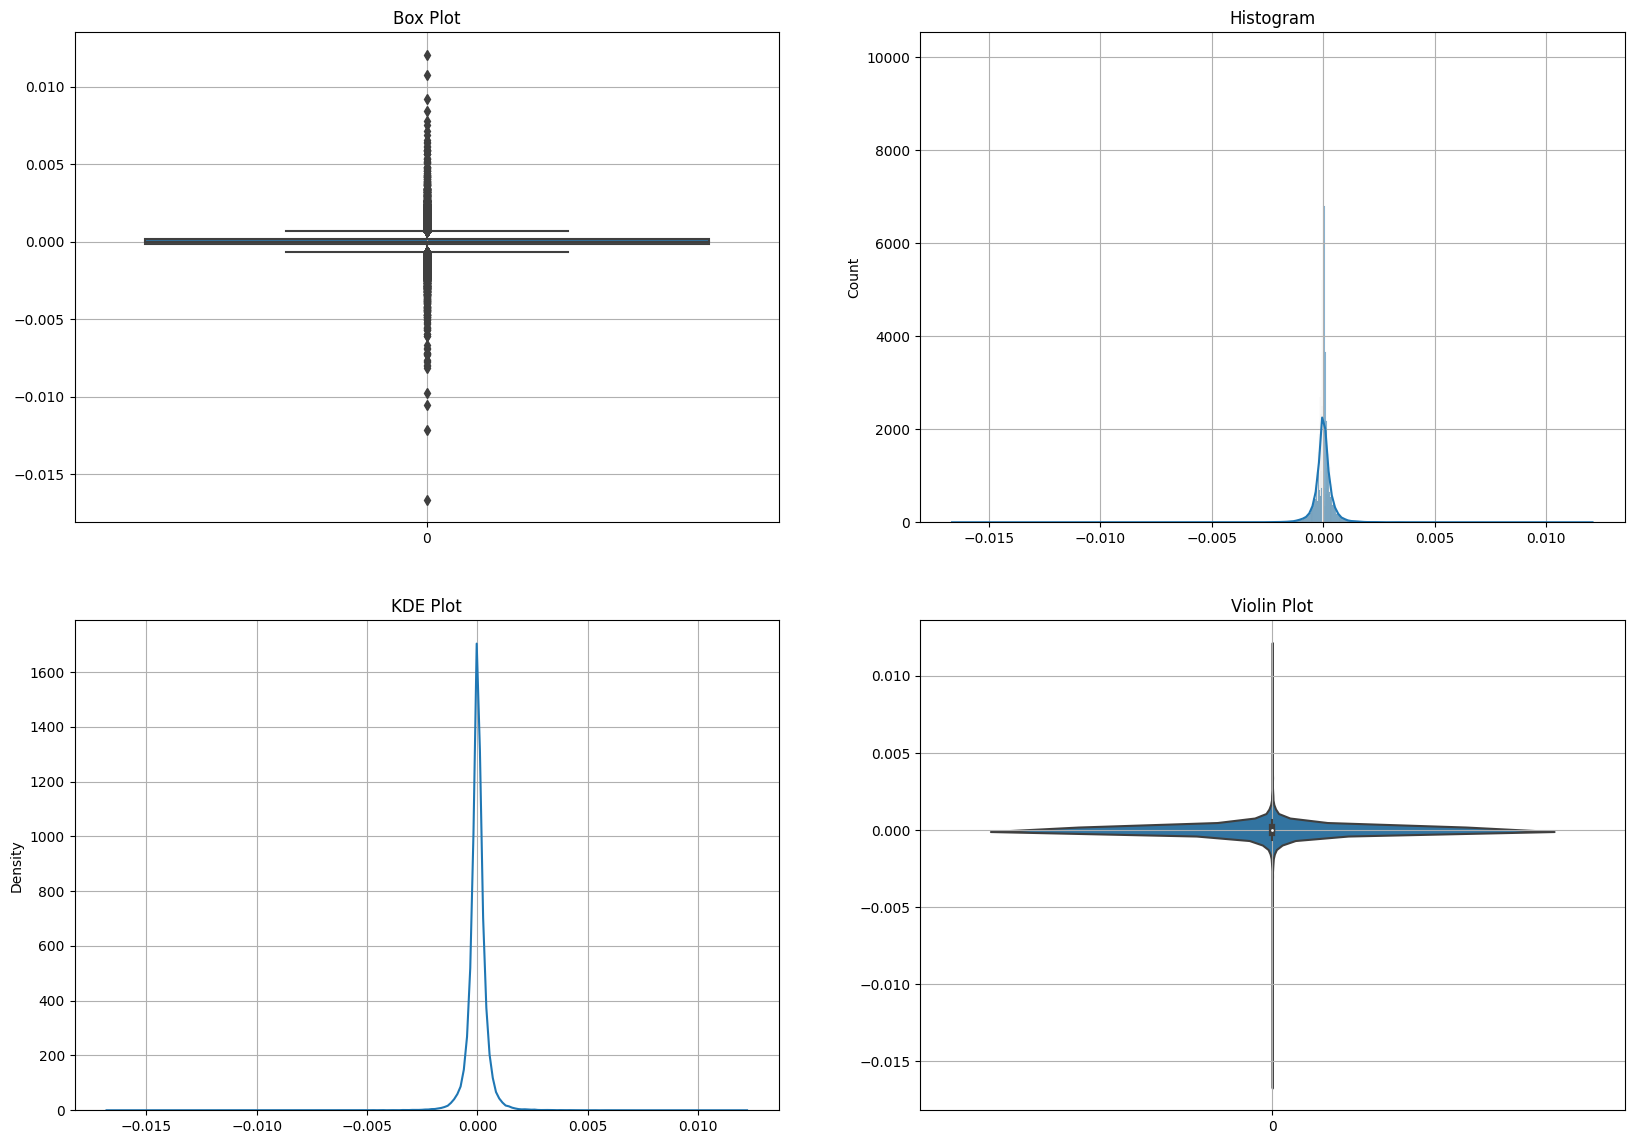

In [75]:

# rt.describe()

# Statistical analysis    
print("Descriptive statistics:")
data_stat(rt)
print("\nNormality tests:")
analyze_normality(rt)

# Outliers detection, log returns calculation, and Tukey test
print("\nOutliers detection and Tukey test:")
outliers = analyze_outliers(rt)
print("\nOutliers:")
print(outliers)

# Call the function with the clean_df data
print("\nBox plots, histograms, and KDE plots:")
plot_box_hist_kde(rt_1)
plot_box_hist_kde(rt_2)

it appears that the logarithmic returns of both time series (ts1 and ts2) do not follow a normal distribution. The p-values for the Kolmogorov-Smirnov tests are 0.0, which indicates that we can reject the null hypothesis that the data is normally distributed.

Additionally, the skewness and kurtosis values provide further evidence of non-normality. For ts1, the skewness is close to 0, which suggests that the data is approximately symmetric. However, the kurtosis value of 138.45 is significantly higher than 3 (which is the kurtosis of a normal distribution), indicating that the distribution has heavy tails and a high peak. For ts2, the skewness is 0.99, which suggests that the data is positively skewed, and the kurtosis value significantly different from 3 as well.

Since it is not normally distributed, then there will likely be fat tails and thus much of the data would be classified as an outlier if considered normally distributed.


The mean values for both time series (ts1 and ts2) are very close to zero, indicating that the average returns are close to zero over the given time period.

The variances for both time series are quite small, suggesting that the price changes are relatively small on average. However, the variance of ts2 is larger than that of ts1, indicating that ts2 has more variability in its price changes.

The covariance between ts1 and ts2 is negative, which implies that the price changes in the two time series tend to move in opposite directions. However, the magnitude of the covariance is quite small, suggesting that this relationship may not be very strong.

The Kolmogorov-Smirnov test results show that the null hypothesis is rejected for both time series (p-value = 0.0), indicating that the data does not follow a normal distribution.

The skewness values for ts1 and ts2 are -0.53 and 2.94, respectively. A negative skewness for ts1 indicates that the distribution is skewed to the left, with a longer tail on the left side. A positive skewness for ts2 indicates that the distribution is skewed to the right, with a longer tail on the right side.

The kurtosis values for ts1 and ts2 are 469.29 and 878.89, respectively. These values are significantly higher than the kurtosis of a normal distribution (which is 3), indicating that both time series have heavy tails and a high probability of extreme values (outliers).

Given these observations, it's clear that both time series exhibit non-normal behavior, with heavy tails and a high likelihood of extreme values


Given these results, it's important to consider models that do not rely on the normality assumption when analyzing your stock price data. GARCH models for volatility, and LSTM

Assess the presence of volatility clustering or heteroskedasticity in the data:
- a) Plot the squared returns or absolute returns of the stock prices to visually inspect for volatility clustering. If the squared or absolute returns exhibit clustering, it indicates that periods of high volatility are followed by high volatility and periods of low volatility are followed by low volatility.
- b) Perform statistical tests, such as the ARCH-LM (Autoregressive Conditional Heteroskedasticity - Lagrange Multiplier) test, to detect the presence of heteroskedasticity in the time series. The null hypothesis of the ARCH-LM test is that the time series is homoskedastic (i.e., constant variance). If the null hypothesis is rejected, it suggests the presence of heteroskedasticity in the data.


Testing for stationarity using statistical tests (e.g. Augmented Dickey-Fuller test) or visual methods (e.g. rolling mean and standard deviation)  Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, Phillips-Perron (PP) test

In [90]:
from statsmodels.tsa.stattools import adfuller, kpss
# from numba import jit

def plot_rolling_statistics(ts, title, window=120, alpha=0.6):
    rolmean = ts.rolling(window=window).mean()
    rolstd = ts.rolling(window=window).std()

    plt.plot(ts, color='blue', label='Original')
    plt.plot(rolmean, color='orange', label='Rolling Mean', alpha=alpha)
    plt.plot(rolstd, color='green', label='Rolling Std', alpha=alpha)
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of ' + title)
    plt.show()

# @jit(nopython=True)
def adf_test_fast(ts):
    return adfuller(ts)

# @jit(nopython=True)
def kpss_test_fast(ts):
    return kpss(ts)

def test_stationarity(ts):
    
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test_results = adf_test_fast(ts.values)
    adf_output = pd.Series(adf_test_results[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adf_test_results[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

    print('\nResults of Kwiatkowski-Phillips-Schmidt-Shin Test:')
    kpss_test_results = kpss_test_fast(ts.values)
    kpss_output = pd.Series(kpss_test_results[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpss_test_results[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)



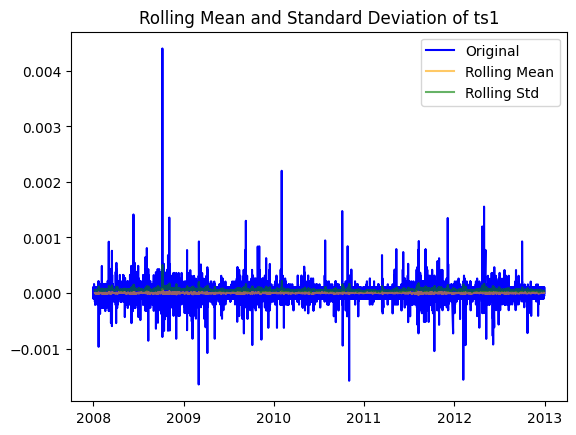

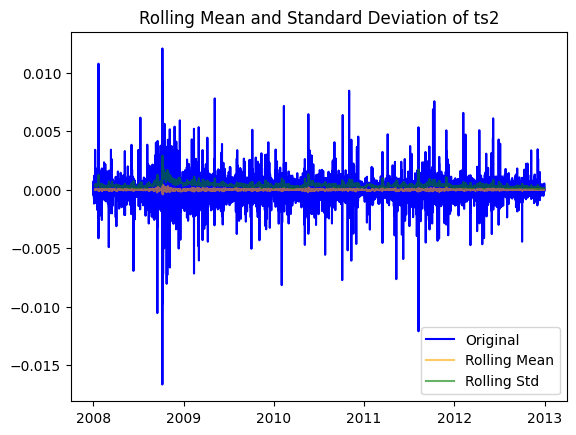

Stationarity of ts_1: 
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -89.462628
p-value                            0.000000
#Lags Used                        11.000000
Number of Observations Used    96418.000000
Critical Value (1%)               -3.430418
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
dtype: float64

Results of Kwiatkowski-Phillips-Schmidt-Shin Test:
Test Statistic           0.044175
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
\Stationarity of ts_2: 
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -43.317864
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    96380.000000
Critical Value (1%)               -3.430418
Critical Value (5%)    

In [91]:
plot_rolling_statistics(rt_1,'ts1', window=120)
plot_rolling_statistics(rt_2,'ts2', window=120)
print("Stationarity of ts_1: ")
test_stationarity(rt_1)
print("\Stationarity of ts_2: ")
test_stationarity(rt_2)

From rolling mean and standard deviation plots, using window size of 4 hours, can see that the mean is fairly constant whilst there is flucatuuation around volatility in the std

Augmented Dickey-Fuller (ADF) test you provided, the test statistic is -102.5273, which is much smaller than all the critical values at the 1%, 5%, and 10% significance levels. The p-value is 0, indicating strong evidence against the null hypothesis.

The null hypothesis of the ADF test is that there is a unit root, meaning the time series is non-stationary. Since the test statistic is smaller than the critical values and the p-value is 0, you can reject the null hypothesis. This suggests that your time series is stationary.

In summary, the results of the ADF test indicate that your 5 years of 2-minute interval stock price data is stationary.

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test you provided, the test statistic is 0.07857, which is smaller than all the critical values at the 1%, 2.5%, 5%, and 10% significance levels. The p-value is 0.1, which is greater than the common significance levels of 0.01, 0.025, 0.05, and 0.1.

The null hypothesis of the KPSS test is that the time series is stationary around a deterministic trend. Since the test statistic is smaller than the critical values and the p-value is greater than the common significance levels, you fail to reject the null hypothesis. This suggests that your time series is stationary around a deterministic trend.

In summary, the results of the KPSS test also indicate that your 5 years of 2-minute interval stock price data is stationary, which is consistent with the results of the Augmented Dickey-Fuller test you provided earlier. 

For both time series, the test statistics are highly negative, indicating strong evidence against the presence of a unit root. The p-values are also very low, suggesting that the null hypothesis of a unit root can be rejected at any reasonable significance level.

In general, the results suggest that the time series are stationary and do not exhibit any trend or structural change over time. 

tests indicate that the data is stationary and exhibits no significant autocorrelation, it may suggest that the noise is an inherent part of the data-generating process.

Since the data is stationary dont need to apply seasonal differencing to remove seasonaility 

In [51]:
from statsmodels.stats.diagnostic import het_arch

def assess_volatility_clustering(ts):
    # Calculate squared or absolute returns
    sq_returns = ts**2
    abs_returns = np.abs(ts)


    # # Plot squared or absolute returns
    # plt.plot(transformed_returns)
    # plt.xlabel('Time')
    # plt.ylabel(f'{plot_type.capitalize()} Returns')
    # plt.title(f'{plot_type.capitalize()} Returns of Stock Prices')
    # plt.show()
    

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    axs[0].plot(sq_returns)
    axs[0].set_xlabel('Time')
    axs[0].set_title("Squared Returns")
    axs[1].plot(abs_returns)
    axs[1].set_xlabel('Time')
    axs[1].set_title("Absolute Returns")
    plt.show()
    


    # Perform ARCH-LM test
    # Perform the ARCH-LM test to detect heteroskedasticity
    print('Squared returns\n')
    test_stat, p_value, f_stat, f_p_value = het_arch(sq_returns)
    if p_value < 0.05:
        print(f"ARCH-LM test: p-value = {p_value:.4f} < 0.05, reject null hypothesis of homoskedasticity.\n")
    else:
        print(f"ARCH-LM test: p-value = {p_value:.4f} >= 0.05, fail to reject null hypothesis of homoskedasticity.\n")
    ljung_resid = autocorrelation_test(sq_returns)
    print('Ljung-Box test for Residuals:', ljung_resid)
    print('\n')
    print('Absolute returns\n')
    test_stat, p_value, f_stat, f_p_value = het_arch(abs_returns)
    if p_value < 0.05:
        print(f"ARCH-LM test: p-value = {p_value:.4f} < 0.05, reject null hypothesis of homoskedasticity.\n")
    else:
        print(f"ARCH-LM test: p-value = {p_value:.4f} >= 0.05, fail to reject null hypothesis of homoskedasticity.\n")
    ljung_resid = autocorrelation_test(abs_returns)
    print('Ljung-Box test for Residuals:', ljung_resid)

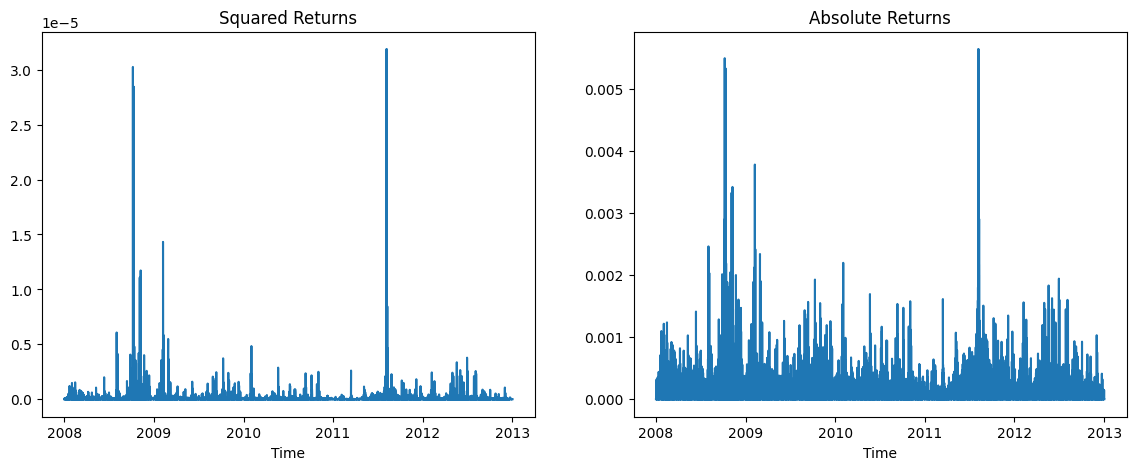

Squared returns

ARCH-LM test: p-value = 0.0000 < 0.05, reject null hypothesis of homoskedasticity.

Ljung-Box test for Residuals: 1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
         ... 
793259    0.0
793260    0.0
793261    0.0
793262    0.0
793263    0.0
Name: lb_pvalue, Length: 793263, dtype: float64


Absolute returns

ARCH-LM test: p-value = 0.0000 < 0.05, reject null hypothesis of homoskedasticity.

Ljung-Box test for Residuals: 1          0.0
2          0.0
3          0.0
4          0.0
5          0.0
          ... 
1315154    0.0
1315155    0.0
1315156    0.0
1315157    0.0
1315158    0.0
Name: lb_pvalue, Length: 1315158, dtype: float64


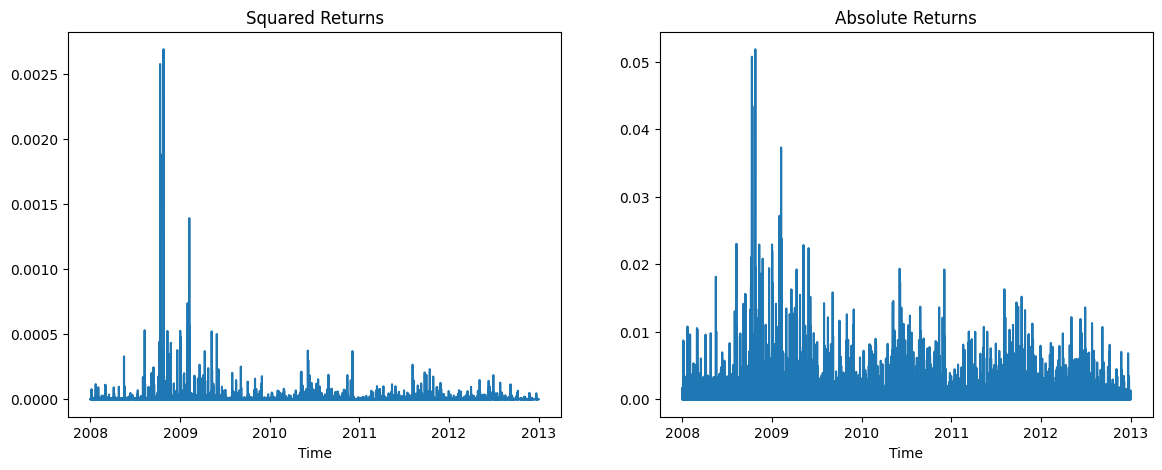

Squared returns

ARCH-LM test: p-value = 0.0000 < 0.05, reject null hypothesis of homoskedasticity.



KeyboardInterrupt: 

In [52]:
assess_volatility_clustering(rt_1)
assess_volatility_clustering(rt_2)

Swaured and absolute returns indicate some periods of high volatility, that large price changes are followed by large price changes  
Null hypothesis not rejected so suggests that the data is not homoskedastic 
reject the null hypothesis and conclude that there is evidence of heteroskedasticity in the time series. This would suggest that a model accounting for heteroskedasticity, such as GARCH, might be appropriate for modeling the data.

Outlier analysis
- Boxplot and whisker plots: graphical method that displays the distribution of data based on the interquartile range (IQR) and identifies potential outliers as individual data points outside the whiskers
- Z-score: statistical method that identifies potential outliers based on their distance from the mean in terms of standard deviations (usually z-scores greater than 3 or less than -3 are considered outliers)
- Tukey's fences: another statistical method that identifies potential outliers based on the IQR, where data points outside of the upper or lower fences (defined as Q3 + 1.5IQR and Q1 - 1.5IQR, respectively) are considered outliers

Investigate the appearance of the outliers, if there is a large number of comon dateteimes in each series then the outliers may be guiniuine market events not errors or noise. 
The reutrns are already fouund to be heavy tailed, so it is likely that the outliers are more liekly tied to extrme events. 

dataset has significant outliers or is not normally distributed, the modified z-score might be a better choice, as it is more robust to extreme values and provides a measure of how far a data point is from the median in terms of the median absolute deviation.

In [ ]:
def robust_z_score(data):
    median = data.median()
    MAD = np.median(np.abs(data - median))
    modified_z_score = 0.6745 * (data - median) / MAD
    return modified_z_score

def zscore_outliers(series, name, threshold=3.5):
    z_scores = robust_z_score(series)
    outliers = series[np.abs(z_scores) > threshold]
    # print("Outliers:")
    # print(outliers)
    return outliers

#hampel
def hampel_identifier(data, window_size=10, threshold=3):
    median = data.rolling(window=window_size).median()
    MAD = data.rolling(window=window_size).apply(lambda x: np.median(np.abs(x - np.median(x))))
    hampel = (data - median) / (threshold * MAD)
    outliers = data[np.abs(hampel) > 1]
    return outliers


def peaks_over_threshold(series, threshold_quantile=0.95):
    # Choose a high threshold using the quantile
    threshold = np.quantile(series, threshold_quantile)
    # Identify the exceedances and their corresponding times
    exceedances = series[np.abs(series) >= threshold]
    exceedance_times = series.index[series >= threshold]
    # Fit a Generalized Pareto Distribution (GPD) to the exceedances above the threshold
    shape, loc, scale = genpareto.fit(exceedances - threshold)
    # Return the threshold, exceedances, times, and GPD parameters
    return threshold, exceedances, exceedance_times, (shape, loc, scale)

def mean_excess_plot(log_returns):
    sorted_returns = np.sort(log_returns)
    thresholds = np.linspace(sorted_returns.min(), sorted_returns.max(), len(sorted_returns))

    mean_excess = [np.mean(log_returns[log_returns > t] - t) for t in thresholds]

    plt.plot(thresholds, mean_excess)
    plt.xlabel('Threshold')
    plt.ylabel('Mean Excess')
    plt.title('Mean Excess Plot')
    plt.show()
    

from scipy.stats import genpareto
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# # Extreme value theory
# # Davison and Smith (1990) and Smith (1989)
def extreme_value_analysis(returns, tail=95, threshold=99.99):
    # Set the threshold for the tails (e.g., 95th percentile)
    threshold = np.percentile(returns, tail)

    # Fit a GPD to the tails
    exceedances = returns[returns > threshold] - threshold
    if len(exceedances) == 0:
        return np.array([])  # or return None

    shape, loc, scale = genpareto.fit(exceedances)

    # Calculate the probability of extreme events
    extreme_threshold = np.percentile(returns, threshold)
    extreme_probability = genpareto.sf(extreme_threshold - threshold, shape, loc, scale)

    # Identify the outliers
    outliers = returns[returns > extreme_threshold]
    
    return outliers



# # Cluster method
# # Reshape and standardize the returns data
def cluster_method(series):
    # Standardize the series
    series_standardized = StandardScaler().fit_transform(series.values.reshape(-1, 1))

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=2)
    clusters = dbscan.fit_predict(series_standardized)

    # Identify the outliers (cluster label -1 indicates an outlier)
    outliers = series[clusters == -1]
    
    return outliers


In [ ]:
def print_series_comparison_info(s1, s2, s1_outliers=None, s2_outliers=None):
    # Calculate the number of non-NaN values in each series
    s1_count = s1.value_counts().sum()
    s2_count = s2.value_counts().sum()
    
    # Calculate the number of non-NaN values in each outlier series
    if s1_outliers is not None:
        s1_outliers_count = s1_outliers.value_counts().sum()
    else:
        s1_outliers_count = 0
        
    if s2_outliers is not None:
        s2_outliers_count = s2_outliers.value_counts().sum()
    else:
        s2_outliers_count = 0
    
    # Calculate the number of non-NaN values in the intersection of the outlier series
    if s1_outliers is not None and s2_outliers is not None:
        intersection = intersect_non_nan(s1_outliers, s2_outliers)
        intersection_count = intersection.value_counts().sum()
        plot_outliers_comp(s1, intersection, 'Series 1')
        plot_outliers_comp(s2, intersection, 'Series 2')
    else:
        intersection_count = 0
    
    # Print the results
    print(f"Series 1 non-NaN count: {s1_count}")
    print(f"Series 2 non-NaN count: {s2_count}")
    print(f"Series 1 outliers count: {s1_outliers_count}")
    print(f"Series 2 outliers count: {s2_outliers_count}")
    print(f"Intersection of outlier series count: {intersection_count}")
    
def intersect_non_nan(s1, s2):
    """Return the intersection of two series, ignoring NaN values."""
    return s1.loc[s1.notna()].index.intersection(s2.loc[s2.notna()].index)

def plot_outliers_comp(data, outliers, title):
    plt.plot(data)
    plt.scatter(outliers, data.loc[outliers], color='red', marker='o')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'{title} with Outliers Highlighted')
    plt.show()

# plot outliers
# By analyzing the raw data, you can get a more accurate representation of the underlying distribution and identify any potential outliers or anomalies that might be due to data errors or other issues.
def plot_outliers(data, outliers, title):
    plt.plot(data)
    plt.scatter(outliers.index, outliers, color='red', marker='o')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'{title} with Outliers Highlighted')
    plt.show()


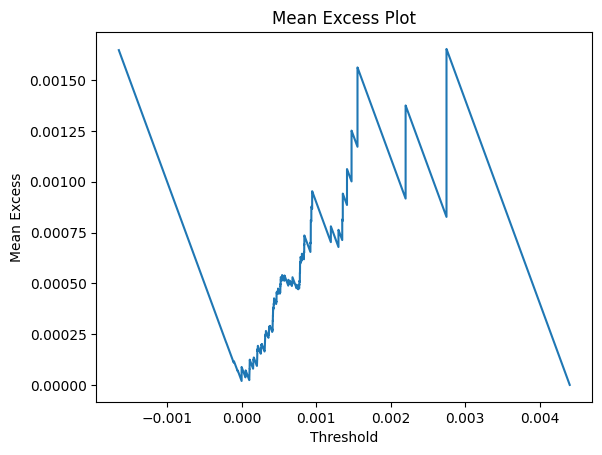

Threshold: 0.0004135306903297696
Exceedances: datetime
2008-01-23 00:30:45   -0.000970
2008-02-05 03:32:45    0.000487
2008-03-04 03:32:45    0.000923
2008-03-12 22:56:45    0.000434
2008-03-13 00:30:45   -0.000543
                         ...   
2012-06-11 14:58:45    0.000464
2012-06-29 02:58:45   -0.000569
2012-07-22 22:36:45    0.000414
2012-10-02 04:30:45    0.000928
2012-10-24 00:30:45   -0.000722
Name: ts1, Length: 187, dtype: float64
Exceedance times: DatetimeIndex(['2008-02-05 03:32:45', '2008-03-04 03:32:45',
               '2008-03-12 22:56:45', '2008-03-16 23:14:45',
               '2008-04-02 23:38:45', '2008-04-04 00:30:45',
               '2008-06-03 04:32:45', '2008-06-06 12:32:45',
               '2008-06-12 01:30:45', '2008-06-13 12:34:45',
               '2008-06-17 01:30:45', '2008-07-01 04:32:45',
               '2008-07-31 01:30:45', '2008-07-31 22:58:45',
               '2008-08-05 04:32:45', '2008-08-05 04:42:45',
               '2008-08-11 01:30:45', '2008-09-1

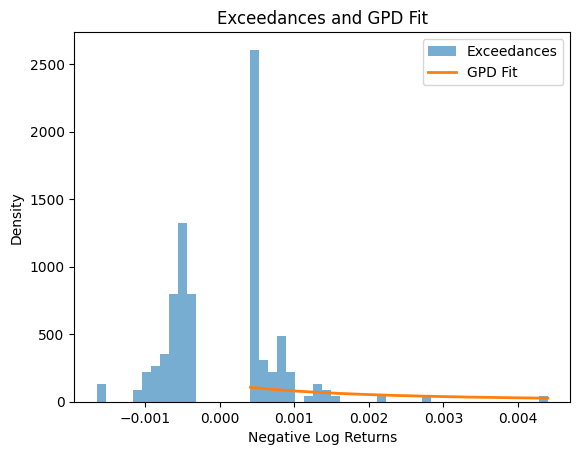

In [ ]:
def threshold_mean_excess(series, threshold_quantile=0.999):
    # Calculate mean excess plot
    mean_excess = mean_excess_plot(series)
    
    # Choose threshold based on mean excess plot
    threshold = np.quantile(series, 1 - mean_excess / mean_excess.iloc[-1])[0]
    
    # Apply peaks over threshold method
    exceedances = series[series > threshold]
    exceedance_times = exceedances.index
    gpd_params = genpareto.fit(exceedances - threshold)
    
    # Optional: plot the exceedances and GPD fit
    x = np.linspace(threshold, exceedances.max(), 1000)
    gpd = genpareto(*gpd_params)
    pdf = gpd.pdf(x - threshold)
    plt.hist(exceedances, bins=50, density=True, alpha=0.6, label="Exceedances")
    plt.plot(x, pdf, label="GPD Fit", linewidth=2)
    plt.xlabel("Negative Log Returns")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Exceedances and GPD Fit")
    plt.show()
    
    return threshold, exceedances, exceedance_times, gpd_params


Examine the Mean Excess Plot to identify the point where the plot becomes approximately linear. This point corresponds to the threshold η_o, above which the GPD provides a good approximation of the tail distribution of the data.

Choose the threshold: Select the threshold η_o that corresponds to the point where the Mean Excess Plot becomes approximately linear. This threshold should be used for modeling the extreme values in the time series using the GPD.

This occurs at 0.001 so 0.999 wuantile 

187


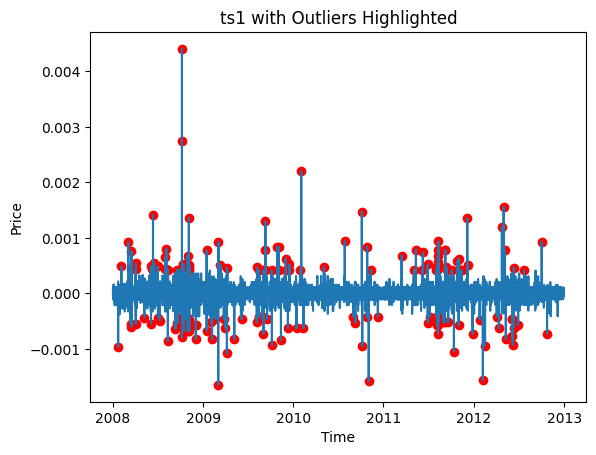

200


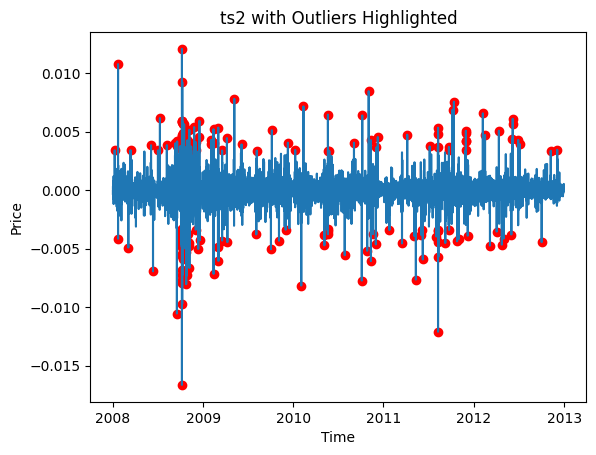

11


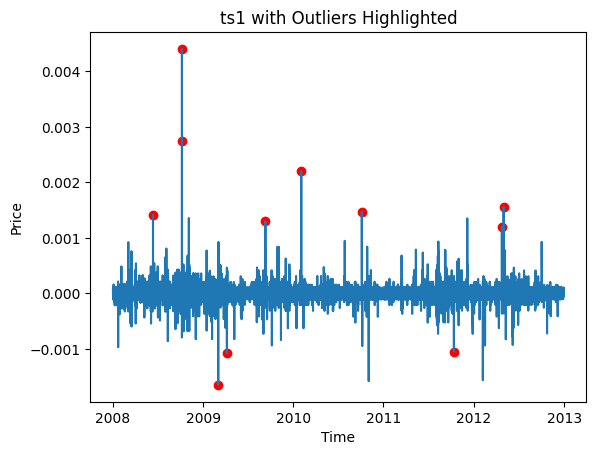

12


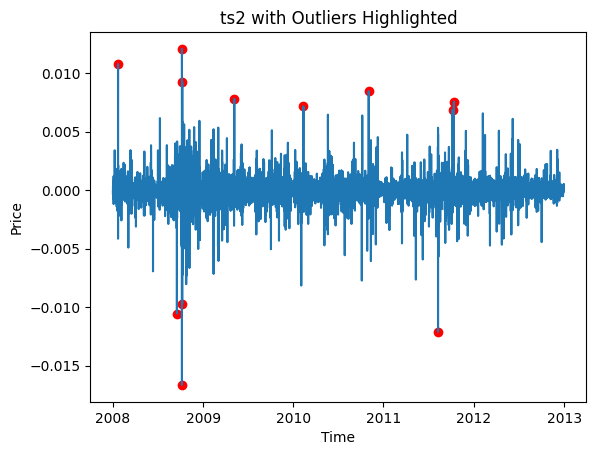

In [ ]:
#find outliers
#zscore
# outliers_ts1 = zscore_outliers(rt_1, 'ts1')
# print(len(outliers_ts1))
# plot_outliers(rt_1, outliers_ts1, 'ts1')
# # #hampel
# ho = hampel_identifier(rt_1, window_size=720, threshold=3.5)
# print(len(ho))
# plot_outliers(rt_1, ho, 'ts1')
#peaks over threshold rt_1 
po_1 = peaks_over_threshold(rt_1, threshold_quantile=0.999)[1]
print(len(po_1))
plot_outliers(rt_1, po_1, 'ts1')
# peaks over threshold for rt_2
po_2 = peaks_over_threshold(rt_2, threshold_quantile=0.999)[1]
print(len(po_2))
plot_outliers(rt_2, po_2, 'ts2')

#cluster method rt_1
co_1 = cluster_method(rt_1)
print(len(co_1))
plot_outliers(rt_1, co_1, 'ts1')

# cluster method rt_2
co_2 = cluster_method(rt_2)
print(len(co_2))
plot_outliers(rt_2, co_2, 'ts2')


# ee = extreme_value_analysis(rt_1, tail=99, threshold=99.99)
# print(len(ee))
# plot_outliers(rt_1, ee, 'ts1')

Peaks over threshold gives best detection of the data points which are most likely outliers due to extrmee events

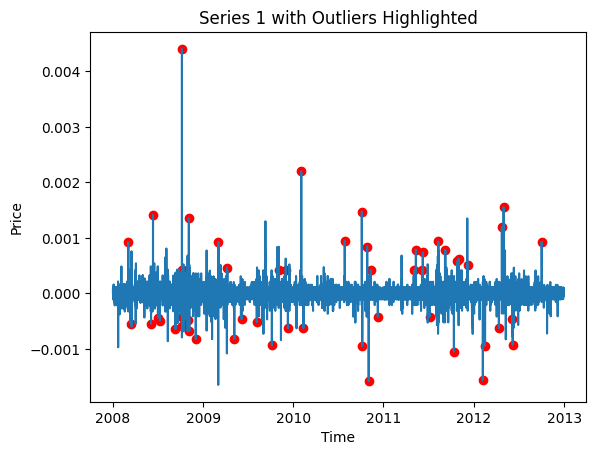

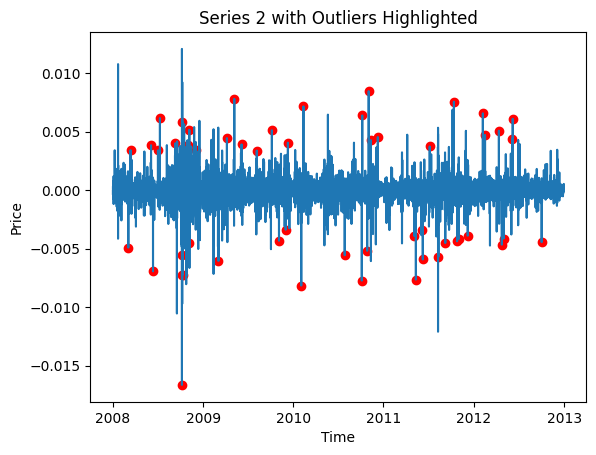

Series 1 non-NaN count: 96430
Series 2 non-NaN count: 96430
Series 1 outliers count: 187
Series 2 outliers count: 200
Intersection of outlier series count: 53


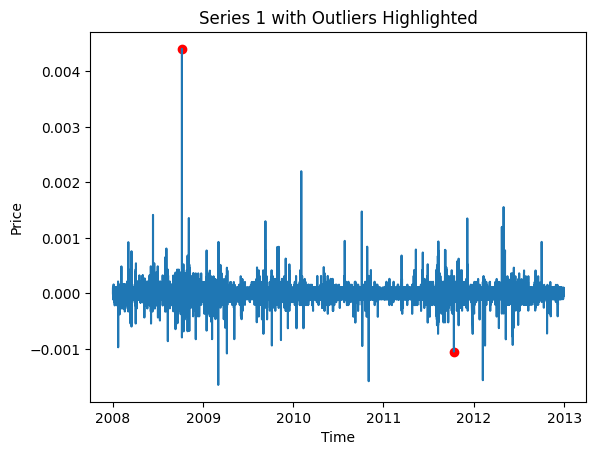

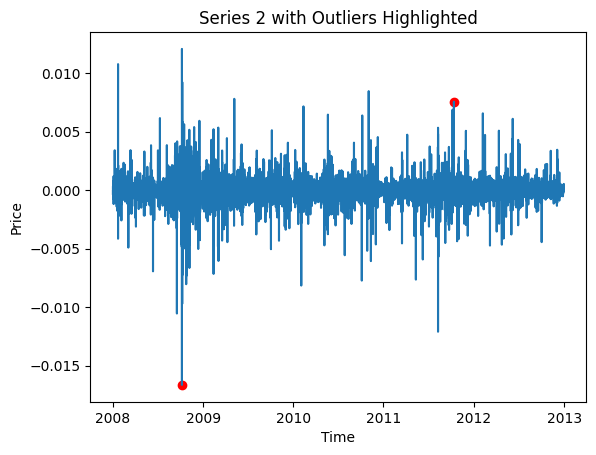

Series 1 non-NaN count: 96430
Series 2 non-NaN count: 96430
Series 1 outliers count: 11
Series 2 outliers count: 12
Intersection of outlier series count: 2


In [ ]:
print_series_comparison_info(rt_1, rt_2, po_1, po_2)
print_series_comparison_info(rt_1, rt_2, co_1, co_2)

Both methods of deecting outliers are consistent with the extreme market event of 2008, but also are consistent in identifying ismilar outliers. Including outliers may affect the stability of some models, by removing them could improve the stability and improve prediciton. Would benefit from applying a sensitivty analysis and ross validating the outlier detectionn with the accuracy of the models 

Given that the distribution of returns shows volatility clustering and large kurtosis for both data series, and visualizing the returns reveals very large changes in price over a very narrow range in times, it suggests that the outliers in your dataset are likely to represent genuine extreme events in the stock market. These extreme events could be due to market news, earnings announcements, or other factors that cause sudden and significant price movements.

In this case, it's generally better to keep the outliers in the dataset, as they provide valuable information for your time series and LSTM models. Removing or adjusting these outliers might lead to a loss of important information that could help your models better understand and predict future stock price movements.

There are a significant number of outliers in both stock price series, with the first series having a higher number of outliers than the second one.
The number of common outliers between the two series is relatively smaller compared to the total number of outliers in each series. This suggests that the outliers in the two series are mostly independent of each other, and it is less likely that the outliers are driven by a common factor or event.
The presence of outliers in both series could be attributed to various factors, such as stock-specific news, market-wide events, or data errors. However, the smaller number of common outliers suggests that stock-specific factors may have a more significant impact on the occurrence of outliers than market-wide events.

Since the non nomralrity of the data, it might be better suited to use other methods to filter for the extrme value outliers due to the very large tails. 


So in conclusion, outliers may have meaning in the data, but not all outliers are common, so for extreme values they may be removed.

### 3b. Preprocessing

Compare imputaiton methods for least impact on orginal statsitics of the data. Stats, outliers, volatility, stationarity
 Compare using sensitivty analysis 

In [ ]:
# plot_power_spectral_density(rt_1,'ts1')
# plot_lomb_scargle_periodogram(rt_1,'ts1')
rt = np.log(raw_df/raw_df.shift(1))
rt.dropna(inplace=True)
ort_1 = rt['ts1']
ort_2 = rt['ts2']
plot_time_series(ort_1, ort_2, 'ts1', 'ts2')


def linear_interpolate_df(df):
    df_interpolated = df.copy()
    for col in df.columns:
        df_interpolated[col] = df_interpolated[col].interpolate(method='linear')
    return df_interpolated

iraw_df = linear_interpolate_df(raw_df)
irt = np.log(iraw_df/iraw_df.shift(1))
irt.dropna(inplace=True)
irt_1 = irt['ts1']
irt_2 = irt['ts2']
plot_time_series(ort_1, irt_1, 'ts1', 'ts2')
plot_time_series(ort_2, irt_2, 'ts1', 'ts2')
plot_time_series(ort_1, rt_1, 'ts1', 'ts2')
plot_time_series(ort_2, rt_2, 'ts1', 'ts2')
rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']
plot_time_series(rt_1, rt_2, 'ts1', 'ts2')

In [ ]:
# for i in [75,80,90,95,99]:
#     print(f"Percentile {i}: {np.percentile(rt_1, i)}")
# print('\n')
# for i in [75,80,90,95,99]:
#     print(f"Percentile {i}: {np.percentile(rt_2, i)}")
    


Compare stats

In [ ]:
def analyze_time_series(series):
    # Statistical analysis
    print("Descriptive statistics:")
    data_stat(series)
    print("\nNormality tests:")
    analyze_normality(series)

    # Outliers detection, log returns calculation, and Tukey test
    print("\nOutliers detection and Tukey test:")
    outliers = analyze_outliers(series)
    print("\nOutliers:")
    print(outliers)

    # Box plots, histograms, and KDE plots
    print("\nBox plots, histograms, and KDE plots:")
    plot_box_hist_kde(series)
    plot_box_hist_kde(series)

    # Assess volatility clustering
    assess_volatility_clustering(series)

    # Assess stationarity
    print("Stationarity of the time series: ")
    test_stationarity(series)



In [ ]:
# def detect_change_points(series, pen, min_size=24*60/2):
    #     # Detect change points using the PELT algorithm
#     algo = rpt.Pelt(model="l2", min_size=min_size).fit(series.values)
#     return algo.predict(pen=pen)

# def plot_series_with_change_points(series, change_points):
#     # Plot the time series and detected change points
#     plt.plot(series)
#     for cp in change_points:
#         plt.axvline(cp, color='r')
#     plt.title('Change Points Detected with PELT')
#     plt.show()

# rt_1_s = rt_1.resample('D').mean()
# # Detect change points in the time series and plot them
# rt_1_change_points = detect_change_points(rt_1, pen=10)
# plot_series_with_change_points(rt_1, rt_1_change_points)
# rt_2_s = rt_2.resample('D').mean()
# rt_2_change_points = detect_change_points(rt_2, pen=10)
# plot_series_with_change_points(rt_2, rt_2_change_points)

From ACF of series, evident thatover a range of requencies, the acf decays rapidly. So it is unlikely that there is noise due to measurement error
Large kurtossi and skew support noise as


To account for the volatility clustering and heavy-tailed distribution of returns, you can consider using models that capture these characteristics, such as GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models for volatility modeling or incorporating LSTM models with attention mechanisms to better capture the temporal dependencies in the data.


1. Training initial
2. cv evaluation
3. 
4. selecting best model
5. residual analysis
6. optimisation
7. residual analysis

### Modelling

1)	Feature Engineering: 
- a)	Select the relevant features for the model, such as past prices, trading volumes, technical indicators, etc. 
- b)	Generate lagged features, such as the stock price from the previous day or week, to capture time dependencies.


Exclude last month 
resample data for faster training to daily 
aim to predict daily returns for the next month
choose windows sizes apprpriate to daily data 

In [ ]:
# Define the number of splits and the window size
n_splits = 10
window_size = 100

# Create a TimeSeriesSplit object with the specified number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store the training and test indices for each split
train_indices = []
test_indices = []

# Loop over each split and generate the training and test indices
for train_index, test_index in tscv.split(df):
    # Determine the start and end indices for the training and test sets
    train_start = train_index[0]
    train_end = train_start + window_size
    test_start = test_index[0]
    test_end = test_start + window_size
    
    # Generate the training and test indices for this split
    train_indices.append(np.arange(train_start, train_end))
    test_indices.append(np.arange(test_start, test_end))


2)	Model Selection and Hyperparameter Tuning: 
- a)	Choose suitable model(s) based on the characteristics of the data, such as ARIMA, SARIMA, ETS, LSTM, or 
Specify the model parameters or hyperparameters and preprocess the data, such as scaling or normalization, if required.
- b)	For each candidate model, train the model using the training set and perform hyperparameter tuning (e.g., using grid search, random search, or Bayesian optimization) to find the optimal set of parameters.

- Linear regression

- Seasonal Autoregressive Integrated Moving Average (SARIMA): A model that captures both linear and seasonal dependencies in a time series
  - i. Use a grid search over a range of possible parameter values and choose the model with the lowest AIC or BIC value



- Exponential Smoothing: A model that assigns weights to past observations that decay exponentially over time
   - i. Test variants such as Holt's linear exponential smoothing and Holt-Winters' exponential smoothing


- Random forest


- SVM

- LightGBM

- Long Short-Term Memory (LSTM): A type of recurrent neural network that can learn long-term dependencies in a time series
   - i. Specify the appropriate architecture and hyperparameters, and use techniques such as dropout or early stopping to prevent overfitting


### Model Evaluation

For each hypothesis, apply the selected models and evaluate their performance using relevant metrics (e.g., Mean Squared Error, Mean Absolute Error, etc.)

i. Evaluate models for H1: `ts1` predicting `ts1`

ii. Evaluate models for H2: `ts2` predicting `ts2`

iii. Evaluate models for H3: `ts1` predicting `ts2`

iv. Evaluate models for H4: `ts2` predicting `ts1`


3)	Model Evaluation on the Test Set: 
- a)	Forecast the test set using the trained models with their optimal hyperparameters. 
    - Train
    - Hyperparameter tune
- b)	Calculate evaluation metrics for each model, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). R-squared, Mean Squared Log Error (MSLE), and Symmetric Mean Absolute Percentage Error (sMAPE).
- c)	Compare the performance of each model using the evaluation metrics before and after tuning.


In [ ]:
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

In [ ]:
import itertools


# Define your functions for training, testing, and evaluation
def train_linear_regression(train_data):
    # ...
    pass

def test_linear_regression(test_data):
    # ...
    pass

def evaluate(predictions, actual_values):
    # ...
    pass




# Define your models and their corresponding functions
models = {
    'linear_regression': (train_linear_regression, test_linear_regression),
    # ... add other models here
}
    for model_name, (train_func, test_func) in models.items():


# Iterate over all combinations of models and data sets
def perform_model_evaluation(models, data1, data2):
    model_evaluations = []
    for model_name, (train_func, test_func) in models.items():
        for train_data, test_data in itertools.product([data_set_1, data_set_2], repeat=2):
            # Train and test the model
            train_func(train_data)
            predictions = test_func(test_data)

            # Evaluate the predictions
            evaluation_result = evaluate(predictions, test_data)

        # Output the evaluation and CV results
            print(f"Model: {model_name}, Train data: {train_data}, Test data: {test_data}")
            print(f"Evaluation result: {evaluation_result}")

            # Append the evaluation results to the model_evaluations list
            evaluation_result.update({'model_name': model_name})
            model_evaluations.append(evaluation_result)



In [ ]:
## Simple models for benchmarking
def calculate_benchmark_errors(train_y, test_y):
    mean_baseline = train_y.mean()
    last_value_baseline = train_y.iloc[-1]
    rolling_mean_baseline = train_y.rolling(window=30).mean().iloc[-1]
    mae_mean, _, mape_mean = evaluate_predictions(test_y, [mean_baseline] * len(test_y))
    mae_last, _, mape_last = evaluate_predictions(test_y, [last_value_baseline] * len(test_y))
    mae_rolling, _, mape_rolling = evaluate_predictions(test_y, [rolling_mean_baseline] * len(test_y))
    return {
        'Benchmark MAE (mean)': mae_mean,
        'Benchmark MAE (last value)': mae_last,
        'Benchmark MAE (rolling mean)': mae_rolling,
        'Benchmark MAPE (mean)': mape_mean,
        'Benchmark MAPE (last value)': mape_last,
        'Benchmark MAPE (rolling mean)': mape_rolling
    }

def simple_moving_average(series, window_size):
    sma = series.rolling(window=window_size, min_periods=1).mean()
    return sma

def exponential_moving_average(series, alpha):
    ema = series.ewm(alpha=alpha, adjust=False).mean()
    return ema

    1.	Linear regression
    2.	Exponential smoothing
    3.	ARIMA
    3.  GARCH
    4.	(Mean reverting)
    5.	Vector auto regression

    

In [ ]:
# Models for testing

def fit_simple_exponential_smoothing(train_x, train_y, test_x, test_y):
    model = SimpleExpSmoothing(train_y)
    model_fit = model.fit()
    ses_preds = model_fit.forecast(len(test_y))

def fit_arima(train_x, train_y, test_x, test_y):
    arima = ARIMA(train_y, order=(1, 1, 1)).fit(disp=0)
    arima_preds = arima.forecast(len(test_y))[0]

def fit_garch(train_x, train_y, test_x, test_y):
    garch = arch_model(train_y, vol='Garch', p=1, o=0, q=1).fit(disp='off')
    garch_preds = garch.forecast(horizon=len(test_y), method='simulation').mean['h.1']

def fit_var(train_x, train_y, test_x, test_y):
    model = VAR(train_y)
    results = model.fit()
    lag_order = results.k_ar
    preds = results.forecast(train_y.values[-lag_order:], len(test_y))


2.	Log returns of original data and normalised/scaled
    1.	Random forest
    2.	SVM
    3.	Gaussian process
    4.	LightGBM XGBoost
    5.	LSTM

In [ ]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor


In [ ]:
def train_random_forest(train_x, train_y, test_x, test_y):
    model = RandomForestRegressor()
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Random Forest")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_gaussian_process(train_x, train_y, test_x, test_y):
    # Fit Gaussian Process model
    kernel = ConstantKernel() * RBF()
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(train_x, train_y)

    # Make predictions
    preds, std = model.predict(test_x, return_std=True)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Gaussian Process")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_lightgbm(train_x, train_y, test_x, test_y):
    # Fit LightGBM model
    params = {'objective': 'regression'}
    d_train = lgb.Dataset(train_x, label=train_y)
    model = lgb.train(params, d_train)
    preds = model.predict(test_x)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("LightGBM")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

def create_dataset(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back):
        data_x.append(dataset[i:(i + look_back), 0])
        data_y.append(dataset[i + look_back, 0])
    return np.array(data_x), np.array(data_y)

def unscale_data(pred, actual):
    scaler = MinMaxScaler()
    scaler.fit(actual)
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_trans
    form(actual)
    return pred, actual


def scale_data(train_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled


def fit_lstm(train_x, train_y, test_x, test_y, lstm_units=50, look_back=1, num_epochs=10, batch_size=32):
    # Reshape input to be [samples, time steps, features]
    train_x = train_x.reshape((train_x.shape[0], look_back, 1))
    test_x = test_x.reshape((test_x.shape[0], look_back, 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

    # Fit the model
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2)

    # Make predictions
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)

    # Inverse scaling of the predictions
    train_pred = scaler.inverse_transform(train_pred)
    train_y = scaler.inverse_transform(train_y)
    test_pred = scaler.inverse_transform(test_pred)
    test_y = scaler.inverse_transform(test_y)

    # Create a DataFrame of the predictions and actual values
    train_results = pd.DataFrame({'Actual': train_y.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[1:])
    test_results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[1:])

    # Evaluate the predictions
    train_mse, train_mae, train_mape = evaluate_predictions(train_y, train_pred)
    test_mse, test_mae, test_mape = evaluate_predictions(test_y, test_pred)
    
    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss}")

    # Print the evaluation metrics
    print("Train MSE: {:.3f}, Train MAE: {:.3f}, Train MAPE: {:.3f}".format(train_mse, train_mae, train_mape))
    print("Test MSE: {:.3f}, Test MAE: {:.3f}, Test MAPE: {:.3f}".format(test_mse, test_mae, test_mape))

    return pd.concat([train_results, test_results])


Main model testing

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define your models and their corresponding functions
models = {
    'linear_regression': predict_linear_regression,
    # ... add other models here
}

# Define a list of dataset combinations
dataset_combinations = [(data1, data2), (data1, data3), (data2, data3)]

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'smape': smape
    }

def evaluate_model(y_true, y_pred):
    # Calculate the accuracy, precision, and recall scores
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    # Return the evaluation metrics
    return accuracy, precision, recall

# Define a function for rolling forecast origin split
def rolling_forecast_origin_split(X, y, window_size):
    # Iterate through the data using a rolling window
    for i in range(window_size, len(X)):
        # Split the data into training and testing sets
        X_train, y_train = X[:i-window_size], y[:i-window_size]
        X_test, y_test = X[i-window_size:i], y[i-window_size:i]
        # Yield the training and testing sets
        yield X_train, y_train, X_test, y_test

    
#First training and testing the models
# Iterate through all models and dataset combinations for training/testing and evaluation
model_evaluations = []
for model_name, predict_funct in models.items():
    for dataset_combination in dataset_combinations:
        # Split the data into features and labels
        X, y = dataset_combination[0], dataset_combination[1]
        # Iterate through the rolling forecast origin split
        for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):
            # Train and test the model
            y_pred = predict_funct(X_train, y_train, X_test)
            # Evaluate the model
            accuracy, precision, recall = evaluate_model(y_test, y_pred)
            # Evaluate the predictions
            evaluation_result = evaluate(y_pred, y_test)

            # Print the evaluation metrics
            print(f"Model: {model_name}, Dataset Combination: {dataset_combination}")
            print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
            print(f"Evaluation result: {evaluation_result}")

            # Append the evaluation results to the model_evaluations list
            evaluation_result.update({'model_name': model_name})
            model_evaluations.append(evaluation_result)

Model tuning

In [ ]:
import pmdarima as pm

def tune_sarima(y_train, seasonal=True):
    model = pm.auto_arima(y_train,
                          seasonal=seasonal,
                          stepwise=True,
                          suppress_warnings=True,
                          trace=True)
    return model


from arch import arch_model

def tune_garch(y_train):
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in range(1, 4):
        for q in range(1, 4):
            try:
                model = arch_model(y_train, vol='Garch', p=p, q=q)
                results = model.fit(update_freq=5, disp='off')
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, q)
                    best_model = results
            except:
                continue

    print(f"Best GARCH model with order {best_order}")
    return best_model


from statsmodels.tsa.vector_ar.var_model import VAR

def tune_var(endog_train, maxlags=15):
    best_aic = float("inf")
    best_lag = None
    best_model = None

    for lag in range(1, maxlags+1):
        model = VAR(endog_train)
        results = model.fit(lag)
        if results.aic < best_aic:
            best_aic = results.aic
            best_lag = lag  
            best_model = results
            
    print(f"Best VAR model with lag {best_lag}")
    return best_model



# 4. LSTM (using Keras library):

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

def build_lstm_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def tune_lstm(X_train, y_train):
    param_grid = {
        'units': [50, 100],
        'activation': ['relu', 'tanh'],
        'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)]
    }
    model = KerasRegressor(build_fn=build_lstm_model, epochs=50, batch_size=32, verbose=0)
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_result = grid.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_lstm_model = build_lstm_model(**best_params)
    best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    print(f"Best LSTM model with parameters {best_params}")
    return best_lstm_model




# 5. LightGBM (using LightGBM library and scikit-optimize):

import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import TimeSeriesSplit

def tune_lightgbm(X_train, y_train):
    param_space = {
        'learning_rate': Real(0.01, 0.1),
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(3, 10),
        'num_leaves': Integer(31, 200),
        'min_child_samples': Integer(20, 100)
    }
    
    model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=-1)
    tscv = TimeSeriesSplit(n_splits=5)
    bayes_cv = BayesSearchCV(model, param_space, n_iter=50, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    bayes_cv.fit(X_train, y_train)
    best_params = bayes_cv.best_params_
    best_lgbm_model = lgb.LGBMRegressor(**best_params)
    best_lgbm_model.fit(X_train, y_train)

    print(f"Best LightGBM model with parameters {best_params}")
    return best_lgbm_model


# 6. Exponential Smoothing (using sktime library):

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

def tune_exponential_smoothing(y_train):
    param_grid = {
        'smoothing_level': np.arange(0.1, 1.0, 0.1),
        'smoothing_trend': np.arange(0.1, 1.0, 0.1),
        'smoothing_seasonal': np.arange(0.1, 1.0, 0.1),
        'trend': ['add', 'multiplicative', None],
        'seasonal': ['add', 'multiplicative', None],
        'damped_trend': [True, False],
        'sp': [12]  # seasonal periodicity, change this value based on the seasonality in your data
    }
    model = ExponentialSmoothing()
    cv = SlidingWindowSplitter(window_size=12)  # change the window size based on the seasonality in your data
    grid = ForecastingGridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
    grid.fit(y_train)
    best_params = grid.best_params_
    best_exp_smoothing_model = ExponentialSmoothing(**best_params)
    best_exp_smoothing_model.fit(y_train)
    
    print(f"Best Exponential Smoothing model with parameters {best_params}")
    return best_exp_smoothing_model




# These functions can be used for hyperparameter tuning of each model. Keep in mind that depending on the size of your dataset and the number of hyperparameters to be tuned, the tuning process might take a long time to complete. To speed up the process, you can adjust the parameter search space or use parallel processing if the library supports it (e.g., setting `n_jobs=-1` in LightGBM and scikit-optimize).



In [ ]:
#tuning hyperparameters and retesting models

# Dictionary of the hyperparater tuned models
# Iterate through all models and dataset combinations for training/testing and evaluation
model_evaluations = []
for model_name, predict_funct in models.items():
    for dataset_combination in dataset_combinations:
        # Split the data into features and labels
        X, y = dataset_combination[0], dataset_combination[1]
        # Iterate through the rolling forecast origin split
        for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):
            # Train and test the model
            y_pred = predict_funct(X_train, y_train, X_test)
            # Evaluate the model
            accuracy, precision, recall = evaluate_model(y_test, y_pred)
            # Evaluate the predictions
            evaluation_result = evaluate(y_pred, y_test)

            # Print the evaluation metrics
            print(f"Model: {model_name}, Dataset Combination: {dataset_combination}")
            print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
            print(f"Evaluation result: {evaluation_result}")

            # Append the evaluation results to the model_evaluations list
            evaluation_result.update({'model_name': model_name})
            model_evaluations.append(evaluation_result)
            
            
            
            
            

4)	Perform cross-validation and model selection to choose the best model for each hypothesis
- a)	Perform time series cross-validation (e.g., using a rolling window or expanding window approach) to assess the model's performance more robustly. 
- b)	Calculate the evaluation metrics for each fold and calculate their mean and standard deviation for each model.

In [ ]:
from collections import defaultdict

def rolling_window_kfold_validation(model, X_train, y_train, window_size=30, n_splits=5):
    """
    Performs rolling window forecast origin k-fold cross-validation on time series data.

    Parameters:
    model (object): The machine learning model to use for prediction.
    X_train (array-like): The input training data.
    y_train (array-like): The target training data.
    window_size (int): The size of the rolling window.
    n_splits (int): The number of folds to use in k-fold cross-validation.

    Returns:
    cv_scores (dict): The mean and standard deviation of the cross-validation scores.
    """
    cv_scores = defaultdict(list)
    kf = KFold(n_splits=n_splits, shuffle=False)
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        y_pred_fold = []
        
        for X_train_window, y_train_window, X_test_window, y_test_window in rolling_forecast_origin_split(X_train_fold, y_train_fold, window_size):
            model.fit(X_train_window, y_train_window)
            y_pred_window = model.predict(X_test_window)
            y_pred_fold.extend(y_pred_window)

        evaluation_result = evaluate(y_test_fold, y_pred_fold)

        for metric, value in evaluation_result.items():
            cv_scores[metric].append(value)

    # Calculate the mean and standard deviation of the cross-validation scores
    mean_std_cv_scores = {}
    for metric, scores in cv_scores.items():
        mean_std_cv_scores[metric] = {'mean': np.mean(scores), 'std': np.std(scores)}

    return mean_std_cv_scores




            # Perform cross-validation
            cv_result = cross_validation(model_name, train_func, train_data)

def select_best_model(model_evaluations):
    # select the best model based on the BIC
    best_model = min(model_evaluations, key=lambda x: x['BIC'])
    print('Best model:', best_model['model_name'])
    print('BIC:', best_model['BIC'])
    return best_model['model_name']

 best_model = select_best_model(model_evaluations)
 
 


5)	Residual Analysis and Diagnostics: 
- a)	Analyze the residuals of the models (e.g., check for autocorrelation, normality, and homoscedasticity). 
- b)	Perform diagnostic tests, Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots: These plots are used to check for autocorrelation in the residuals, which can indicate that the model is not capturing all of the information in the data.

    - Ljung-Box test: This test is used to check for autocorrelation in the residuals by testing the null hypothesis that the autocorrelations up to a certain lag are zero.

    - Breusch-Godfrey test: This test is used to check for autocorrelation in the residuals in a regression model by testing the null hypothesis that there is no autocorrelation up to a certain lag.

    - Jarque-Bera test: This test is used to check for normality in the residuals by testing the null hypothesis that the residuals are normally distributed.

    - White test: This test is used to check for heteroscedasticity in the residuals by testing the null hypothesis that the residuals are homoscedastic.

    - Shapiro-Wilk test: This test is used to check for normality in the residuals by testing the null hypothesis that the residuals are normally distributed.

- After residual analysis and diagnostics, if the model's residuals do not meet the desired assumptions (such as no autocorrelation, normality, and homoscedasticity), consider refining the model further or using alternative models to address these issues.


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf


for model_name, predict_funct in models.items():
    for dataset_combination in dataset_combinations:
        # Split the data into features and labels
        X, y = dataset_combination[0], dataset_combination[1]
        # Iterate through the rolling forecast origin split
        for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):

            # Perform residual analysis
            residual_analysis(model_name, test_func, test_data)

            # Perform diagnostics
            diagnostics(model_name, test_func, test_data)
            print(f"Cross-validation result: {cv_result}")
            print(f"Residual analysis result: {residual_result}")
            print(f"Diagnostics result: {diagnostics_result}")
            print("\n")
 
 
  def residual_analysis(model, data1, data2):
        # perform residual analysis and return the plot and print statements
    residuals = model.resid
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(residuals)
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Analysis')
    plt.show()
    print('Residual Analysis:')
    print('Mean of residuals:', round(residuals.mean(), 4))
    print('Standard deviation of residuals:', round(residuals.std(), 4))

def diagnostics(model, data1, data2):
    # perform diagnostics and return the print statements
    print('Diagnostics:')
    print(model.summary())



  
def residual_analysis(model, X_train, y_train):
    """
    Performs residual analysis and diagnostics on a given model and training data.

    Parameters:
    model (object): The machine learning model to use for prediction.
    X_train (array-like): The input training data.
    y_train (array-like): The target training data.

    Returns:
    None
    """

    # predict on the training data
    y_pred = model.predict(X_train)

    # Calculate the residuals
    residuals = y_train - y_pred

    # Check for autocorrelation
    print("Autocorrelation plot:")
    plot_acf(residuals)
    plt.show()

    # Check for normality
    print("Normality Q-Q plot:")
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Check for homoscedasticity
    print("Homoscedasticity scatter plot:")
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color="r", linestyle="--")
    plt.show()

    # Perform Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)  
    print("Ljung-Box test for autocorrelation in residuals:")
    print(lb_test)
    # Assess the p-value of the Ljung-Box test
    p_value = lb_test['lb_pvalue'][10]
    if p_value < 0.05:
        print("The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print("The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")
        
    # Perform Breusch-Godfrey test for autocorrelation in residuals
    bg_test = acorr_breusch_godfrey(model, X_train, nlags=10)
    print("\nBreusch-Godfrey test for autocorrelation in residuals:")
    if bg_test[1] < 0.05:
        print(f"LM test statistic: {bg_test[0]}, p-value: {bg_test[1]}")
        print("The Breusch-Godfrey test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print(f"LM test statistic: {bg_test[0]}, p-value: {bg_test[1]}")
        print("The Breusch-Godfrey test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")

    # Perform Jarque-Bera test for normality in residuals
    jb_test = jarque_bera(residuals)
    print("\nJarque-Bera test for normality in residuals:")
    if jb_test[1] < 0.05:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are normally distributed (p-value >= 0.05).")

    # Perform White test for heteroscedasticity in residuals
    white_test = het_white(residuals, X_train)
    print("\nWhite test for heteroscedasticity in residuals:")
    if white_test[1] < 0.05:
        print(f"Test statistic: {white_test[0]}, p-value: {white_test[1]}")
        print("The White test suggests that there is heteroscedasticity in the residuals (p-value < 0.05).")
    else:
        print(f"Test statistic: {white_test[0]}, p-value: {white_test[1]}")
        print("The White test suggests that there is no significant heteroscedasticity in the residuals (p-value >= 0.05).")

    # Perform Shapiro-Wilk test for normality in residuals
    sw_test = shapiro(residuals)
    print("\nShapiro-Wilk test for normality in residuals:")
    if sw_test[1] < 0.05:
        print(f"Test statistic: {sw_test[0]}, p-value: {sw_test[1]}")
        print("The Shapiro-Wilk test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {sw_test[0]}, p-value: {sw_test[1]}")
        print("The Shapiro-Wilk test suggests that the residuals are normally distributed (p-value >= 0.05).")





# This function first fits the model to the provided training data and calculates the residuals. It then plots the autocorrelation, normality Q-Q plot, and homoscedasticity scatter plot. Finally, it performs the Ljung-Box test for autocorrelation in the residuals and assesses the p-value of the test.

    
  
  from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_white
from scipy.stats import shapiro

def residual_analysis(model, X_train, y_train):
    # predict on the training data
    y_pred = model.predict(X_train)

    # Calculate the residuals
    residuals = y_train - y_pred

    # Check for autocorrelation
    print("Autocorrelation plot:")
    plot_acf(residuals)
    plt.show()

    # Check for normality
    print("Normality Q-Q plot:")
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Check for homoscedasticity
    print("Homoscedasticity scatter plot:")
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color="r", linestyle="--")
    plt.show()

    # Perform Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box test for autocorrelation in residuals:")
    print(lb_test)


8)	Model validation and confidence intervals (optional):
- a)	Validate the selected model using out-of-sample data or by performing a hold-out validation. 
- b)	Calculate prediction intervals (e.g., 95% confidence intervals) for the model's forecasts to quantify the uncertainty associated with the predictions.


Use the last month for the hold out validation set

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

def validate_model_and_confidence_intervals(model, test_x, test_y, confidence_level=0.95):
    """
    Performs model validation and calculates confidence intervals for the provided model and test data.

    Parameters:
    model (object): A trained time series model.
    test_x (array-like): The input data for out-of-sample or hold-out validation.
    test_y (array-like): The target data for out-of-sample or hold-out validation.
    confidence_level (float): The confidence level for the prediction intervals.

    Returns:
    dict: A dictionary containing the predicted values, lower and upper bounds of the prediction intervals, and the actual values.
    """
    # Make forecasts on the out-of-sample data or hold-out validation set
    forecast_result = model.get_forecast(steps=len(test_y))
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int(alpha=(1 - confidence_level))

    # Extract the lower and upper bounds of the prediction intervals
    lower_bound = forecast_ci.iloc[:, 0]
    upper_bound = forecast_ci.iloc[:, 1]

    # Compare the actual values to the predicted values and their associated prediction intervals
    results = {
    'predicted_values': forecast_mean,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound,
    'actual_values': test_y}
    
    return results


# Example usage:
# Assuming you have a trained ARIMA model arima_model, test data X_test, y_test, and a confidence level of 0.95
validation_results = validate_model_and_confidence_intervals(arima_model, X_test, y_test, confidence_level=0.95)

# Print the results
print("Predicted Values:", validation_results['predicted_values'])
print("Lower Bound:", validation_results['lower_bound'])
print("Upper Bound:", validation_results['upper_bound'])
print("Actual Values:", validation_results['actual_values'])

# This function will return a dictionary containing the predicted values, lower and upper bounds of the prediction intervals, and the actual values. You can then use these values to analyze the model's performance on the out-of-sample data or hold-out validation set.
    
    

### Model selection based on performance and diagnostics: 
 - Review the evaluation metrics, cross-validation results (if performed), and diagnostic tests for each candidate model. 
- Consider trade-offs between model complexity, interpretability, and performance. 
- Analyze the results of the best models for each - hypothesis
- Sraw conclusions based on the model performance and the significance of their predictive power
- Choose the best model(s) based on the comparison of their performance metrics of the best models for each hypothesis to ensure their validity
- Select the best model based on a combination of performance metrics, robustness, and model diagnostics.


Discussion: When you have selected the best model, you can perform sensitivity analysis to understand the impact of changes in input features on the forecasted stock prices. This will help you gauge the model's robustness and stability.

use a grid search or optimization algorithm to find the optimal window size for a given model and dataset. This approach involves trying a range of window sizes and selecting the one that results in the best performance on a validation set. This approach can be computationally intensive, but it can lead to better performance than using a fixed or adaptive window size.

USe automl
inverstigate different window sizes for splitting training and testing data

consider ensembling models to see if prediciton can be improved.  

Feautre engineering:
    - Separate the data by time index
    - SMA
    - MACD
    - RSI


Aply clustering analysis to the squared returns to find when there are similar periods of high or low volatility to inform modelling and risk management

use clutering aalysis as well to determien outliers: such as DBSCAN or HDBSCAN, to group  data points based on their similarity. These algorithms can identify clusters of data points and label the points that do not belong to any cluster as outliers. Python's sklearn.cluster module provides an implementation of DBSCAN, and the hdbscan library provides an implementation of HDBSCAN.


Data cleaning:

the quality of your data is crucial for the success of your models. It's always a good idea to perform a sensitivity analysis to assess the impact of missing data on your model's performance and make adjustments as needed.


Test for Stationarity: Check whether the data is stationary by modeling the log returns and making them stationary (e.g. by taking the first difference). Use statistical tests (e.g. Augmented Dickey-Fuller test) or visual methods (e.g. rolling mean and standard deviation) to determine if the data is now stationary.
%Since time series stock price data, useful to use logrithmic transformation. The distribution of log returns can unlike linear returns
easily be project to any horizon. Log returns typically have a symmetric
distribution which makes modelling easier (stock prices are often assumed
to be log normally distributed - log-returns follow a normal distribution)



In [ ]:
# Estimate an AR(2) model and find roots of characteristic equation test for normality. 
#  a low p-value indicates that the null hypothesis can be rejected and the
#  data is not normally distributed.
#  Apply Shapiro-Wilk test
#  Apply Kolmogorov-Smirnov test



Returns distribution
Descriptive Statistics: Calculate basic summary statistics such as mean, median, standard deviation, skewness, and kurtosis. Other useful measures include the maximum and minimum values, the range of the data, and the coefficient of variation (CV).



In [ ]:
rt

# 4.Model selection

1.	Cleaned data + outliers removed
    1.	Linear regression
    2.	Exponential smoothing
    3.	ARIMA
    4.	Mean reverting
    5.	Vector auto regression
2.	Log returns of original data and normalised/scaled
    1.	Random forest
    2.	SVM
    3.	Gaussian process
    4.	LightGBM XGBoost
    5.	LSTM


In [ ]:
import statsmodels.api as sm
import lightgbm as lgb
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.api import VAR

In [ ]:
# Split the data into training and testing sets
train_size = int(len(clean_df) * 0.8)
train = clean_df.iloc[:train_size, :]
test = clean_df[train_size:, :]

In [ ]:
def evaluate_predictions(test_y, preds, train_y=None, seasonal_period=None):
    mae = mean_absolute_error(test_y, preds)
    rmse = mean_squared_error(test_y, preds, squared=False)
    mape = np.mean(np.abs((preds - test_y) / test_y)) * 100
    
    if train_y is not None:
        # Compute seasonal period if not provided
        if seasonal_period is None:
            diff = np.abs(train_y[1:] - train_y[:-1])
            seasonal_period = np.argmax(np.bincount(diff))
            
        # Compute RMSSE and MASE
        y_hat_naive = np.roll(train_y, -seasonal_period)[-len(test_y):]
        ss_res = np.sum((test_y - preds)**2)
        ss_naive = np.sum((test_y - y_hat_naive)**2)
        rmsse = np.sqrt(ss_res / ss_naive) if ss_naive > 0 else np.nan
        mase = np.mean(np.abs(test_y - preds)) / np.mean(np.abs(train_y[seasonal_period:] - train_y[:-seasonal_period]))
        return mae, rmse, mape, rmsse, mase
    
    return mae, rmse, mape



def fit_simple_exponential_smoothing(train_x, train_y, test_x, test_y):
    model = SimpleExpSmoothing(train_y)
    model_fit = model.fit()
    ses_preds = model_fit.forecast(len(test_y))
    mse, mae, mape = evaluate_predictions(test_y, ses_preds)
    return {'SES MSE': mse, 'SES MAE': mae, 'SES MAPE': mape}
    

def fit_arima(train_x, train_y, test_x, test_y):
    arima = ARIMA(train_y, order=(1, 1, 1)).fit(disp=0)
    arima_preds = arima.forecast(len(test_y))[0]
    mse, mae, mape = evaluate_predictions(test_y, arima_preds)
    return {'ARIMA MSE': mse, 'ARIMA MAE': mae, 'ARIMA MAPE': mape}


def fit_garch(train_x, train_y, test_x, test_y):
    garch = arch_model(train_y, vol='Garch', p=1, o=0, q=1).fit(disp='off')
    garch_preds = garch.forecast(horizon=len(test_y), method='simulation').mean['h.1']
    mse, mae, mape = evaluate_predictions(test_y, garch_preds)
    return {'GARCH MSE': mse, 'GARCH MAE': mae, 'GARCH MAPE': mape}


def fit_var(train_x, train_y, test_x, test_y):
    model = VAR(train_y)
    results = model.fit()
    lag_order = results.k_ar
    preds = results.forecast(train_y.values[-lag_order:], len(test_y))
    mse, mae, mape = evaluate_predictions(test_y, preds)
    return {'VAR MSE': mse, 'VAR MAE': mae, 'VAR MAPE': mape}


In [ ]:

# def linear_regression(train, test):
#     y_train = train
#     x_train = sm.add_constant(np.arange(len(y_train)))
#     model = sm.OLS(y_train, x_train).fit()

#     return model.summary()


# def exponential_smoothing(train, test):
#     y_train = tracemalloc_domain
#     model = sm.tsa.ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit()

#     return model.summary()


# def mean_reverting(train, test):
#     y_train = train
#     y_diff_train = y_train.diff().dropna()
#     model = sm.tsa.ARMA(y_diff_train, order=(0, 1)).fit()

#     return model.summary()



In [ ]:
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def train_random_forest(train_x, train_y, test_x, test_y):
    model = RandomForestRegressor()
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Random Forest")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_gaussian_process(train_x, train_y, test_x, test_y):
    # Fit Gaussian Process model
    kernel = ConstantKernel() * RBF()
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(train_x, train_y)

    # Make predictions
    preds, std = model.predict(test_x, return_std=True)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Gaussian Process")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_lightgbm(train_x, train_y, test_x, test_y):
    # Fit LightGBM model
    params = {'objective': 'regression'}
    d_train = lgb.Dataset(train_x, label=train_y)
    model = lgb.train(params, d_train)
    preds = model.predict(test_x)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("LightGBM")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

# Generate random data
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, noise=0.1, random_state=42)

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
rf_mse, rf_mae, rf_mape = train_random_forest(train_x, train_y, test_x, test_y)
gp_mse, gp_mae, gp_mape = train_gaussian_process(train_x, train_y, test_x, test_y)
lgb_mse, lgb_mae, lgb_mape = train_lightgbm(train_x, train_y, test_x, test_y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
def scale_data(train_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled


def fit_lstm(train_x, train_y, test_x, test_y, lstm_units=50, look_back=1, num_epochs=10, batch_size=32):
    # Reshape input to be [samples, time steps, features]
    train_x = train_x.reshape((train_x.shape[0], look_back, 1))
    test_x = test_x.reshape((test_x.shape[0], look_back, 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

    # Fit the model
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2)

    # Make predictions
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)

    # Inverse scaling of the predictions
    train_pred = scaler.inverse_transform(train_pred)
    train_y = scaler.inverse_transform(train_y)
    test_pred = scaler.inverse_transform(test_pred)
    test_y = scaler.inverse_transform(test_y)

    # Create a DataFrame of the predictions and actual values
    train_results = pd.DataFrame({'Actual': train_y.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[1:])
    test_results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[1:])

    # Evaluate the predictions
    train_mse, train_mae, train_mape = evaluate_predictions(train_y, train_pred)
    test_mse, test_mae, test_mape = evaluate_predictions(test_y, test_pred)

    # Print the evaluation metrics
    print("Train MSE: {:.3f}, Train MAE: {:.3f}, Train MAPE: {:.3f}".format(train_mse, train_mae, train_mape))
    print("Test MSE: {:.3f}, Test MAE: {:.3f}, Test MAPE: {:.3f}".format(test_mse, test_mae, test_mape))

    return pd.concat([train_results, test_results])


def unscale_data(pred, actual):
    scaler = MinMaxScaler()
    scaler.fit(actual)
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_transform(actual)
    return pred, actual

Auto ARIMA model

In [ ]:
%matplotlib inline
def corrTable(freq=None, cols=None, corr='pearson', chst=False, model=None, st=None, ed=None, test_size=None):
    corr_df = resampled_df.resample(rule=frequency[freq])[resampled_df.columns].corr(method=corr)
    df_corr = pd.DataFrame()

    lgnds = set()
    ft2 = set(clean_df.columns)

    for f1 in clean_df.columns:
        for f2 in clean_df.columns:
            if (f'corr({f1}&{f2})' not in lgnds) and (f'corr({f2}&{f1})' not in lgnds) and (f1 != f2):
                df_corr[pos_corr[f'corr({f1}&{f2})']] = corr_df.xs(f1, level=1)[f2]
                lgnds.add(f'[{f1}&{f2}]')
        ft2.discard(f1)

    df_corr = df_corr[st:ed]

    if chst:
        for col in df_corr.columns:
            result = adfuller(df_corr[col].dropna())
            print(f'{col}: ADF Statistic: %f' % result[0], end=' |')
            print('p-value: %f' % result[1])
    else:
        print()

    df_corr.dropna(inplace=True)
    global train
    train = df_corr[:int(len(df_corr)*test_size/100)]
    test = df_corr[int(len(df_corr)*test_size/100):]

    axs = train[list(cols)].plot(subplots=True, grid=True, marker='o', legend=False, figsize=(40, len(cols)*5), color='black')
    test[list(cols)].plot(ax=axs, subplots=True, grid=True, marker='o', legend=False, color='b')

    prediction = pd.DataFrame(index=test.index)

    for i, col in enumerate(cols):
        arima_model = auto_arima(train[col], start_p=0, d=1, start_q=0, max_p=5, 
                                max_d=5, max_q=5, start_P=0, D=1, start_Q=0, 
                                max_P=5, max_D=5, max_Q=5, m=7, seasonal=True, 
                                error_action='warn', trace=False, supress_warnings=True,
                                random_state=101, n_fits=50)
        params = arima_model.get_params()
        order = params['order']
        s_order = params['seasonal_order']
        prediction[col] = arima_model.predict(n_periods=len(test))

        axs[i].set_title(f'SARIMAX{order}x{s_order} = [test metrics: r2_score={r2_score(test[col], prediction[col]):.2f} | mse={mean_squared_error(test[col], prediction[col]):.2f} | mae={mean_absolute_error(test[col], prediction[col]):.2f}]')

    prediction.plot(ax=axs, subplots=True, grid=True, marker='o', legend=False, color='r')

    for i, col in enumerate(cols):
        axs[i].set_ylabel(col)
        axs[i].legend(['train', 'test', 'prediction'], loc='upper right')
        axs[i].vlines(x=train.index[-1], ymin=-1, ymax=1)


        

freq_drop = widgets.Dropdown(description='Frequency:', options=freq_types, value='1 hour')   

corr_method = widgets.Dropdown(description='Corr. Method:', options=['pearson', 'kendall', 'spearman'], value='pearson')

corr_columns = widgets.SelectMultiple(description='Columns:', options=corr_cols, value=[corr_cols[0]])

models = widgets.Dropdown(description='Model:', options=['ARIMA'], value='ARIMA')

test_size = widgets.Dropdown(description='Train-size:', options=[40, 50, 60, 70, 75, 80, 85, 90], value=70)

st_test = widgets.Checkbox(value=False,description='Check Stationarity',disabled=False,indent=True)

ui = widgets.HBox([corr_columns, widgets.VBox([start, end]), widgets.VBox([corr_method, freq_drop]),  widgets.VBox([test_size, models]), st_test])

out = interactive_output(corrTable, {'freq': freq_drop,'corr': corr_method,'cols':corr_columns,
                                     'chst': st_test,'model': models,'start': start,'end': end,
                                     'test_size':test_size})

display(ui, out)

In [ ]:
def corrPlot(feature=None,st = None,ed = None,freq = None):
    """
    Plots a heatmap of the correlation matrix between the selected sensor(s) in the specified time period,
    with the option to resample the data by frequency.

    Parameters:
    -----------
    feature : str or list of str, default=None
        The name(s) of the sensor(s) to be plotted. If None, the first column of the input DataFrame is used.
    st : str or datetime object, default=None
        The start time of the selected time period. If None, the start of the DataFrame is used.
    ed : str or datetime object, default=None
        The end time of the selected time period. If None, the end of the DataFrame is used.
    freq : str, default=None
        The frequency to resample the data to. Options are '1 minute', '1 hour', and '1 day'. If None, the
        original data is used.

    Returns:
    --------
    None.
    """
    res_df = resampled_df.loc[st:ed].iloc[:-1].copy()
    
    if feature is None:
        feature = [rt.columns[0]]
    elif isinstance(feature, str):
        feature = [feature]
    
    pivot_df = pd.pivot_table(data=res_df, index=res_df.index.time if freq=='1 day' else res_df.index.strftime('%M-%S') if freq=='1 hour' else res_df.index.strftime('%S'), 
                              columns=res_df.index.date if freq=='1 day' else res_df.index.strftime('%Y-%m-%d %H') if freq=='1 hour' else res_df.index.strftime('%Y-%m-%d %H-%M'), 
                              values=feature)

    len_pv = len(pivot_df.columns)
    s = (len_pv // len(feature)) // 2
    ticks_lines = np.arange(len_pv // len(feature), len_pv, len_pv // len(feature))
    ticks_ax = np.arange(s, len_pv, len_pv // len(feature))

    plt.figure(figsize=(12 * len(feature), 12 * len(feature)))
    sns.heatmap(pivot_df.corr().values, annot=True, fmt='.1f', annot_kws={"size": 120 // (s + 1)})

    plt.hlines(ticks_lines, xmin=0, xmax=len_pv, colors='yellow')
    plt.vlines(ticks_lines, ymin=0, ymax=len_pv, colors='yellow')

    plt.xticks(ticks_ax, feature, fontsize=20 + 50 // (s + 1))
    plt.yticks(ticks_ax, feature, fontsize=20 + 50 // (s + 1))

    plt.show()

date_cols = np.unique(rt.index.date)
freq_drop = widgets.Dropdown(description='Frequency:', options=['1 hour',  '1 day'], value='1 day') 

feat = widgets.SelectMultiple(description='Sensor:', options=rt.columns, value = [rt.columns[0]])
start = widgets.Dropdown(description='Start:', options=rt.index) 
end = widgets.Dropdown(description='End:', options=date_cols[1:])

ui = widgets.HBox([feat, widgets.VBox([start, end]), freq_drop])

out = interactive_output(corrPlot, {'feature': feat,
                                     'st': start,
                                     'ed': end,
                                     'freq': freq_drop})
display(ui, out)

In [ ]:
def prepare_correlation_df(df, features1, features2, freq, corr_method):
    corr_df = df.resample(rule=freq)[df.columns].corr(method=corr_method)

    df_corr = pd.DataFrame()
    lgnds = set()
    ft2 = set(features2)
    for f1 in features1:
        for f2 in features2:
            if (f'corr({f1}&{f2})' not in lgnds) and (f'corr({f2}&{f1})' not in lgnds) and (f1 != f2):
                df_corr[f'corr({f1}&{f2})'] = corr_df.xs(f1, level=1)[f2]
                lgnds.add(f'[{f1}&{f2}]')
        ft2.discard(f1)
    return df_corr, lgnds

def plot_correlation(df, df_corr, features1, features2, st, ed, lgnds):
    figsize = (30, 15)
    fig = plt.figure(figsize=figsize, tight_layout=True)
    gs = gridspec.GridSpec(3, 5)
    axs = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[2, :3]), fig.add_subplot(gs[1:, 3:])]

    if len(df_corr.columns) > 0:
        df[list(features1)].plot(ax=axs[0])
        axs[0].margins(x=0)
        axs[0].grid()
        axs[0].axvspan(st, ed, alpha=0.5, color='red')
        axs[0].vlines(x=df_corr.index, ymin=0, ymax=df.max().max(), color='k', alpha=0.3)
        axs[0].set_ylabel('Raw Data')

        df_corr.plot(ax=axs[1], marker='o')
        axs[1].axvline(st, alpha=0.5, color='red', linewidth=10)
        axs[1].legend(loc='lower right')
        axs[1].set_ylabel('Correlation')
        axs[1].grid()

        df_corr.diff().dropna().plot.bar(ax=axs[2])
        axs[2].axhline(y=0, linewidth=1, color='k')
        axs[2].set_xticks([])
        axs[2].legend(loc='lower right')
        axs[2].set_ylabel('Correlation Changing')
        axs[2].grid()

        for f1, f2 in zip(features1, features2):
            axs[3].plot(df[f1].loc[st:ed], df[f2].loc[st:ed], marker='o')

        axs[3].legend(list(lgnds), loc='upper right')
        axs[3].set_xlabel('Sensor 1')
        axs[3].set_ylabel('Sensor 2')
        axs[3].grid()

        plt.show()

            
def freq_corr(features1=None, features2=None, freq=None, corr="pearson", duration=None, st=None, ed=None):
    df = clean_df[clean_df.index <= duration].copy()

    if df.isnull().any().any():
        print('Please, fill the missing values of the dataset!!!')
    else:
        df_corr, lgnds = prepare_correlation_df(df, features1, features2, freq, corr)
        plot_correlation(df, df_corr, features1, features2, st, ed, lgnds)           
            
            
            
dur = (rt.index[-1] - rt.index[0]).days
dr = pd.date_range(start=rt.index[0].strftime('%Y-%m-%d'), periods=dur+1, closed='right')

st_range = pd.date_range(start=dr[0] - pd.Timedelta(days=1), periods=dur)
ed_range = pd.date_range(start=dr[0], periods=dur)

feat1 = widgets.SelectMultiple(description='features I:', options=rt.columns, value=[rt.columns[0]])
feat2 = widgets.SelectMultiple(description='features II:', options=rt.columns, value=[rt.columns[1]])
freq_types = ['1T', '5T', '10T', '30T', '1H', '2H', '3H', '5H', '12H', '1D', '2D', '3D', '5D', '7D']
freq_types_D = ['1 minute', '5 minutes', '10 minutes', '30 minutes', '1 hour', '2 hours', '3 hours', '5 hours', '12 hours', '1 day', '2 days', '3 days', '5 days', '7 days']
freq_drop = widgets.Dropdown(description='Frequency:', options=freq_types, value='1D')

start = widgets.Dropdown(description='Start:', options=st_range)
end = widgets.Dropdown(description='End:', options=ed_range)

corr_method = widgets.Dropdown(description='Corr. Method:', options=['pearson', 'kendall', 'spearman'], value='pearson')

duration = widgets.Dropdown(description='Until:', options=dr[14:], value=dr[-1])
ui = widgets.HBox([feat1, feat2, widgets.VBox([corr_method, duration]), widgets.VBox([freq_drop, start, end])])

out = interactive_output(freq_corr, {'features1': feat1,
                                     'features2': feat2,
                                     'freq': freq_drop,
                                     'st': start,
                                     'ed': end,
                                     'corr': corr_method,
                                     'duration': duration})
display(ui, out)

In [ ]:
# Compute the Kendall's rank correlation coefficient between all pairs of columns in clean_df
corr = rt.corr(method='kendall').round(2).astype('str')

# Define a function that creates a pair plot and labels the correlation coefficient
# between x and y columns if available
def corr_labels(x=None, y=None, hue=None, corr_dict=None, fontsize=12, **kwargs):
    ax = plt.gca()
    
    # Add the correlation coefficient label if available
    if corr_dict is not None and x.name != y.name:
        ax.annotate(
            f'corr={corr_dict.loc[x.name, y.name]}',
            xy=(0.1, 0.9),
            xycoords=ax.transAxes,
            fontsize=fontsize
        )
    
    return ax

# Create a PairGrid object with clean_df as data
g = sns.PairGrid(data=rt)

# Use histogram plots on the diagonal
g.map_diag(sns.histplot)

# Use the corr_labels function to label the correlation coefficients
# on the off-diagonal plots
g.map_upper(corr_labels, corr_dict=corr)

# Use scatter plots with regression lines on the off-diagonal plots
g.map_lower(
    sns.regplot,
    fit_reg=True,
    ci=None,
    scatter_kws={'color': 'steelblue'},
    marker='.',
    line_kws={'color': 'black'}
)

# Manually create the top right and bottom right plots
n = len(rt.columns)
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        ax = g.axes[i, j]
        if i < j:
            sns.regplot(data=rt, x=rt.columns[j], y=rt.columns[i], ax=ax, fit_reg=True, ci=None, scatter_kws={'color': 'steelblue'}, marker='.', line_kws={'color': 'black'})
            corr_labels(x=rt[rt.columns[j]], y=rt[rt.columns[i]], corr_dict=corr, ax=ax)

# Show the pair plot
plt.show()